# **"All models are wrong, but some are useful."**

Citazione attribuita al famoso statistico britannico George E. P. Box. Essa esprime l'idea che, sebbene tutti i modelli siano imperfetti e non possano mai rappresentare completamente la realtà, alcuni di essi possono comunque rivelarsi utili per comprendere o predire fenomeni reali.

# Informazioni sul set di dati

Il set di dati utilizzato in questo progetto proviene da una compagnia americana di assicurazioni automobilistiche. Il cliente o l'agente assicurativo inserisce i dati sul sito Web della compagnia durante la registrazione per acquistare una polizza auto. Le informazioni personali o identificative vengono rimosse dal set di dati. Contiene informazioni preziose sui dati demografici dei clienti, sulle caratteristiche del veicolo e sulle specifiche polizze assicurative che detengono. Questi dati completi forniscono un ricco panorama per esplorare e prevedere le preferenze delle polizze assicurative dei potenziali clienti.

Descrizioni delle variabili:

*   id - ID cliente univoco.
*   Gender - Genere del cliente. Maschio o femmina.
*   Age - Età del cliente
*   Region_Code - Il codice regione usato negli Stati Uniti d'America, gli stati membri vengono raggruppati in aree geografichee. Ha quattro possibili valori:
    * North-East abbreviato in NE;
    * Mid-West abbreviato in MW;
    * South abbreviato in S;
    * West abbreviato in W;
*   Location_Type - Indica se l'indirizzo di residenza del cliente si trova in una località urbana, suburbana o rurale.
*   Education - Titolo di studio del cliente. Ha cinque possibili valori:
    * High School o inferiore
    * College
    * Bachelors
    * Masters
    * Doctor
*   Annual_Income - Reddito annuo del cliente in dollari.
*   Vehicle_Type - Tipo di veicolo assicurato dal cliente. Il tipo di veicolo è stato categorizzato come segue:
    * Auto normale
    * SUV
    * Auto di lusso
    * SUV di lusso
*   Previously_Insured - 1 se il veicolo è stato precedentemente assicurato con la compagnia o altrimenti 0.
*   Vehicle_Age - Indica se il veicolo ha meno di 10 anni, 10-20 anni o più di 20 anni.
*   Vehicle_Damage - Sì se il veicolo ha subito danni in passato o altrimenti No.
*   Policy - La polizza assicurativa per auto che il cliente detiene. La compagnia vende sette diversi tipi di polizze:
    * Platinium Tier I
    * Platinium Tier II
    * Gold Tier I
    * Gold Tier II
    * Silver Tier I
    * Silver Tier II
    * Base

# Pre-elaborazione

## Libreria

In [1]:
from pandas import (
    read_csv,
    DataFrame,
    concat,
    crosstab,
    IndexSlice,
    option_context,
    set_option,
    Categorical,
)
import numpy as np
from functools import partial
from scipy.stats import chi2_contingency, fisher_exact
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from IPython.core.display import HTML
from io import StringIO
from os.path import exists
from json import load, dump
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, KBinsDiscretizer
from sklearn.naive_bayes import GaussianNB, CategoricalNB
import joblib
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

import gc
from warnings import filterwarnings

filterwarnings("ignore")

## Importazione del DataFrame automobile insurance

Primi due comandi necessari solo la prima volta.

In [2]:
# !kaggle datasets download -d hussainmotiwala/automobile-insurance-dataset

In [3]:
# import zipfile

# file_path = r'G:\Il mio Drive\UniTS\TESI\Case Study\Elaborato Tesi\automobile-insurance-dataset.zip'

# try:
#    with zipfile.ZipFile(file_path, 'r') as zip_ref:
#        zip_ref.extractall()  # Estrae i contenuti nella directory corrente
#        print("Estrazione completata con successo.")
# except (FileNotFoundError, zipfile.BadZipFile) as e:
#    print(f"Errore: {str(e)}")

In [4]:
import os
import pandas as pd

# Percorso del file zip del dataset
file_path = "automobile-insurance-dataset.zip"

# Verifica se il file zip esiste
if os.path.exists(file_path):
    # Estrai il file (se necessario) e carica il dataset
    # Assicurati che il CSV sia estratto correttamente dal file zip
    df = pd.read_csv("project_data.csv")
else:
    df = None
    warning = "Il file non esiste nella directory."

# Mostra il DataFrame o un messaggio di avviso
df, warning if df is None else None

(            id  Gender  Age Region_Code Location_Type  Education  \
 0            1    Male   44          NE         Urban  Bachelors   
 1            2    Male   76           S      Suburban  Bachelors   
 2            3    Male   47          NE         Urban  Bachelors   
 3            4    Male   21           S      Suburban    College   
 4            5  Female   29           W         Rural    College   
 ...        ...     ...  ...         ...           ...        ...   
 508141  508142  Female   26          NE         Rural    College   
 508142  508143  Female   38          NE         Urban    Masters   
 508143  508144    Male   21          MW         Rural    College   
 508144  508145    Male   71          NE         Urban  Bachelors   
 508145  508146    Male   41          MW         Urban    Masters   
 
         Annual_Income Vehicle_Type  Previously_Insured  Vehicle_Age  \
 0              121362   Normal Car                   0   > 20 Years   
 1              100608    

## Funzioni di supporto per la pulizia e l'analisi del DataFrame

In [46]:
# La funzione 'count_iqr_outliers' calcola i quartili e l'IQR definendo i limiti per identificare i valori anomali.
# Conta e restituisce quanti valori nella colonna superano questi limiti, aiutando a identificare le anomalie nei dati.


def count_iqr_outliers(column):
    # Calcolo dell'IQR
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    # Definizione limiti inferiori e superiori per gli outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Conteggio degli outliers
    num_outliers = sum([(item < lower_bound) | (item > upper_bound) for item in column])

    return num_outliers

In [47]:
# La funzione 'calculate_stack_percentages' calcola le percentuali delle combinazioni di valori in due colonne di un DataFrame e restituisce una lista bidimensionale
# con le percentuali calcolate rispetto al totale delle righe e rispetto ai gruppi definiti dalla prima colonna.


def calculate_stack_percentages(df, column1, column2, order1=[], order2=[]):
    order1 = order1 if order1 else df.sort_values(column1)[column1].unique()
    order2 = order2 if order2 else df.sort_values(column2)[column2].unique()
    # Calcolo delle percentuali e salvataggio di queste ultime in un elenco bidimensionale
    percents = [
        [
            (
                np.round(
                    len(df[(df[column1] == i) & (df[column2] == j)])
                    / len(df[df[column1] == i])
                    * 100,
                    decimals=1,
                ),
                np.round(
                    len(df[(df[column1] == i) & (df[column2] == j)]) / len(df) * 100,
                    decimals=1,
                ),
            )
            for i in order1
        ]
        for j in order2
    ]
    return percents

In [48]:
# La funzione 'first_quantile' calcola il primo quantile di una colonna.
def first_quantile(column):
    return column.quantile(0.25)

In [49]:
# La funzione 'third_quantile' calcola il terzo quantile di una colonna.
def third_quantile(column):
    return column.quantile(0.75)

In [50]:
# La funzione 'IQR' calcola l'intervallo interquantile di una colonna.
def IQR(column):
    return third_quantile(column) - first_quantile(column)

In [51]:
# La funzione 'plot_mosiac' crea un grafico a mosaico che visualizza la distribuzione e la relazione tra due colonne di un DataFrame.
# Si utilizzano colori specifici per rappresentare le diverse categorie e si mostrano i conteggi per ciascuna combinazione di categorie.


def plot_mosiac(df, col1, col2, cmap_list):
    categories1 = list(map(str, list(df.sort_values(col1)[col1].unique())))
    categories2 = list(map(str, list(df.sort_values(col2)[col2].unique())))

    def color_mapper(key):
        cmap = cmap_list[categories1.index(key[0])]
        # Standardizzazione dell'indice tra 0 e 1 (supponendo che l'indicizzazione numerica inizi da 0)
        norm = plt.Normalize(0, 3 * len(categories2)) # type: ignore
        # Creazione di un oggetto ScalarMappable per la mappa dei colori
        sm = ScalarMappable(cmap=cmap, norm=norm)
        return {"facecolor": sm.to_rgba(categories2.index(key[1]) + len(categories2))} # type: ignore

    def count_labelizer(key):
        count = df[
            (df[col1].astype(str) == key[0]) & (df[col2].astype(str) == key[1])
        ].shape[0]
        return f"{key[1]}-{count}"

    mosaic(
        df.sort_values(by=[col1, col2]),
        [col1, col2],
        labelizer=count_labelizer,
        properties=color_mapper,
    )

In [52]:
# La funzione 'datailed_crosstab' fornisce una tabella incrociata molto più dettagliata rispetto alla funzione 'plot_mosaic'.


def detailed_crosstab(df, col1, col2):
    # Calcolo di tutte le percentuali ed i totali
    table = crosstab(df[col1], df[col2])
    total_count = table.sum().sum()
    percent_of_total = (table / total_count) * 100
    row_percents = table.div(table.sum(axis=1), axis=0) * 100
    column_percents = table.div(table.sum(axis=0), axis=1) * 100

    # Creazione della tabella tramite la comprensione dell'elenco
    table_list = [
        [
            f"Count: {table.loc[i,col]:.0f},  Percent_of_Total: {percent_of_total.loc[i,col]:.2f}%, Row_Percents: {row_percents.loc[i,col]:.2f}%,\n  Column_Percents: {column_percents.loc[i,col]:.2f}%"
            for col in table.columns
        ]
        for i in list(table.index)
    ]
    detailed_table = DataFrame(table_list, columns=table.columns, index=table.index)
    overall_list = [
        f"Count: {table.loc[i,].sum():.0f}, Percent: {percent_of_total.loc[i,].sum():.2f}%" # type: ignore
        for i in list(table.index)
    ]
    detailed_table["Overall"] = overall_list
    overall_list = [
        f"Count: {table[col].sum():.0f}, Percent: {percent_of_total[col].sum():.2f}%"
        for col in table.columns
    ]
    overall_list.append(f"Count: {total_count:.0f}, Percent: 100%:")
    overall = DataFrame(
        [overall_list], columns=detailed_table.columns, index=["Overall"]
    )
    detailed_table = concat([detailed_table, overall], ignore_index=False)

    pretty_display(detailed_table, width="450px", cmap="Blues_r") # type: ignore

In [53]:
# La funzione 'pretty_display' migliora l'aspetto del DataFrame, colorando le righe in base al loro indice e impostando l'allineamento del testo.
# Si limita la larghezza delle colonne e si formattano i numeri decimali. Questo rende i dati più facili da leggere e interpretare.


def pretty_display(df, cmap="Blues", alpha=0.4, width="0", format="{:.2f}"):
    def color_by_index(index):
        # Standardizzazione dell'indice tra 0 e 1 (supponendo che l'indicizzazione numerica inizi da 0)
        norm = plt.Normalize(0, len(df) - 1) # type: ignore
        # Creazione di un oggetto ScalarMappable per la mappa dei colori
        sm = ScalarMappable(cmap=cmap, norm=norm)
        rgba = f"{sm.to_rgba(index)}"
        rgba_list = rgba.split(",")
        rgba_list[0] = float(rgba_list[0].replace("(", "")) * 255 # type: ignore
        rgba_list[1] = float(rgba_list[1]) * 255 # type: ignore 
        rgba_list[2] = float(rgba_list[2]) * 255 # type: ignore
        rgbafinal = (
            "rgba("
            + f"{rgba_list[0]}"
            + ","
            + f"{rgba_list[1]}"
            + ","
            + f"{255}"
            + f",{alpha})"
        )
        return rgbafinal

    pretty_df = df.style
    for i in range(len(df)):
        index = df.index
        # Si ottiene il colore di sfondo utilizzando la funzione personalizzata
        background_color = color_by_index(i)
        # Si imposta le proprietà per la riga corrente utilizzando la funzione 'background-color'
        pretty_df = pretty_df.set_properties(
            subset=IndexSlice[index[i], :], **{"background-color": background_color}
        )

    pretty_df = pretty_df.set_properties(**{"text-align": "left"})
    if not (width == "0"):
        # Si imposta lo stile CSS con larghezza massima per le colonne
        style = [
            {"selector": "", "props": [("max-width", width)]},
        ]

        # Si applicano stili allo Styler DataFrame
        pretty_df = pretty_df.set_table_styles(style)

    if not (df.select_dtypes(include="float").empty):
        float_cols = df.select_dtypes(include="float").columns.tolist()
        pretty_df = pretty_df.format(subset=float_cols, formatter=format.format)

    display(pretty_df)

In [54]:
# La funzione 'display_df_info' mostra le informazioni del Dataframe


def display_df_info(df):
    # Creazione dell'oggett 'StringIO'
    buf = StringIO()

    # Reindirizzamento dell'output all'oggetto 'StringIO' (all'interno del gestore del contesto)
    df.info(buf=buf)

    # Si ottengono le informazioni catturate come stringa
    df_info_string = buf.getvalue()

    # Si divide la stringa informativa in righe
    info_lines = df_info_string.splitlines()

    print(info_lines[1])
    print(info_lines[2])
    print(info_lines[-2])
    print(info_lines[-1])
    print(info_lines[4])

    info = info_lines[3:4] + info_lines[5 : len(info_lines) - 2]
    # Si saltano le righe di intestazione e piè di pagina (supponendo il formato)
    info_list = [line.split() for line in info]

    # Si crea un DataFrame dall'elenco degli elenchi
    df_info = DataFrame(
        [row[1:] for row in info_list[1:]],
        columns=info_list[0][1:2]
        + info_list[0][3:4]
        + info_list[0][2:3]
        + info_list[0][4:],
    )  # Si estraggono i nomi delle colonne

    # Si stampa il DataFrame con le informazioni
    pretty_display(df_info)

## Controllo del DataFrame ed analisi preliminare

### Controllo del DataFrame

In [55]:
pretty_display(df.tail(5)) # type: ignore

,id,Gender,Age,Region_Code,Location_Type,Education,Annual_Income,Vehicle_Type,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy
508141,508142,Female,26,NE,Rural,College,92601,SUV,1,< 10 Years,No,Gold Tier II
508142,508143,Female,38,NE,Urban,Masters,86100,SUV,0,10-20 Years,Yes,Silver Tier I
508143,508144,Male,21,MW,Rural,College,89406,SUV,1,< 10 Years,No,Silver Tier II
508144,508145,Male,71,NE,Urban,Bachelors,188625,Luxury SUV,1,10-20 Years,No,Platinium Tier I
508145,508146,Male,41,MW,Urban,Masters,83781,Normal Car,1,10-20 Years,No,Silver Tier I


In [56]:
# Verifica di presenza o meno di valori duplicati

print(sum(df.duplicated())) # type: ignore

0


Poiché non ci sono valori duplicati nel set di dati, non è necessario effettuare la deduplicazione. La deduplicazione è un processo che riduce la quantità di dati memorizzati eliminando le copie ridondanti delle stesse informazioni.

Nota: il controllo della duplicazione deve essere eseguito prima di rimuovere l'indice

In [57]:
# Si mostrano le informazioni del set di dati

display_df_info(df)

RangeIndex: 508146 entries, 0 to 508145
Data columns (total 12 columns):
dtypes: int64(4), object(8)
memory usage: 46.5+ MB
---  ------              --------------   ----- 


,Column,Count,Non-Null,Dtype
0,id,508146,non-null,int64
1,Gender,508146,non-null,object
2,Age,508146,non-null,int64
3,Region_Code,508146,non-null,object
4,Location_Type,508146,non-null,object
5,Education,508146,non-null,object
6,Annual_Income,508146,non-null,int64
7,Vehicle_Type,508146,non-null,object
8,Previously_Insured,508146,non-null,int64
9,Vehicle_Age,508146,non-null,object


In [58]:
# Conteggio dei valori mancanti o nulli nel set di dati

na_counts = DataFrame(df.isna().sum(), columns=["NA Counts"]).reset_index() # type: ignore
na_counts = na_counts.rename(columns={"index": "Column Name"})
pretty_display(na_counts)
del na_counts

,Column Name,NA Counts
0,id,0
1,Gender,0
2,Age,0
3,Region_Code,0
4,Location_Type,0
5,Education,0
6,Annual_Income,0
7,Vehicle_Type,0
8,Previously_Insured,0
9,Vehicle_Age,0


Poiché nessuna colonna presenta valori mancanti o Nan, si può procedere senza dover sostituire o rimuovere il valore mancante.

### Analisi preliminare

In [59]:
# Categorizzazione delle Colonne: utile per gestire variabili categoriali in modo più efficiente e per migliorare l'analisi dei dati.

df["Policy"] = Categorical( # type: ignore
    df["Policy"], # type: ignore
    [
        "Platinium Tier I",
        "Platinium Tier II",
        "Gold Tier I",
        "Gold Tier II",
        "Silver Tier I",
        "Silver Tier II",
        "Basic",
    ],
    ordered=True,
)
df["Gender"] = Categorical(df["Gender"], ["Male", "Female"], ordered=True) # type: ignore
df["Region_Code"] = Categorical(df["Region_Code"], ["NE", "W", "S", "MW"], ordered=True) # type: ignore
df["Location_Type"] = Categorical( # type: ignore
    df["Location_Type"], ["Urban", "Suburban", "Rural"], ordered=True # type: ignore
)
df["Education"] = Categorical( # type: ignore
    df["Education"], # type: ignore
    ["Doctor", "Masters", "Bachelors", "College", "High School or Below"],
    ordered=True,
)
df["Vehicle_Type"] = Categorical( # type: ignore
    df["Vehicle_Type"], ["Luxury SUV", "Luxury Car", "SUV", "Normal Car"], ordered=True # type: ignore
)
df["Vehicle_Age"] = Categorical( # type: ignore
    df["Vehicle_Age"], ["< 10 Years", "10-20 Years", "> 20 Years"], ordered=True # type: ignore
) 
df["Vehicle_Damage"] = Categorical(df["Vehicle_Damage"], ["No", "Yes"], ordered=True) # type: ignore
df["Previously_Insured"] = df["Previously_Insured"].replace( # type: ignore
    {0: "No", 1: "Yes"}
)  # si sostituiscono i valori numerici (0 e 1) con stringhe ("No" e "Yes").
df["Previously_Insured"] = Categorical( # type: ignore
    df["Previously_Insured"], ["No", "Yes"], ordered=True # type: ignore
)

In [60]:
# Rilevamento degli outlier per variabili numerici

for column in df.columns: # type: ignore
    if df[column].dtypes in ["int64", "float"]: # type: ignore
        print(f"{column}:{count_iqr_outliers(df[column])}") # type: ignore

id:0
Age:0
Annual_Income:13673


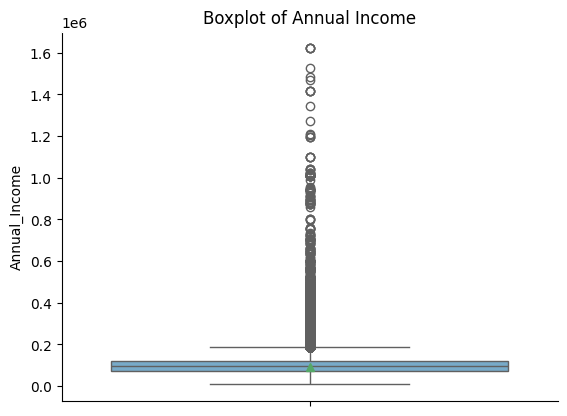

In [61]:
# Poiché sembra avere outliers, si genera un Boxplot per il reddito annuo.

empty_array = ["" for _ in range(508146)]
# Creazione della figura e degli assi
fig, ax = plt.subplots()
# Imposta lo sfondo della figura e degli assi
fig.patch.set_facecolor("white")  # Sfondo dell'intera figura
ax.set_facecolor("white")  # Sfondo degli assi (dove ci sono i dati)
ax.tick_params(axis="y", colors="black")  # Valori asse y in nero
ax.tick_params(axis="x", colors="black")  # Valori asse x in nero
ax.spines["bottom"].set_color("black")  # Asse x in nero
ax.spines["left"].set_color("black")  # Asse y in nero
sns.boxplot(
    x=empty_array,
    y=df["Annual_Income"], # type: ignore
    hue=empty_array,
    showmeans=True,
    palette="Blues",
)
plt.xticks(rotation=45, color="black")
plt.ylabel("Annual_Income", color="black")
plt.title("Boxplot of Annual Income", color="black")
plt.show()
del empty_array

Osservando il Boxplot, si scopre che sono presenti alcuni clienti premium che possiedono auto di lusso e SUV di lusso o più SUV. Questi clienti hanno per lo più polizze Platinium Tier I o II.

Questi assicurati possono essere valori anomali e il conteggio di questi clienti è maggiore del numero di outliers rilevati.

Pertanto, è necessario analizzare gli outliers dopo aver suddiviso i dati in base al tipo di veicolo.

In [62]:
# Partizionamento dei dati rispetto alla variabile 'Vehicle_Type' con conteggio degli outlier per ciascun tipo di veicolo

pretty_display(
    DataFrame(df.groupby("Vehicle_Type")["Annual_Income"].apply(count_iqr_outliers)) # type: ignore
)

,Annual_Income
Vehicle_Type,
Luxury SUV,612
Luxury Car,1071
SUV,898
Normal Car,0


Per un'ulteriore controllo dei valori anomali si genera un Boxplot del reddito annuo suddiviso in base al tipo di veicolo

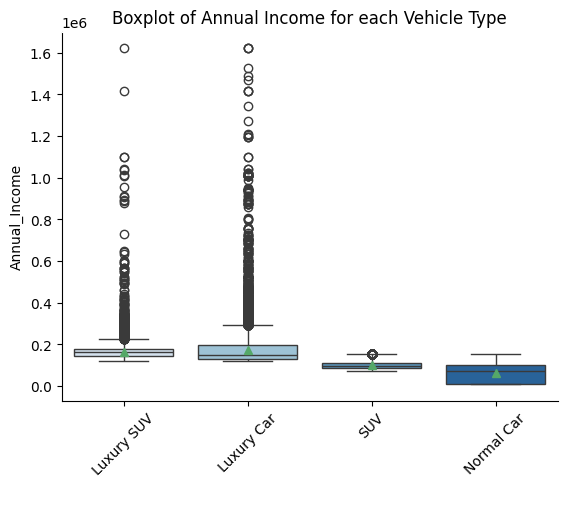

In [63]:
# Creazione del boxplot

# Creazione della figura e degli assi
fig, ax = plt.subplots()
fig.patch.set_facecolor("white")  # Sfondo dell'intera figura
ax.set_facecolor("white")  # Sfondo degli assi (dove ci sono i dati)
ax.tick_params(axis="y", colors="black")  # Valori asse y in nero
ax.tick_params(axis="x", colors="black")  # Valori asse x in nero
ax.spines["bottom"].set_color("black")  # Asse x in nero
ax.spines["left"].set_color("black")  # Asse y in nero
sns.boxplot(
    x="Vehicle_Type",  # Si imposta la variabile categoriale sull'asse x (gruppi)
    y="Annual_Income",  # Si imposta la variabile numerica sull'asse y (valori)
    hue="Vehicle_Type",
    showmeans=True,  # Si mostra la media con un puntatore a forma di diamante
    data=df,
    palette="Blues",
)

# Si ruotano le etichette dell'asse x per evitare sovrapposizioni
plt.xticks(rotation=45, color="black")
plt.ylabel("Vehicle_Type", color="black")
plt.ylabel("Annual_Income", color="black")
plt.title("Boxplot of Annual Income for each Vehicle Type", color="black")
plt.show()

* Dopo aver suddiviso i dati in base al tipo di veicolo, è stato identificato un numero significativo di outliers (2581).
* L'analisi dei boxplot suggerisce che i valori anomali per i SUV sono vicini al confine della distribuzione e potenzialmente non rappresentano dei valori anomali reali.
* Dopo aver escluso i potenziali valori anomali per i SUV, restano 1683 outliers per le auto di lusso e per i SUV di lusso.
* La conoscenza del dominio suggerisce che sono previsti valori anomali in questa classe di clienti.
* La percentuale di valori anomali rimanenti (0,3%) rientra in un intervallo accettabile.
* Inoltre, tutti i valori anomali sono nelle polizze premium di Platinium Tier I e II.

## Pulizia dei dati

Poiché i dati non hanno duplicati o valori mancanti, non è richiesta alcuna pulizia per la duplicazione o la gestione dei valori mancanti.

Dall'analisi preliminare si è visto che i tipi di dati e i valori univoci delle colonne non possegono dati errati che richiedano una correzzione.

L'analisi degli outlier ha anche mostrato che gli i valori anomali sono critici e dovrebbero essere mantenuti.

# EDA: Analisi esplorativa dei dati

Per generare un sistema di raccomandazione basato sulla variabile risposta "Polizza" e le variabili esplicative, è fondamentale condurre un'analisi esplorativa dei dati approfondita.
Condurre un'analisi esplorativa dei dati è cruciale per comprendere le relazioni tra la variabile risposta "Polizza" e le variabili esplicative. Utilizzando una combinazione di analisi si può costruire un sistema di raccomandazione più efficace e informato.
A seguire si elencano le analisi che sono state considerate:

   1. **Analisi Univariata**
   - **Distribuzione della Variabile Risposta**: Uso di istogrammi e grafici a barre per visualizzare la distribuzione delle polizze. Questo aiuterà a comprendere quali polizze sono più comuni e se ci sono classi molto sbilanciate.
   - **Statistiche Descrittive**: Calcolo di medie, mediane, moda e deviazioni standard per le variabili numeriche.
   2. **Analisi Bivariata**
   - **Boxplot e Violin Plot**: Creazione di boxplot o violin plot per confrontare le variabili esplicative rispetto ai diversi tipi di polizza. Questo  aiuterà a identificare eventuali differenze significative tra le categorie.
   - **Tabelle di Contingenza**: Per variabili categoriali, si crea la di contingenza per esplorare le relazioni tra la polizza e altre variabili categoriali.

   3. **Correlazione e multicollinearità**
   - **Matrice di Correlazione**: Calcolo e visualizzazione di una matrice di correlazione per identificare le relazioni tra le variabili esplicative e la variabile risposta.
   - **Variance Inflation Factor**: utile per diagnosticare problemi di multicollinearità che possono influenzare negativamente le stime dei coefficienti in un modello di regressione.

## Analisi univariata

L'analisi univariata si concentra sull'esame di una singola variabile per comprenderne le caratteristiche fondamentali. Di seguito le principali attività svolte durante questa fase:

- Calcolo delle Statistiche Descrittive: Questa è una delle prime operazioni da eseguire. Le statistiche descrittive forniscono informazioni sul centro e sulla dispersione dei dati, inclusi:
    - Media
    - Mediana
    - Moda
    - Deviazione standard
    - Minimo e massimo
    - Quartili

- Visualizzazione dei Dati: La visualizzazione è fondamentale per comprendere la distribuzione e le caratteristiche della variabile. Alcuni grafici comuni includono:
    - Istogrammi: Utilizzati per visualizzare la distribuzione dei dati. Si possono creare con il metodo .hist().
    - Boxplot: Mostrano la mediana, i quartili e gli outlier. Si possono utilizzare sns.boxplot() di Seaborn o df.boxplot() di Pandas.
    - Grafici a barre e a torta: Utilizzati per variabili categoriali per rappresentare le frequenze relative5.
- Analisi della Distribuzione: È utile calcolare l'asimmetria e la curtosi della distribuzione per comprendere meglio la forma dei dati. Si possono usare i metodi .skew() e .kurt() per ottenere queste misure.

### Policy

In [64]:
print("Frequenze assolute e relative di Policy:")
print()
print(f"{df['Policy'].value_counts()}\n\n{df['Policy'].value_counts(normalize=True)}\n")  # type: ignore

Frequenze assolute e relative di Policy:

Policy
Basic                94267
Silver Tier II       90590
Silver Tier I        83177
Gold Tier II         68972
Gold Tier I          62557
Platinium Tier II    54739
Platinium Tier I     53844
Name: count, dtype: int64

Policy
Basic                0.185512
Silver Tier II       0.178276
Silver Tier I        0.163687
Gold Tier II         0.135733
Gold Tier I          0.123108
Platinium Tier II    0.107723
Platinium Tier I     0.105962
Name: proportion, dtype: float64



In [65]:
print("Statistiche di Policy:")
print()
print(df["Policy"].describe())  # type: ignore

Statistiche di Policy:

count     508146
unique         7
top        Basic
freq       94267
Name: Policy, dtype: object


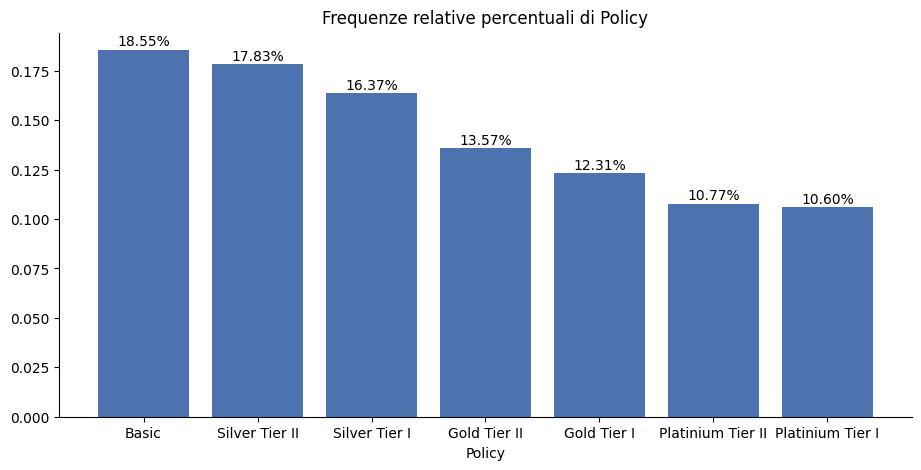

In [66]:
# Calcola le frequenze relative e relative percentuali
policy_relatives = df["Policy"].value_counts(normalize=True)  # type: ignore
policy_percentages = df["Policy"].value_counts(normalize=True) * 100  # type: ignore

sns.set_palette("deep")

# Crea l'istogramma
fig, ax = plt.subplots(figsize=(11, 5))
fig.patch.set_facecolor("white")  # Sfondo dell'intera figura
ax.set_facecolor("white")  # Sfondo degli assi (dove ci sono i dati)
ax.tick_params(axis="y", colors="black")  # Valori asse y in nero
ax.tick_params(axis="x", colors="black")  # Valori asse x in nero
ax.spines["bottom"].set_color("black")  # Asse x in nero
ax.spines["left"].set_color("black")  # Asse y in nero
bars = plt.bar(policy_percentages.index, policy_relatives.values)  # type: ignore
plt.xlabel("Policy", color="black")  # Etichetta asse x in nero
plt.title("Frequenze relative percentuali di Policy", color="black")  # Titolo in nero

# Aggiungi le etichette delle percentuali sulle barre
for bar, percentage in zip(bars, policy_percentages):
    ax.annotate(
        f"{percentage:.2f}%",
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        color="black",
    )

plt.show()

Ciò che si può evincere dall'istogramma delle polizze è un ordinamento decrescente verso i tipi di polizza con più garanzie

### Age

In [67]:
print("Frequenze assolute e relative di Age:")
print()
print(f"{df['Age'].value_counts()}\n\n{df['Age'].value_counts(normalize=True)}\n")  # type: ignore

Frequenze assolute e relative di Age:

Age
24    34565
23    32353
22    28058
25    27578
21    21910
      ...  
81       77
82       42
83       32
84       18
85       12
Name: count, Length: 66, dtype: int64

Age
24    0.068022
23    0.063669
22    0.055216
25    0.054272
21    0.043118
        ...   
81    0.000152
82    0.000083
83    0.000063
84    0.000035
85    0.000024
Name: proportion, Length: 66, dtype: float64



In [68]:
print("Statistiche di Age:")
print()
print(df["Age"].describe())  # type: ignore

Statistiche di Age:

count    508146.000000
mean         38.808413
std          15.500179
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64


In [69]:
print(f'Asimmetria: {df["Age"].skew()}') # type: ignore
print(f'Curtosi: {df["Age"].kurt()}') # type: ignore

Asimmetria: 0.6727513272243791
Curtosi: -0.5646650885490194


1. Un assimetria positiva indica che la distribuzione dei dati è asimmetrica a destra. Ciò significa che c'è una coda più lunga verso i valori maggiori.
Come mostrato dall'istogramma, vi è una presenza maggiore di persone più giovani e un numero inferiore di persone più anziane. I valori più alti (ad esempio, età superiori a 50 o 60 anni) influenzano la media, spostandola a destra rispetto alla mediana.

2. Il valore della curtosi è negativo, questo indica che la distribuzione è platicurtica, il che significa che ha code più leggere e un picco meno appuntito rispetto a una distribuzione normale (che ha curtosi pari a 3). La distribuzione dell'età ha meno outliers rispetto a una distribuzione normale. I dati sono più distribuiti attorno alla media, senza picchi estremi o valori anomali.

Un istogramma con KDE (Kernel Density Estimation) è una rappresentazione grafica che combina due metodi per visualizzare la distribuzione di un insieme di dati.

L'istogramma è uno strumento tradizionale utilizzato per mostrare la distribuzione di una variabile continua. Le barre dell'istogramma rappresentano la frequenza dei dati all'interno di intervalli specifici, chiamati "bin". Ogni barra mostra quanti valori rientrano in ciascun intervallo, permettendo di osservare la forma e la distribuzione dei dati.

Caratteristiche principali:
 - Asse orizzontale: rappresenta i valori dei dati.
 - Asse verticale: indica il numero di dati che rientrano in ciascun intervallo.
 - Utilizzo: utile per identificare il centro, la dispersione e la presenza di outlier nei dati2.

Kernel Density Estimation (KDE)

La stima kernel di densità è un metodo non parametrico che consente di stimare la densità di probabilità di una variabile continua. A differenza dell'istogramma, che utilizza bin discreti, il KDE fornisce una stima continua della densità, risultando in una curva più liscia e dettagliata della distribuzione dei dati.

Vantaggi del KDE:
 - Curva continua: fornisce una visione più fluida della distribuzione.
 - Identificazione delle modalità: può rivelare strutture come distribuzioni bimodali che potrebbero non essere evidenti in un istogramma14.

Combinazione di Istogramma e KDE

Sovrapporre un istogramma con un grafico KDE è una pratica comune per ottenere una visione più completa della distribuzione dei dati. L'istogramma fornisce informazioni discrete sulla frequenza, mentre il KDE offre una rappresentazione continua della densità. Questa combinazione permette di vedere chiaramente le caratteristiche chiave della distribuzione, come picchi e modalità12.

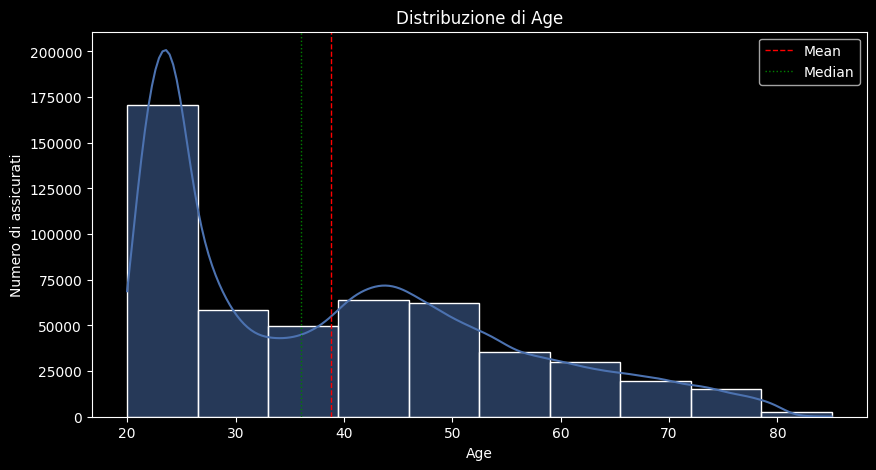

In [70]:
# Si creare un istogramma con KDE
plt.figure(figsize=(10, 5))
sns.histplot(df["Age"], bins=10, kde=True) # type: ignore
plt.axvline(
    df["Age"].mean(), color="red", linestyle="dashed", linewidth=1, label="Mean" # type: ignore
)
plt.axvline(
    df["Age"].median(), color="green", linestyle="dotted", linewidth=1, label="Median" # type: ignore
)
plt.title("Distribuzione di Age")
plt.xlabel("Age")
plt.ylabel("Numero di assicurati")
plt.legend()
plt.show()

L'analisi dell'istogramma dell'età degli assicurati offre spunti preziosi per comprendere le dinamiche demografiche e comportamentali degli assicurati. Le variazioni nel numero degli assicurati in diverse fasce d'età possono evidenziare non solo le tendenze demografiche ma anche le risposte del mercato alle condizioni economiche.

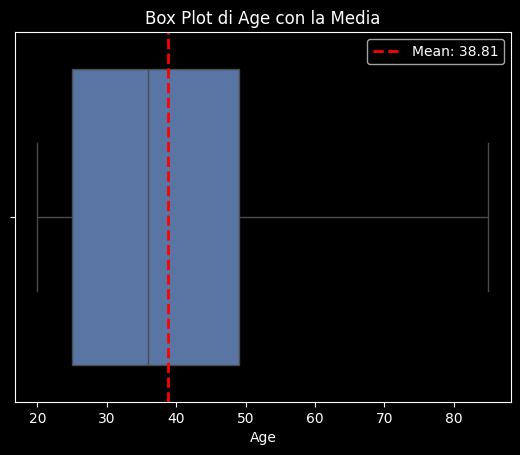

In [71]:
import seaborn as sns

# Crea il box plot
sns.boxplot(x=df["Age"]) # type: ignore
media = df["Age"].mean() # type: ignore
plt.axvline(
    media, color="red", linestyle="dashed", linewidth=2, label=f"Mean: {media:.2f}"
)
plt.title("Box Plot di Age con la Media")
plt.xlabel("Age")
plt.legend()
plt.show()

Dal box plot della variabile Age, basato sulle statistiche fornite, si possono dedurre diverse informazioni importanti riguardo alla distribuzione dei dati:

- Interpretazione del Box Plot

  1. Quartili:
    - Q1 (25° percentile): 25 anni
    - Q2 (Mediana o 50° percentile): 36 anni
    - Q3 (75° percentile): 49 anni
    - La box rappresenta l'intervallo interquartile (IQR), che è la distanza tra Q1 e Q3. In questo caso, l'IQR è 49−25 = 24. Questo indica che il 50% centrale dei dati si trova tra 25 e 49 anni.

  2. Whiskers:
    - Minimo: 20 anni
    - Massimo: 85 anni
    - I "whiskers" del box plot si estendono fino ai valori minimi e massimi che non sono considerati outliers. Qui, il valore minimo è 20 e il massimo è 85.

  3. Outliers:
    - Gli outliers sono definiti come valori che si trovano oltre 1.5×IQR sopra Q3 o sotto Q1.
    - Calcolando 1.5×IQR=36, si può determinare i limiti per identificare eventuali outliers:
      - Limite superiore: 49+36=85
      - Limite inferiore: 25−36=−11 (non applicabile poiché non ci sono età negative).
    - Dato che il massimo è esattamente 85, non ci sono outliers superiori; tuttavia, se ci fossero valori significativamente più alti di 85, sarebbero considerati outliers.

  4. Simmetria e Distribuzione:
    - La posizione della mediana rispetto ai quartili può indicare la simmetria della distribuzione. In questo caso, la mediana (36) è più vicina a Q1 (25) rispetto a Q3 (49), suggerendo una leggera asimmetria verso valori più alti.

  5. Conclusioni Generali:
    - La maggior parte degli individui ha un'età compresa tra i 25 e i 49 anni.
    - C'è una variabilità significativa nelle età, con alcuni individui che raggiungono i 85 anni.
    - La distribuzione presenta una leggera asimmetria, con una maggiore concentrazione di età inferiori rispetto ai valori più alti.

### Annual Income

In [72]:
print("Frequenze assolute e relative di Annual Income:")
print()
print(
    f"{df['Annual_Income'].value_counts()}\n\n{df['Annual_Income'].value_counts(normalize=True)}\n" # type: ignore
)  # type: ignore

Frequenze assolute e relative di Annual Income:

Annual_Income
7890      86488
209568      185
135537       57
115356       56
117024       55
          ...  
137649        1
54585         1
243210        1
166797        1
188625        1
Name: count, Length: 52062, dtype: int64

Annual_Income
7890      0.170203
209568    0.000364
135537    0.000112
115356    0.000110
117024    0.000108
            ...   
137649    0.000002
54585     0.000002
243210    0.000002
166797    0.000002
188625    0.000002
Name: proportion, Length: 52062, dtype: float64



In [73]:
print("Statistiche di Annual Income:")
print()
print(df["Annual_Income"].describe())  # type: ignore

Statistiche di Annual Income:

count    5.081460e+05
mean     9.166336e+04
std      5.143972e+04
min      7.890000e+03
25%      7.314300e+04
50%      9.498300e+04
75%      1.182112e+05
max      1.620495e+06
Name: Annual_Income, dtype: float64


In [74]:
print(f'Asimmetria: {df["Annual_Income"].skew()}') # type: ignore
print(f'Curtosi: {df["Annual_Income"].kurt()}') # type: ignore

Asimmetria: 1.6001760590705745
Curtosi: 30.047860284727584


1. Il valore di asimmetria calcolato è 1.6002, il che indica una asimmetria positiva. Questo significa che la distribuzione dei redditi ha una coda più lunga a destra, suggerendo che ci sono alcuni redditi molto alti che influenzano la media. Questa distribuzione è tipica in contesti economici, dove pochi individui possono avere redditi significativamente superiori alla maggior parte della popolazione, come nel caso dei redditi elevati o delle ricchezze accumulate.

2. Il valore di curtosi è 30.0479, un numero estremamente alto che suggerisce una distribuzione leptocurtica. Le distribuzioni leptocurtiche sono caratterizzate da un picco molto alto e code più pesanti rispetto a una distribuzione normale. Questo implica che la maggior parte dei dati è concentrata attorno alla media, ma ci sono anche frequenze elevate di valori estremi.

I dati mostrano una distribuzione dei redditi con una forte asimmetria positiva e una curtosi molto alta. Queste caratteristiche suggeriscono che la maggior parte degli assicurati ha redditi relativamente bassi, mentre un numero ristretto di individui ha redditi molto elevati.

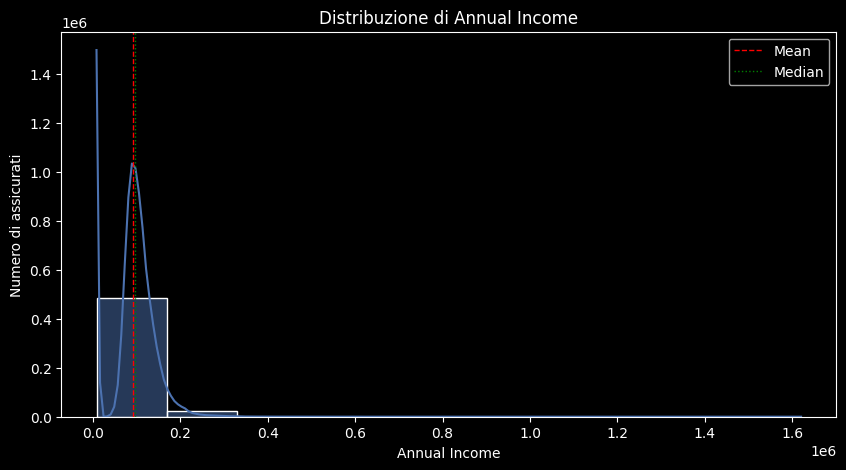

In [75]:
# Si creare un istogramma con KDE
plt.figure(figsize=(10, 5))
sns.histplot(df["Annual_Income"], bins=10, kde=True) # type: ignore
plt.axvline(
    df["Annual_Income"].mean(), # type: ignore
    color="red",
    linestyle="dashed",
    linewidth=1,
    label="Mean",
)
plt.axvline(
    df["Annual_Income"].median(), # type: ignore
    color="green",
    linestyle="dotted",
    linewidth=1,
    label="Median",
)
plt.title("Distribuzione di Annual Income")
plt.xlabel("Annual Income")
plt.ylabel("Numero di assicurati")
plt.legend()
plt.show()

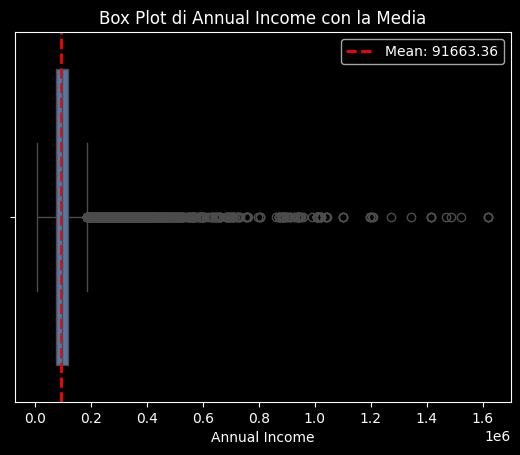

In [76]:
import seaborn as sns

# Crea il box plot
sns.boxplot(x=df["Annual_Income"]) # type: ignore
media = df["Annual_Income"].mean() # type: ignore
plt.axvline(
    media, color="red", linestyle="dashed", linewidth=2, label=f"Mean: {media:.2f}"
)
plt.title("Box Plot di Annual Income con la Media")
plt.xlabel("Annual Income")
plt.legend()
plt.show()

Il boxplot mostra che la maggior parte dei dati è concentrata nella parte inferiore del range, suggerendo una distribuzione asimmetrica, come osservato dal valore dell'asimmetria. Questo significa che ci sono molti redditi annuali più bassi, con alcuni redditi molto alti che creano una lunga coda a destra.

Outlier:
La presenza di molti outlier sulla destra indica che ci sono individui con redditi annuali significativamente più elevati rispetto alla maggior parte della popolazione. Questi valori potrebbero essere considerati anomalie ma da quanto già osservato dall'analisi preliminare, questi valori estremi sono critici e andrebbero mantenuti, poiché associati a veicoli di lusso.

### Gender

In [77]:
print("Frequenze assolute e relative di gender:")
print()
print(f"{df['Gender'].value_counts()}\n\n{df['Gender'].value_counts(normalize=True)}\n")  # type: ignore

Frequenze assolute e relative di gender:

Gender
Male      274325
Female    233821
Name: count, dtype: int64

Gender
Male      0.539855
Female    0.460145
Name: proportion, dtype: float64



In [78]:
print("Statistiche di Gender:")
print()
print(df["Gender"].describe())  # type: ignore

Statistiche di Gender:

count     508146
unique         2
top         Male
freq      274325
Name: Gender, dtype: object


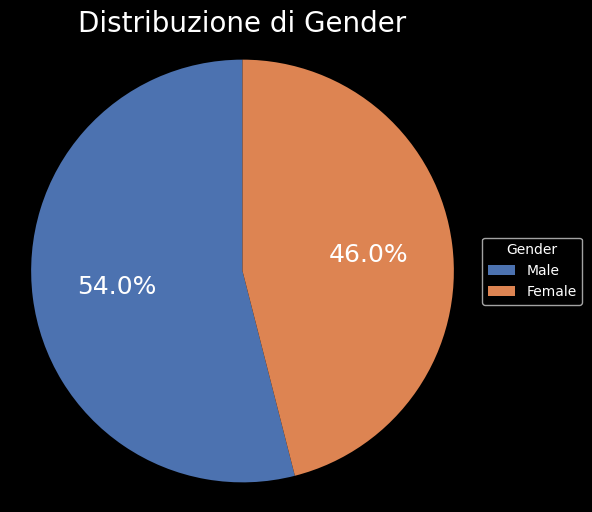

In [79]:
# Si calcola il conteggio per ciascuna categoria
gender_counts = df["Gender"].value_counts() # type: ignore

# definizione colori categorie
# colors = ['pink' if gender == 'Female' else 'lightblue' for gender in gender_counts.index]

# Si crea il grafico a torta
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    gender_counts,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 18},
)

# Si aggiunge una leggenda
ax.legend(
    gender_counts.index, title="Gender", loc="center left", bbox_to_anchor=(1, 0.5)
)

# Titolo del grafico
plt.title("Distribuzione di Gender", fontsize=20)

# Si assicura che il grafico sia visualizzato come un cerchio
ax.axis("equal")

# Si mostra il grafico
plt.show()

### Region Code

In [80]:
print("Frequenze assolute e relative di Region Code:")
print()
print(
    f"{df['Region_Code'].value_counts()}\n\n{df['Region_Code'].value_counts(normalize=True)}\n" # type: ignore
)

Frequenze assolute e relative di Region Code:

Region_Code
NE    187733
W     143897
S      88299
MW     88217
Name: count, dtype: int64

Region_Code
NE    0.369447
W     0.283180
S     0.173767
MW    0.173606
Name: proportion, dtype: float64



In [81]:
print("Statistiche di Region Code:")
print()
print(df["Region_Code"].describe())  # type: ignore

Statistiche di Region Code:

count     508146
unique         4
top           NE
freq      187733
Name: Region_Code, dtype: object


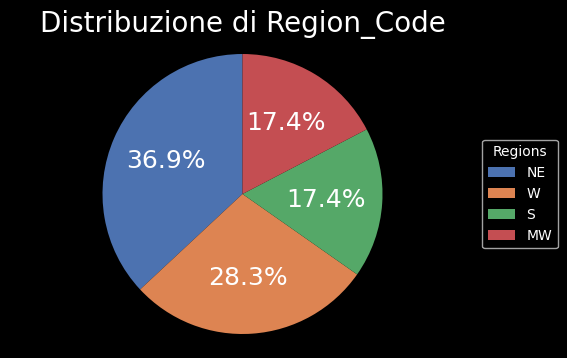

In [82]:
# Si calcola il conteggio per ciascuna categoria
region_counts = df["Region_Code"].value_counts() # type: ignore

# Si crea il grafico a torta
fig, ax = plt.subplots(figsize=(6, 4))
ax.pie(
    region_counts,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 18},
)

# Si aggiunge una leggenda
ax.legend(
    region_counts.index, title="Regions", loc="center left", bbox_to_anchor=(1, 0.5)
)

# Titolo del grafico
plt.title("Distribuzione di Region_Code", fontsize=20)

# Si assicura che il grafico sia visualizzato come un cerchio
ax.axis("equal")

# Si mostra il grafico
plt.show()

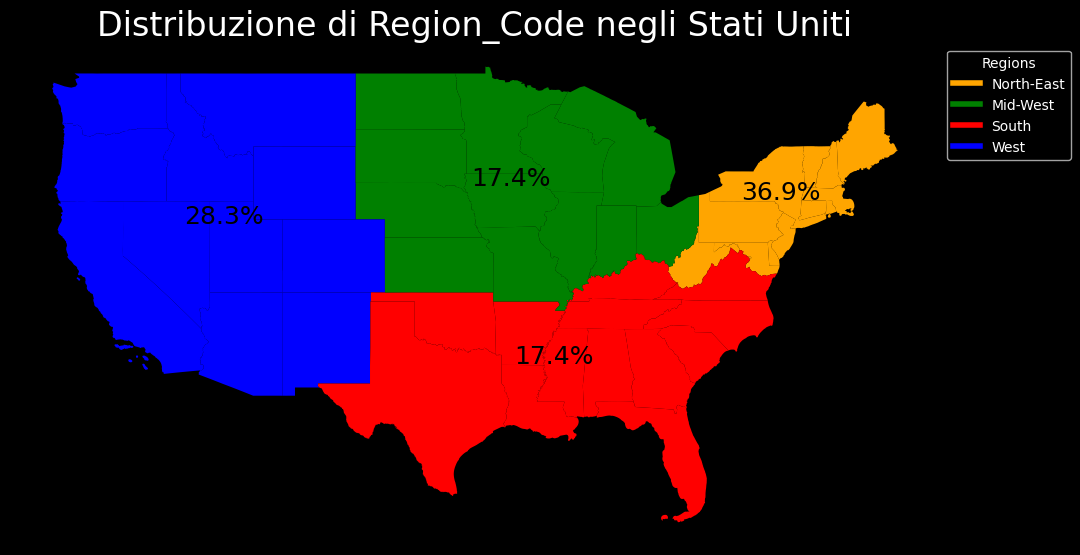

In [85]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Si caricano i dati
usa = gpd.read_file(
    r"G:\Il mio Drive\FORMAZIONE\UniTS\TESI\Case Study\Elaborato Tesi\tl_2024_us_state\tl_2024_us_state.shp"
)

# Si rimuovono le isole
usa = usa[usa["NAME"] != "Hawaii"]
usa = usa[usa["NAME"] != "Guam"]
usa = usa[usa["NAME"] != "United States Virgin Islands"]
usa = usa[usa["NAME"] != "American Samoa"]
usa = usa[usa["NAME"] != "Commonwealth of the Northern Mariana Islands"]
usa = usa[usa["NAME"] != "Puerto Rico"]
usa = usa[usa["NAME"] != "Alaska"]

# Si definisce la mappatura degli stati alle loro regioni
region_mapping = {
    "California": "W",
    "Texas": "S",
    "Florida": "S",
    "New York": "NE",
    "Illinois": "MW",
    "Ohio": "MW",
    "Georgia": "S",
    "Michigan": "MW",
    "North Carolina": "S",
    "Hawaii": "W",
    "New Jersey": "NE",
    "Virginia": "S",
    "Washington": "W",
    "Arizona": "W",
    "Massachusetts": "NE",
    "Tennessee": "S",
    "Indiana": "MW",
    "Missouri": "MW",
    "Maryland": "NE",
    "Wisconsin": "MW",
    "Colorado": "W",
    "Minnesota": "MW",
    "South Carolina": "S",
    "Alabama": "S",
    "Kentucky": "S",
    "Oregon": "W",
    "Iowa": "MW",
    "Connecticut": "NE",
    "Mississippi": "S",
    "Arkansas": "S",
    "Kansas": "MW",
    "Utah": "W",
    "Nevada": "W",
    "New Mexico": "W",
    "West Virginia": "NE",
    "Nebraska": "MW",
    "Idaho": "W",
    "Maine": "NE",
    "New Hampshire": "NE",
    "Rhode Island": "NE",
    "Delaware": "NE",
    "Montana": "W",
    "South Dakota": "MW",
    "North Dakota": "MW",
    "Wyoming": "W",
    "Vermont": "NE",
    "Alaska": "W",
    "District of Columbia": "NE",
    "Puerto Rico": "S",
    "Pennsylvania": "NE",
    "Louisiana": "S",
    "Oklahoma": "S",
    "United States Virgin Islands": "S",
    "Commonwealth of the Northern Mariana Islands": "W",
    "Guam": "W",
    "American Samoa": "W",
}

# Si aggiunge la colonna 'Region' basata sulla mappatura
usa["Region"] = usa["NAME"].map(region_mapping)

# Si calcola il conteggio per ciascuna categoria
region_counts = df["Region_Code"].value_counts(normalize=True) * 100 # type: ignore

# 4. Definire i colori per ciascuna regione
region_colors = {"NE": "orange", "MW": "green", "S": "red", "W": "blue"}

# Si traccia la mappa con colori per regione (senza etichette degli stati)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))  # aumento dimensione mappa
usa.plot(
    column="Region",
    ax=ax,
    legend=True,
    color=usa["Region"].map(region_colors),
    legend_kwds={"bbox_to_anchor": (1, 1)},
)

# Si annotano le percentuali sulla mappa, solo una volta per regione
for region in region_counts.index:
    # Trova il geometria della regione corrispondente
    region_geom = usa[usa["Region"] == region]
    if not region_geom.empty:  # Assicurati che ci siano stati nella regione
        centroid = region_geom.geometry.unary_union.centroid
        percentage = region_counts[region]
        ax.annotate(
            f"{percentage:.1f}%",
            xy=(centroid.x, centroid.y),
            horizontalalignment="center",
            fontsize=18,
            color="black",
        )

# Si aggiunge la leggenda con nomi completi e caratteri più grandi
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in region_colors.values()] # type: ignore
labels = ["North-East", "Mid-West", "South", "West"]
ax.legend(
    handles,
    labels,
    title="Regions",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    fontsize=10,
)

# Si rimuovono gli assi e impostare il titolo
plt.title("Distribuzione di Region_Code negli Stati Uniti", fontsize=24)
plt.axis("off")

# Si mostra la mappa
plt.show()

### Location Type

In [86]:
print("Frequenze assolute e relative di Location Type:")
print()
print(
    f"{df['Location_Type'].value_counts()}\n\n{df['Location_Type'].value_counts(normalize=True)}\n" # type: ignore
)

Frequenze assolute e relative di Location Type:

Location_Type
Urban       236515
Suburban    145521
Rural       126110
Name: count, dtype: int64

Location_Type
Urban       0.465447
Suburban    0.286376
Rural       0.248177
Name: proportion, dtype: float64



In [87]:
print("Statistiche di Location Type:")
print()
print(df["Location_Type"].describe())  # type: ignore

Statistiche di Location Type:

count     508146
unique         3
top        Urban
freq      236515
Name: Location_Type, dtype: object


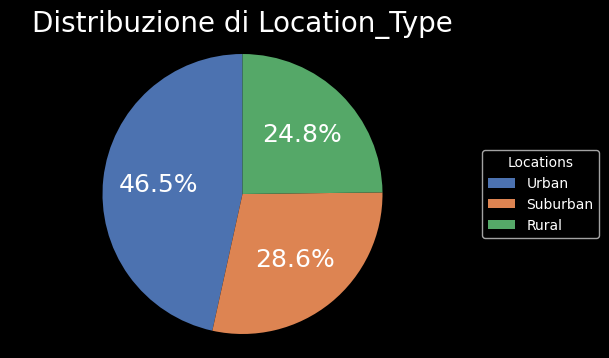

In [88]:
# Si calcola il conteggio per ciascuna categoria
location_counts = df["Location_Type"].value_counts() # type: ignore

# Si crea il grafico a torta
fig, ax = plt.subplots(figsize=(6, 4))
ax.pie(
    location_counts,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 18},
)

# Si aggiunge una leggenda
ax.legend(
    location_counts.index, title="Locations", loc="center left", bbox_to_anchor=(1, 0.5)
)

# Titolo del grafico
plt.title("Distribuzione di Location_Type", fontsize=20)

# Si assicura che il grafico sia visualizzato come un cerchio
ax.axis("equal")

# Si mostra il grafico
plt.show()

### Education

In [89]:
print("Frequenze assolute e relative di Education:")
print()
print(
    f"{df['Education'].value_counts()}\n\n{df['Education'].value_counts(normalize=True)}\n" # type: ignore
)  

Frequenze assolute e relative di Education:

Education
College                 254043
Bachelors               132326
Masters                 114595
Doctor                    6174
High School or Below      1008
Name: count, dtype: int64

Education
College                 0.499941
Bachelors               0.260409
Masters                 0.225516
Doctor                  0.012150
High School or Below    0.001984
Name: proportion, dtype: float64



In [90]:
print("Statistiche di Education:")
print()
print(df["Education"].describe())  # type: ignore

Statistiche di Education:

count      508146
unique          5
top       College
freq       254043
Name: Education, dtype: object


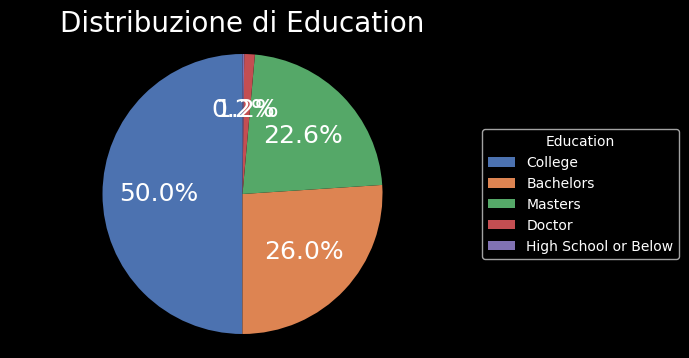

In [91]:
# Si calcola il conteggio per ciascuna categoria
education_counts = df["Education"].value_counts() # type: ignore

# Si crea il grafico a torta
fig, ax = plt.subplots(figsize=(6, 4))
ax.pie(
    education_counts,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 18},
)

# Si aggiunge una leggenda
ax.legend(
    education_counts.index,
    title="Education",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

# Titolo del grafico
plt.title("Distribuzione di Education", fontsize=20)

# Si assicura che il grafico sia visualizzato come un cerchio
ax.axis("equal")

# Si mostra il grafico
plt.show()

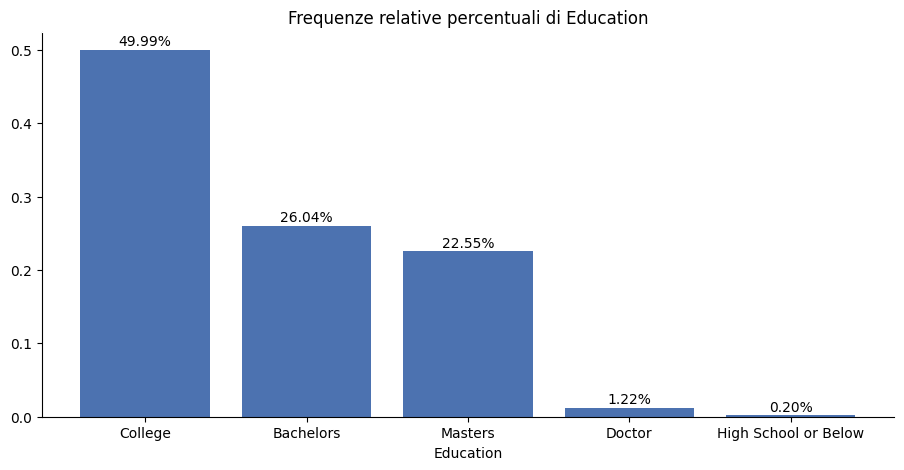

In [92]:
# Calcola le frequenze relative e relative percentuali
education_relatives = df["Education"].value_counts(normalize=True)  # type: ignore
education_percentages = df["Education"].value_counts(normalize=True) * 100  # type: ignore

sns.set_palette("deep")

# Crea l'istogramma
fig, ax = plt.subplots(figsize=(11, 5))
fig.patch.set_facecolor("white")  # Sfondo dell'intera figura
ax.set_facecolor("white")  # Sfondo degli assi (dove ci sono i dati)
ax.tick_params(axis="y", colors="black")  # Valori asse y in nero
ax.tick_params(axis="x", colors="black")  # Valori asse x in nero
ax.spines["bottom"].set_color("black")  # Asse x in nero
ax.spines["left"].set_color("black")  # Asse y in nero
bars = plt.bar(education_percentages.index, education_relatives.values)  # type: ignore

plt.xlabel("Education", color="black")  # Etichetta asse x in nero
plt.title(
    "Frequenze relative percentuali di Education", color="black"
)  # Titolo in nero

# Aggiungi le etichette delle percentuali sulle barre
for bar, percentage in zip(bars, education_percentages):
    ax.annotate(
        f"{percentage:.2f}%",
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        color="black",
    )

plt.show()

### Vehicle Type

In [93]:
print("Frequenze assolute e relative di Vehicle Type:")
print()
print(
    f"{df['Vehicle_Type'].value_counts()}\n\n{df['Vehicle_Type'].value_counts(normalize=True)}\n" # type: ignore
)  

Frequenze assolute e relative di Vehicle Type:

Vehicle_Type
Normal Car    237055
SUV           207023
Luxury SUV     38892
Luxury Car     25176
Name: count, dtype: int64

Vehicle_Type
Normal Car    0.466510
SUV           0.407409
Luxury SUV    0.076537
Luxury Car    0.049545
Name: proportion, dtype: float64



In [94]:
print("Statistiche Vehicle Type:")
print()
print(df["Vehicle_Type"].describe())  # type: ignore

Statistiche Vehicle Type:

count         508146
unique             4
top       Normal Car
freq          237055
Name: Vehicle_Type, dtype: object


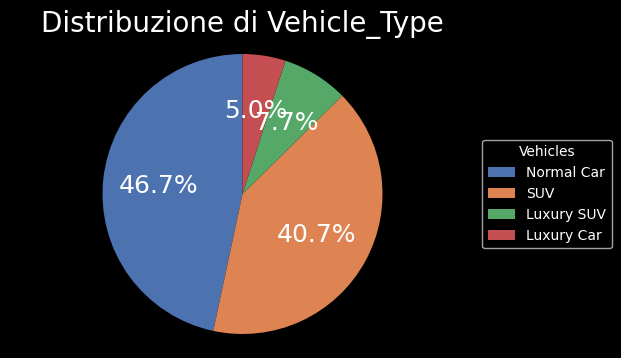

In [95]:
# Si calcola il conteggio per ciascuna categoria
vehicle_counts = df["Vehicle_Type"].value_counts() # type: ignore

# Si crea il grafico a torta
fig, ax = plt.subplots(figsize=(6, 4))
ax.pie(
    vehicle_counts,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 18},
)

# Si aggiunge una leggenda
ax.legend(
    vehicle_counts.index, title="Vehicles", loc="center left", bbox_to_anchor=(1, 0.5)
)

# Titolo del grafico
plt.title("Distribuzione di Vehicle_Type", fontsize=20)

# Si assicura che il grafico sia visualizzato come un cerchio
ax.axis("equal")

# Si mostra il grafico
plt.show()

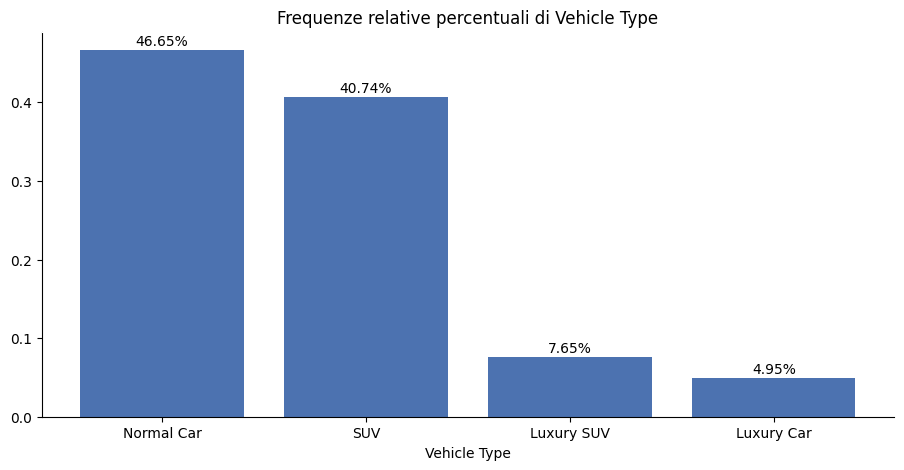

In [96]:
# Calcola le frequenze relative e relative percentuali
vehicle_relatives = df["Vehicle_Type"].value_counts(normalize=True)  # type: ignore
vehicle_percentages = df["Vehicle_Type"].value_counts(normalize=True) * 100  # type: ignore

sns.set_palette("deep")

# Crea l'istogramma
fig, ax = plt.subplots(figsize=(11, 5))
fig.patch.set_facecolor("white")  # Sfondo dell'intera figura
ax.set_facecolor("white")  # Sfondo degli assi (dove ci sono i dati)
ax.tick_params(axis="y", colors="black")  # Valori asse y in nero
ax.tick_params(axis="x", colors="black")  # Valori asse x in nero
ax.spines["bottom"].set_color("black")  # Asse x in nero
ax.spines["left"].set_color("black")  # Asse y in nero
bars = plt.bar(vehicle_percentages.index, vehicle_relatives.values)  # type: ignore

plt.xlabel("Vehicle Type", color="black")  # Etichetta asse x in nero
plt.title(
    "Frequenze relative percentuali di Vehicle Type", color="black"
)  # Titolo in nero

# Aggiungi le etichette delle percentuali sulle barre
for bar, percentage in zip(bars, vehicle_percentages):
    ax.annotate(
        f"{percentage:.2f}%",
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        color="black",
    )

plt.show()

### Previously Insured

In [97]:
print("Frequenze assolute e relative di Previously Insured:")
print()
print(
    f"{df['Previously_Insured'].value_counts()}\n\n{df['Previously_Insured'].value_counts(normalize=True)}\n" # type: ignore
)  

Frequenze assolute e relative di Previously Insured:

Previously_Insured
No     275076
Yes    233070
Name: count, dtype: int64

Previously_Insured
No     0.541333
Yes    0.458667
Name: proportion, dtype: float64



In [98]:
print("Statistiche di Previously Insured:")
print()
print(df["Previously_Insured"].describe())  # type: ignore

Statistiche di Previously Insured:

count     508146
unique         2
top           No
freq      275076
Name: Previously_Insured, dtype: object


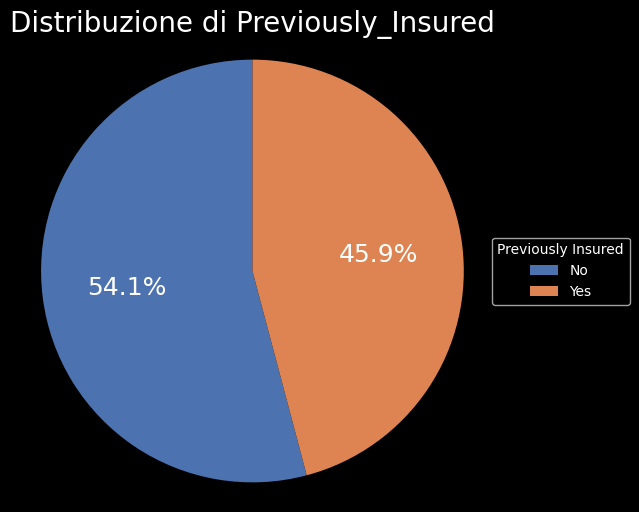

In [99]:
# Si calcola il conteggio per ciascuna categoria
gender_counts = df["Previously_Insured"].value_counts() # type: ignore

# definizione colori categorie
# colors = ['pink' if gender == 'Female' else 'lightblue' for gender in gender_counts.index]

# Si crea il grafico a torta
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    gender_counts,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 18},
)

# Si aggiunge una leggenda
ax.legend(
    gender_counts.index,
    title="Previously Insured",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

# Titolo del grafico
plt.title("Distribuzione di Previously_Insured", fontsize=20)

# Si assicura che il grafico sia visualizzato come un cerchio
ax.axis("equal")

# Si mostra il grafico
plt.show()

### Vehicle Age

In [100]:
print("Frequenze assolute e relative di Vehicle Age:")
print()
print(
    f"{df['Vehicle_Age'].value_counts()}\n\n{df['Vehicle_Age'].value_counts(normalize=True)}\n" # type: ignore
)  

Frequenze assolute e relative di Vehicle Age:

Vehicle_Age
10-20 Years    267015
< 10 Years     219805
> 20 Years      21326
Name: count, dtype: int64

Vehicle_Age
10-20 Years    0.525469
< 10 Years     0.432563
> 20 Years     0.041968
Name: proportion, dtype: float64



In [101]:
print("Statistiche di Vehicle Age:")
print()
print(df["Vehicle_Age"].describe())  # type: ignore

Statistiche di Vehicle Age:

count          508146
unique              3
top       10-20 Years
freq           267015
Name: Vehicle_Age, dtype: object


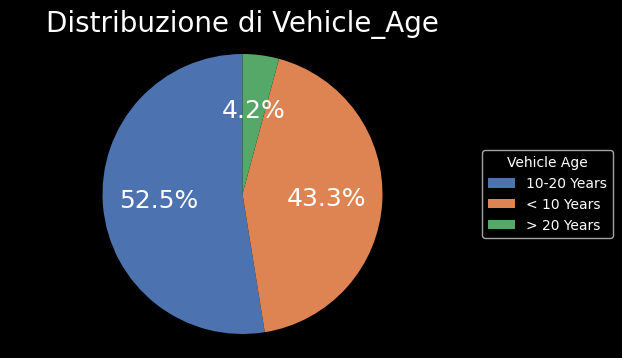

In [102]:
# Si calcola il conteggio per ciascuna categoria
education_counts = df["Vehicle_Age"].value_counts() # type: ignore

# Si crea il grafico a torta
fig, ax = plt.subplots(figsize=(6, 4))
ax.pie(
    education_counts,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 18},
)

# Si aggiunge una leggenda
ax.legend(
    education_counts.index,
    title="Vehicle Age",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

# Titolo del grafico
plt.title("Distribuzione di Vehicle_Age", fontsize=20)

# Si assicura che il grafico sia visualizzato come un cerchio
ax.axis("equal")

# Si mostra il grafico
plt.show()

### Vehicle Damage

In [103]:
print("Frequenze assolute e relative di Vehicle Damage:")
print()
print(
    f"{df['Vehicle_Damage'].value_counts()}\n\n{df['Vehicle_Damage'].value_counts(normalize=True)}\n" # type: ignore
)  

Frequenze assolute e relative di Vehicle Damage:

Vehicle_Damage
Yes    256248
No     251898
Name: count, dtype: int64

Vehicle_Damage
Yes    0.50428
No     0.49572
Name: proportion, dtype: float64



In [104]:
print("Statistiche di Vehicle Damage:")
print()
print(df["Vehicle_Damage"].describe())  # type: ignore

Statistiche di Vehicle Damage:

count     508146
unique         2
top          Yes
freq      256248
Name: Vehicle_Damage, dtype: object


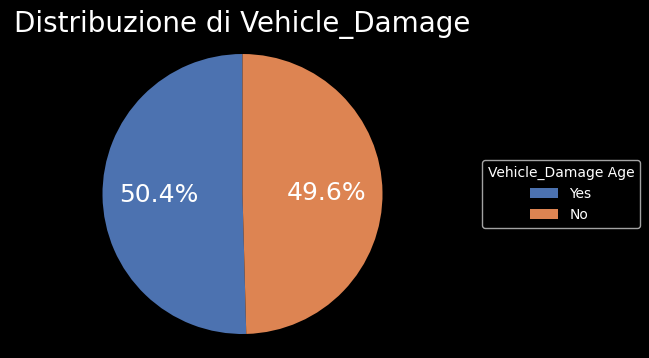

In [105]:
# Si calcola il conteggio per ciascuna categoria
education_counts = df["Vehicle_Damage"].value_counts() # type: ignore

# Si crea il grafico a torta
fig, ax = plt.subplots(figsize=(6, 4))
ax.pie(
    education_counts,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 18},
)

# Si aggiunge una leggenda
ax.legend(
    education_counts.index,
    title="Vehicle_Damage Age",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

# Titolo del grafico
plt.title("Distribuzione di Vehicle_Damage", fontsize=20)

# Si assicura che il grafico sia visualizzato come un cerchio
ax.axis("equal")

# Si mostra il grafico
plt.show()

## Analisi bivariata

### Boxplot & Violin Plot: Policy + Annual Income

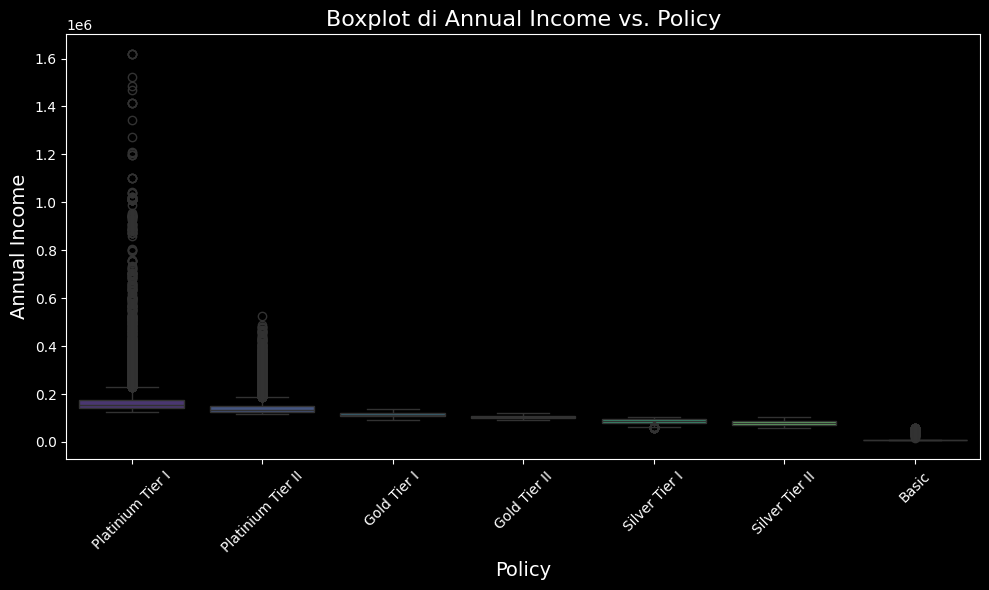

In [106]:
# Si crea un boxplot per Annual_Income rispetto a Policy
plt.figure(figsize=(10, 6))
sns.boxplot(x="Policy", y="Annual_Income", data=df, palette="viridis")
plt.title("Boxplot di Annual Income vs. Policy", fontsize=16)
plt.xlabel("Policy", fontsize=14)
plt.ylabel("Annual Income", fontsize=14)
plt.xticks(rotation=45)  # Ruota le etichette se necessario
plt.tight_layout()
plt.show()

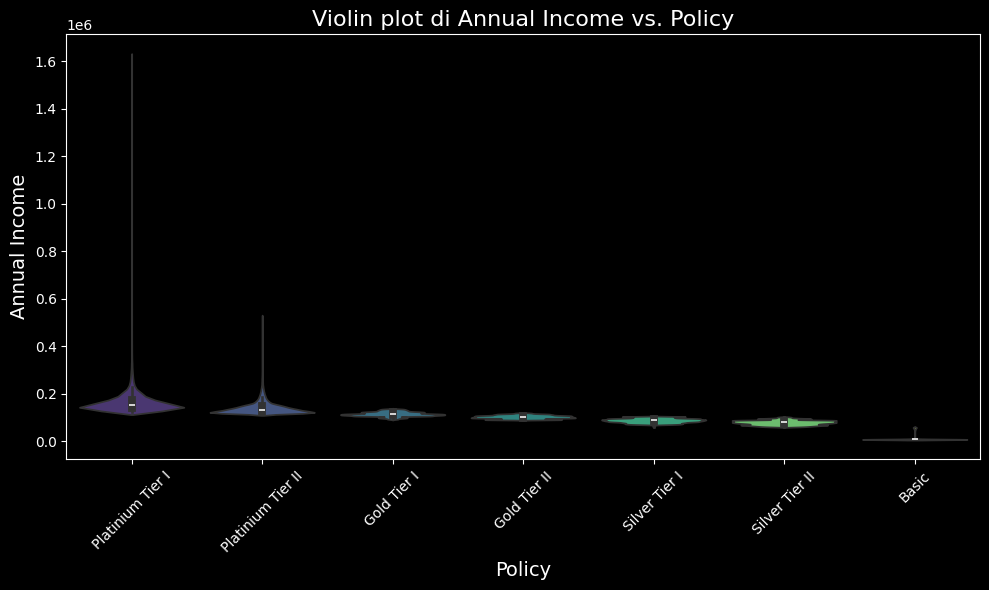

In [107]:
# Si crea un violin plot per Annual_Income rispetto a Policy
plt.figure(figsize=(10, 6))
sns.violinplot(x="Policy", y="Annual_Income", data=df, palette="viridis")
plt.title("Violin plot di Annual Income vs. Policy", fontsize=16)
plt.xlabel("Policy", fontsize=14)
plt.ylabel("Annual Income", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. Distribuzione del Reddito per categorie di Polizza:

    - Platinum Tier I: Questa categoria ha la distribuzione del reddito annuale più ampia, con valori che raggiungono circa 1,6 milioni di unità. Tuttavia, gran parte dei dati è concentrata intorno a valori molto più bassi, con una forte concentrazione tra 0 e circa 200.000. Ciò indica una grande varianza del reddito, con alcuni individui che guadagnano molto di più rispetto agli altri.
    - Platinum Tier II: La distribuzione è ancora relativamente ampia, ma meno estrema rispetto al Platinum Tier I. La maggior parte dei redditi si concentra intorno ai 200.000, con una piccola coda che si estende oltre questo valore.
    - Gold Tier I e II, Silver Tier I e II: Queste categorie mostrano distribuzioni più compatte e simili tra loro. Le differenze di reddito sembrano meno pronunciate rispetto ai livelli Platinum, con la maggior parte dei valori concentrati attorno a un reddito annuale vicino a 100.000 o inferiore. Non ci sono code particolarmente lunghe, il che suggerisce una maggiore omogeneità nei guadagni in queste categorie.
    - Basic: Questa categoria presenta una distribuzione molto ridotta e compatta, con un reddito che sembra concentrarsi a valori estremamente bassi, intorno a circa 0 e con una varianza minima. È evidente che gli individui che scelgono questa categoria di polizza hanno redditi molto bassi rispetto agli altri livelli di polizza.

2. Varianza del Reddito:

    - Le polizze Platinum Tier I e Tier II mostrano una maggiore varianza nei redditi, con code lunghe che indicano la presenza di alcuni individui che guadagnano molto di più rispetto alla maggioranza. Questo potrebbe suggerire che queste polizze siano attrattive per individui con redditi alti, ma che ci sia una maggiore diversità nei redditi di chi opta per queste categorie.
    - Al contrario, le categorie Gold e Silver mostrano distribuzioni più strette, suggerendo che i clienti che optano per queste polizze hanno redditi più simili tra loro.

3. Platinum Tier I come Eccezione:
    - La distribuzione per Platinum Tier I è particolarmente interessante perché sembra avere una forte concentrazione attorno a redditi relativamente bassi, ma con una lunga coda che arriva a redditi molto elevati. Questo potrebbe indicare che anche persone con redditi moderati scelgono questo livello di polizza, pur essendo generalmente attrattiva per individui con redditi molto alti.

4. Polizza Basic:
    - La polizza Basic si distingue per avere la distribuzione di reddito più contenuta. È chiaro che chi sceglie questa polizza ha un reddito molto basso rispetto a tutte le altre categorie. Questo riflette probabilmente una scelta orientata al risparmio, con individui che hanno limitate risorse finanziarie.

Conclusione:
I clienti con redditi più elevati tendono a scegliere le polizze Platinium, con la possibilità di avere redditi anche molto variabili, mentre coloro con redditi medi o medio-bassi si orientano verso polizze Gold e Silver.
Le persone con redditi molto bassi optano per la polizza Basic, con una distribuzione molto concentrata verso il basso.
C'è una relazione evidente tra il tipo di polizza scelta e la fascia di reddito, con una maggiore eterogeneità di reddito per le categorie di polizze premium (Platinum), mentre le polizze di livello inferiore mostrano una maggiore omogeneità nei redditi.

### Boxplot & Violin Plot: Policy + Age

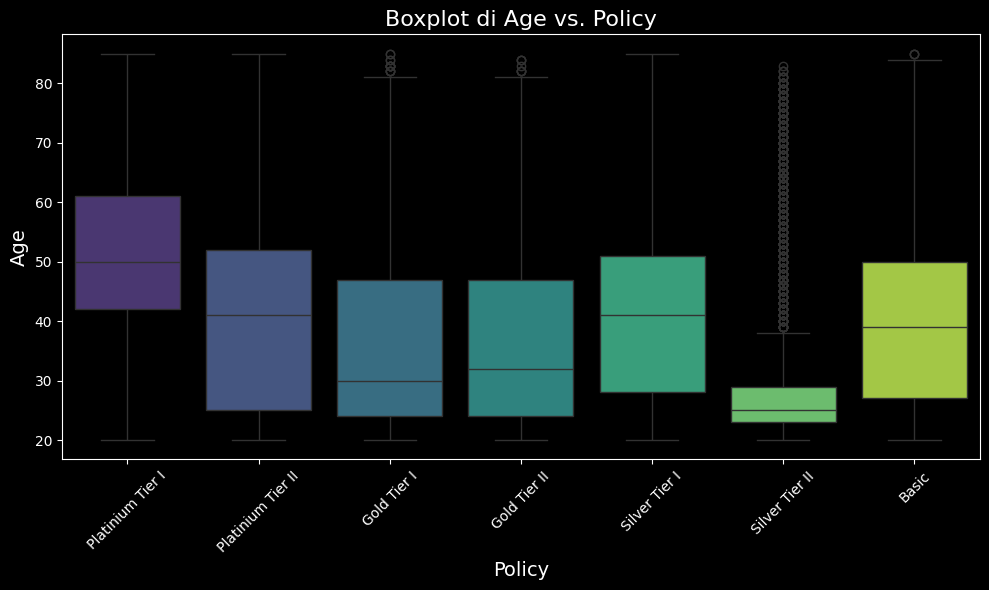

In [108]:
# Si crea un boxplot per Age rispetto a Policy
plt.figure(figsize=(10, 6))
sns.boxplot(x="Policy", y="Age", data=df, palette="viridis")
plt.title("Boxplot di Age vs. Policy", fontsize=16)
plt.xlabel("Policy", fontsize=14)
plt.ylabel("Age", fontsize=14)
plt.xticks(rotation=45)  # Ruota le etichette se necessario
plt.tight_layout()
plt.show()

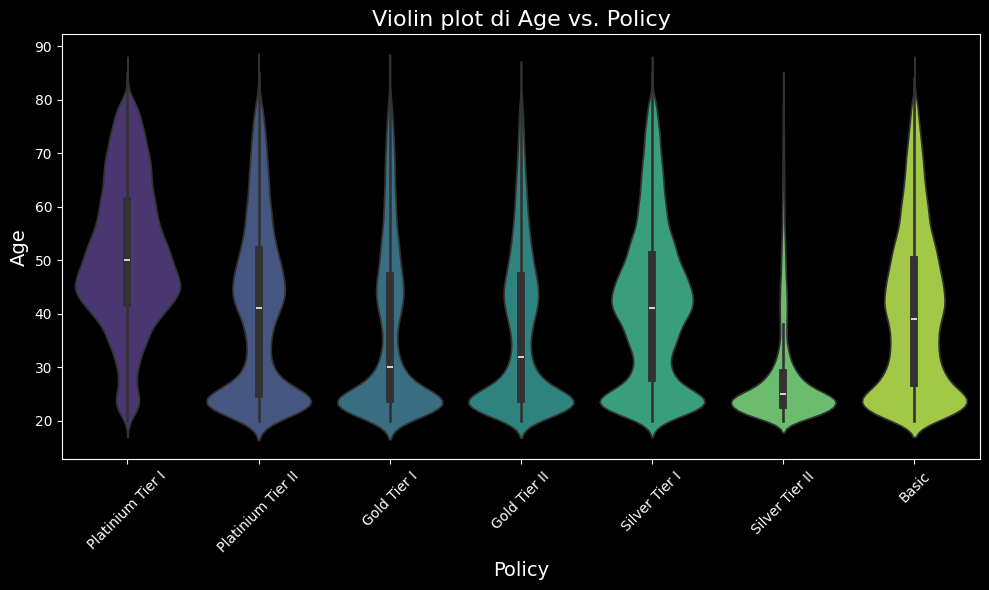

In [109]:
# Si crea un violin plot per Age rispetto a Policy
plt.figure(figsize=(10, 6))
sns.violinplot(x="Policy", y="Age", data=df, palette="viridis")
plt.title("Violin plot di Age vs. Policy", fontsize=16)
plt.xlabel("Policy", fontsize=14)
plt.ylabel("Age", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. Distribuzione dell'Età per Categorie:
    - Platinum Tier I: La distribuzione dell'età è abbastanza ampia. La maggior parte degli assicurati si colloca in una fascia tra i 30 e i 60 anni, con una leggera coda che si estende fino a circa 80 anni. Si nota una densità più alta tra i 40 e i 50 anni, indicando che la maggior parte degli assicurati in questa categoria appartiene a questa fascia di età.
    - Platinum Tier II: La distribuzione è simile a quella del Platinum Tier I, ma con una densità leggermente più alta attorno ai 20-30 anni. L'età si estende da circa 20 fino a poco oltre i 70 anni, ma con una coda meno pronunciata rispetto alla Tier I.
    - Gold Tier I e II: Queste categorie mostrano distribuzioni più strette rispetto ai livelli Platinum. La maggior parte degli assicurati è concentrata in una fascia di età che va dai 20 ai 30 anni, con meno variabilità. Entrambe le categorie hanno distribuzioni simili, con picchi attorno ai 40-45 anni.
    - Silver Tier I e II: Le categorie Silver mostrano distribuzioni ancora più concentrate rispetto alle categorie precedenti, soprattutto per Silver Tier II, che ha una distribuzione molto stretta. La fascia di età più comune si trova tra i 20 ed i 30 anni. Rispetto ad altre categorie, la Silver Tier II presenta delle code (età molto alta o molto bassa) meno pronunciate.
    - Basic: Questa categoria presenta una distribuzione più piatta rispetto alle altre, ma comunque limitata. La maggior parte degli assicurati ha un'età compresa tra i 20 e i 55 anni, con una distribuzione più uniforme rispetto alle categorie premium.
2. Varianza dell'Età:
    - Le categorie Platinum Tier I e Platinum Tier II mostrano una maggiore varianza rispetto alle altre. La distribuzione è più ampia, con code che si estendono verso età più alte. Ciò indica che queste polizze sono scelte da individui in fasce di età più diverse, con una densità maggiore attorno ai 40-50 anni.
    - Le categorie Gold e Silver mostrano una distribuzione più compatta dell'età, con meno dispersione e una concentrazione più forte attorno a una fascia di età ristretta. Questo suggerisce una maggiore omogeneità nell'età degli assicurati rispetto alle categorie Platinum.
3. Platinum Tier I come Eccezione:
    - Platinum Tier I ha la distribuzione più ampia, con una coda che si estende fino a circa 80 anni. Tuttavia, la maggior parte degli assicurati si colloca tra i 30 e i 60 anni, con una concentrazione maggiore tra i 40 e i 50 anni.
    - Rispetto a Platinum Tier II, la distribuzione è leggermente più estesa, ma con un andamento simile in termini di età dominante.
4. Polizza Basic:
    - La distribuzione della polizza Basic è più uniforme, con un range di età che va dai 20 ai 55 anni, ma senza picchi particolarmente pronunciati. Questo potrebbe indicare che persone di diverse fasce di età scelgano questa polizza in modo più distribuito rispetto ad altre categorie.
5. Interpretazione Generale:
    - Le categorie Platinum attraggono individui con una più ampia varietà di età, sebbene la fascia dominante sia tra i 40 e i 50 anni.
    - Le categorie Gold e Silver sono associate a una fascia di età più ristretta, prevalentemente tra i 25 e i 50 anni, con poca variazione.
    - La polizza Basic mostra una distribuzione più piatta, senza una concentrazione netta su una specifica fascia di età, ma comunque limitata a individui di età compresa tra i 20 e i 55 anni.

In conclusione:
La relazione tra età e tipo di polizza mostra che le categorie più premium (Platinum) hanno una maggiore variabilità nell'età, con una presenza significativa di individui tra i 40 e i 50 anni.
Le categorie Gold e Silver attirano assicurati con un'età più uniforme e concentrata in una fascia più stretta.
La polizza Basic ha una distribuzione dell'età più equilibrata rispetto alle altre categorie, ma comunque orientata verso fasce di età più giovani rispetto alle categorie premium.

### Analisi bivariata su variabili categoriali

#### Tabella di contingenza

Frequenze per Gender:
Gender
Male      274325
Female    233821
Name: count, dtype: int64



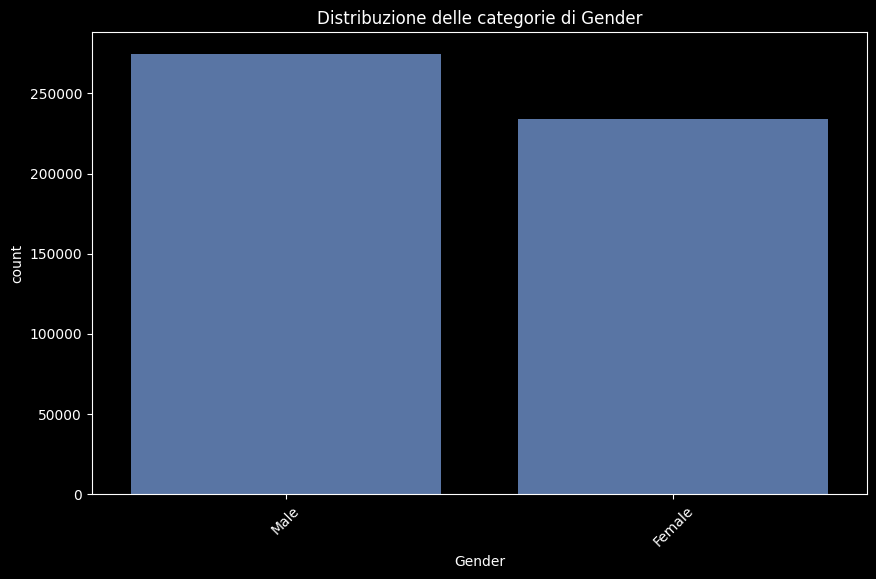

Frequenze per Region_Code:
Region_Code
NE    187733
W     143897
S      88299
MW     88217
Name: count, dtype: int64



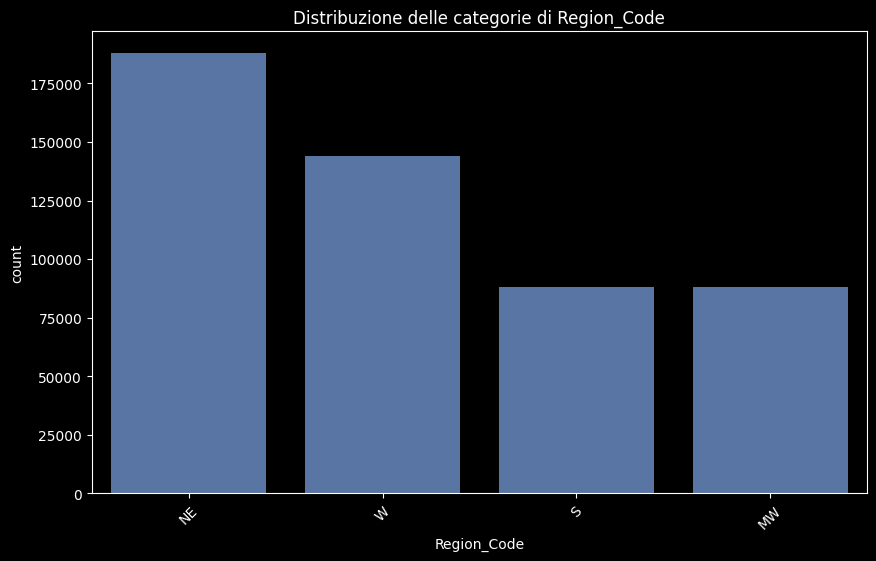

Frequenze per Location_Type:
Location_Type
Urban       236515
Suburban    145521
Rural       126110
Name: count, dtype: int64



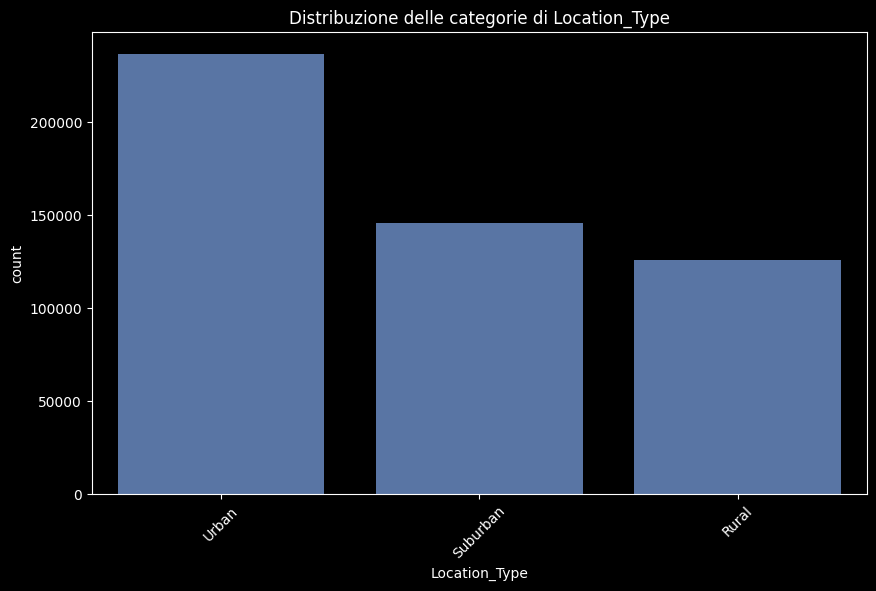

Frequenze per Education:
Education
College                 254043
Bachelors               132326
Masters                 114595
Doctor                    6174
High School or Below      1008
Name: count, dtype: int64



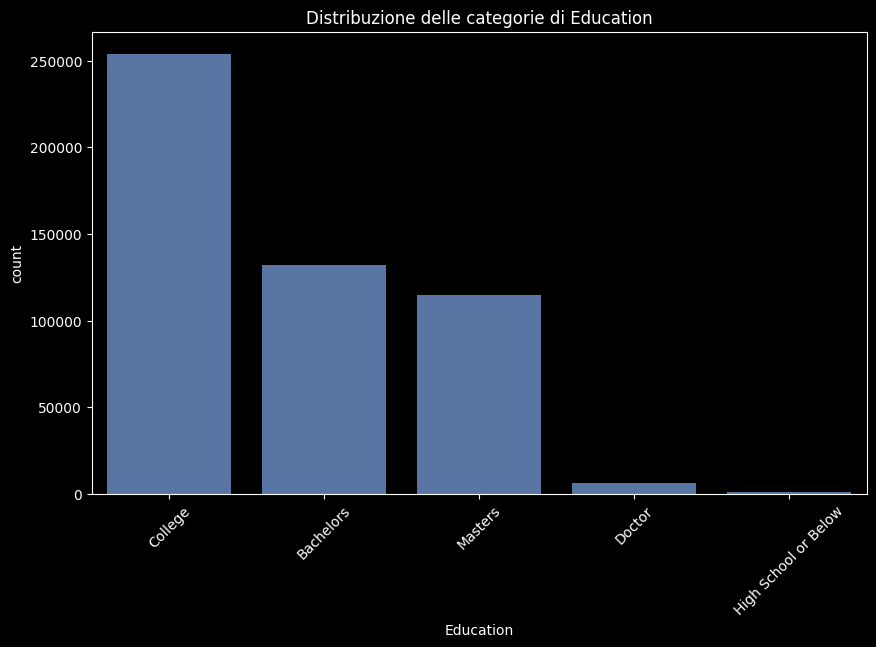

Frequenze per Vehicle_Type:
Vehicle_Type
Normal Car    237055
SUV           207023
Luxury SUV     38892
Luxury Car     25176
Name: count, dtype: int64



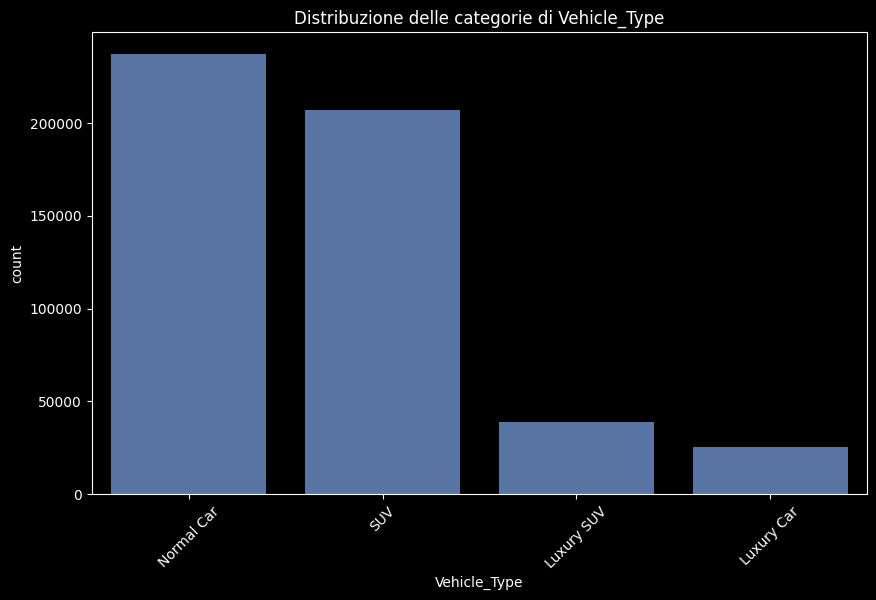

Frequenze per Previously_Insured:
Previously_Insured
No     275076
Yes    233070
Name: count, dtype: int64



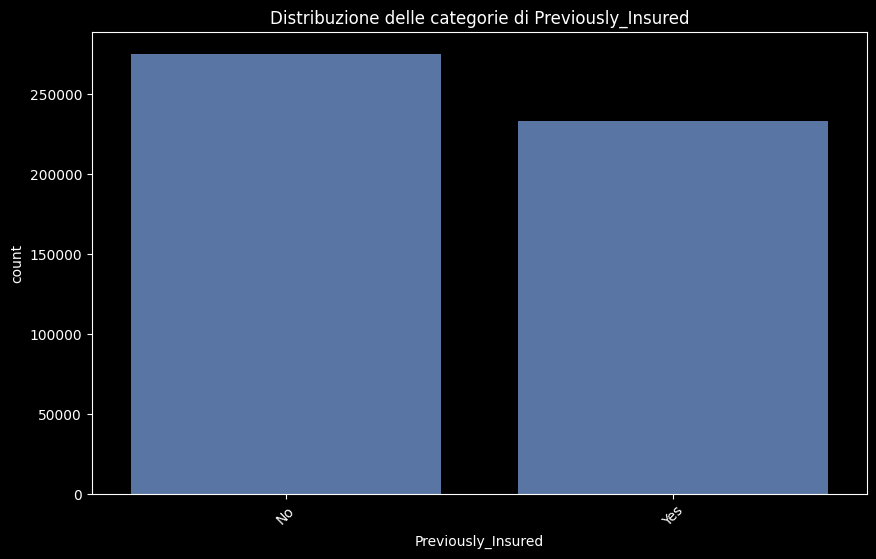

Frequenze per Vehicle_Age:
Vehicle_Age
10-20 Years    267015
< 10 Years     219805
> 20 Years      21326
Name: count, dtype: int64



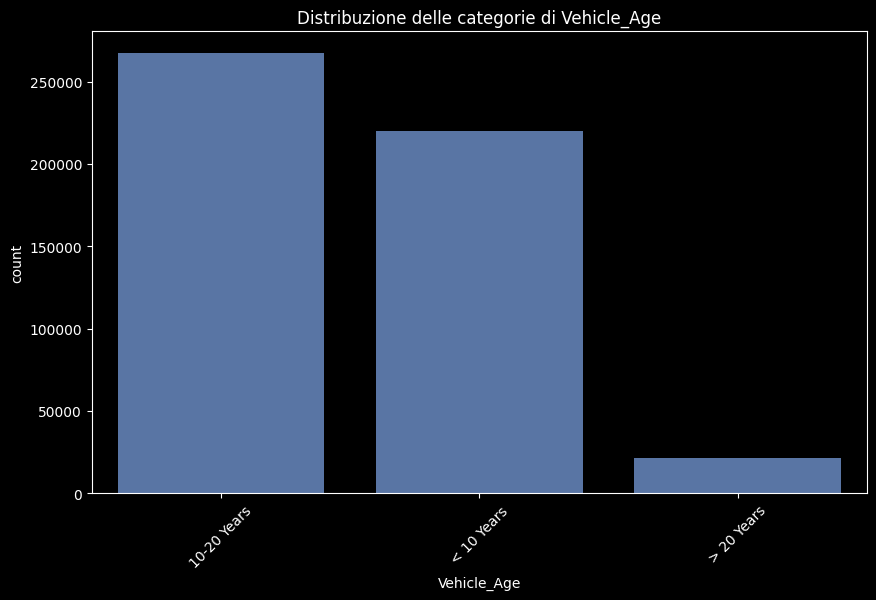

Frequenze per Vehicle_Damage:
Vehicle_Damage
Yes    256248
No     251898
Name: count, dtype: int64



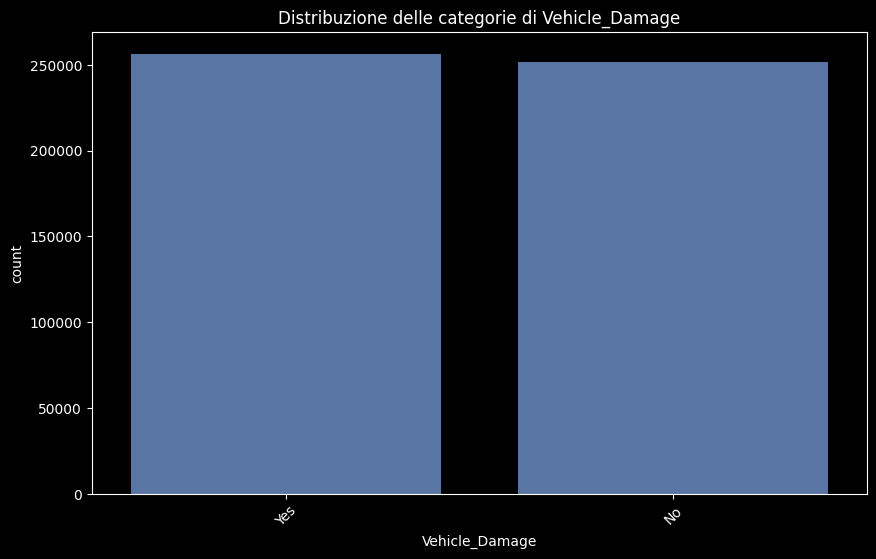

Frequenze per Policy:
Policy
Basic                94267
Silver Tier II       90590
Silver Tier I        83177
Gold Tier II         68972
Gold Tier I          62557
Platinium Tier II    54739
Platinium Tier I     53844
Name: count, dtype: int64



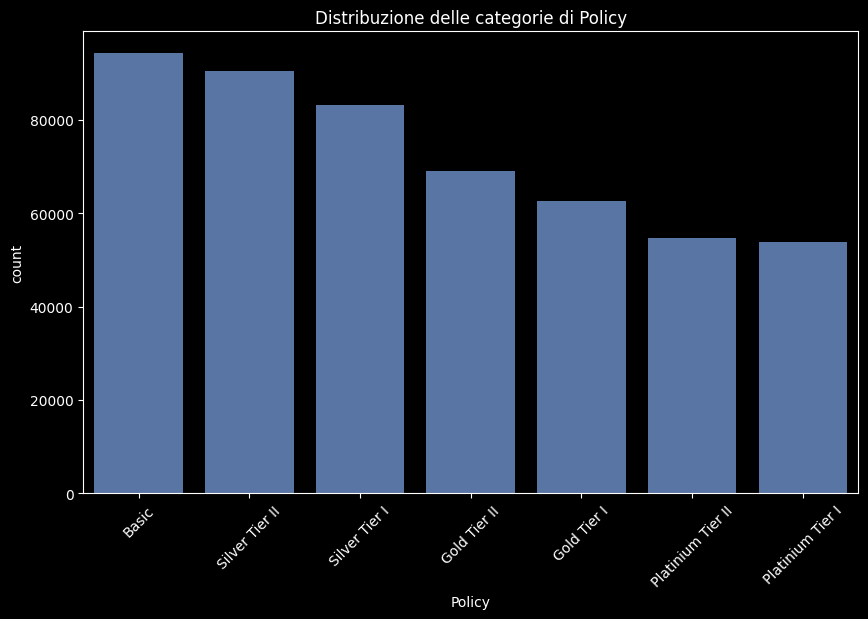

In [110]:
# Identificazione delle colonne categoriali
categorical_columns = df.select_dtypes(include=["category"]).columns # type: ignore

# Calcolo e visualizzazione della frequenza delle categorie
for column in categorical_columns:
    frequency = df[column].value_counts() # type: ignore
    print(f"Frequenze per {column}:\n{frequency}\n")

    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column, order=df[column].value_counts().index) # type: ignore
    plt.title(f"Distribuzione delle categorie di {column}")
    plt.xticks(rotation=45)
    plt.show()

In [111]:
df_cat = df[categorical_columns] # type: ignore

In [112]:
df_cat.head()

,Gender,Region_Code,Location_Type,Education,Vehicle_Type,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy
0,Male,NE,Urban,Bachelors,Normal Car,No,> 20 Years,Yes,Platinium Tier II
1,Male,S,Suburban,Bachelors,SUV,No,10-20 Years,No,Gold Tier II
2,Male,NE,Urban,Bachelors,SUV,No,> 20 Years,Yes,Gold Tier I
3,Male,S,Suburban,College,Normal Car,Yes,< 10 Years,No,Silver Tier II
4,Female,W,Rural,College,SUV,Yes,< 10 Years,No,Silver Tier II


In [113]:
# Si crea la tabella di contingenza
contingency_table = pd.crosstab(
    index=df_cat["Policy"],
    columns=[
        df_cat["Gender"],
        df_cat["Region_Code"],
        df_cat["Location_Type"],
        df_cat["Education"],
        df_cat["Vehicle_Type"],
        df_cat["Previously_Insured"],
        df_cat["Vehicle_Age"],
        df_cat["Vehicle_Damage"],
    ],
)
contingency_table

Gender                   Male                                              \
Region_Code                NE                                               
Location_Type           Urban                                               
Education              Doctor                                               
Vehicle_Type       Luxury SUV                                               
Previously_Insured         No                                     Yes       
Vehicle_Age        < 10 Years 10-20 Years      > 20 Years 10-20 Years       
Vehicle_Damage            Yes          No  Yes        Yes          No Yes   
Policy                                                                      
Platinium Tier I            6          25  267         48         160  11   
Platinium Tier II           0           4   10          1           6   1   
Gold Tier I                 0           0    0          0           0   0   
Gold Tier II                0           0    0          0           0   0   
Silver Tier I               0           0    0          0           0   0   
Silver Tier II              0           0    0          0           0   0   
Basic                       0           0    0          0           0   0   

Gender                                                     ...  \
Region_Code                                                ...   
Location_Type                                              ...   
Education                                                  ...   
Vehicle_Type       Luxury Car                              ...   
Previously_Insured         No                              ...   
Vehicle_Age        < 10 Years 10-20 Years      > 20 Years  ...   
Vehicle_Damage            Yes          No  Yes        Yes  ...   
Policy                                                     ...   
Platinium Tier I            2          13  153         32  ...   
Platinium Tier II           0           0   17          3  ...   
Gold Tier I                 0           0    0          0  ...   
Gold Tier II                0           0    0          0  ...   
Silver Tier I               0           0    0          0  ...   
Silver Tier II              0           0    0          0  ...   
Basic                       0           0    0          0  ...   

Gender                           Female                                 \
Region_Code                          MW                                  
Location_Type                     Rural                                  
Education          High School or Below                                  
Vehicle_Type                        SUV                                  
Previously_Insured                   No            Yes                   
Vehicle_Age                 10-20 Years     < 10 Years 10-20 Years       
Vehicle_Damage                       No Yes         No          No Yes   
Policy                                                                   
Platinium Tier I                      0   0          0           0   0   
Platinium Tier II                     0   1          0           0   0   
Gold Tier I                           0   2          0           1   0   
Gold Tier II                          1   6          0           4   0   
Silver Tier I                         3  13          1          13   2   
Silver Tier II                        0   2          0           2   0   
Basic                                 0   0          0           0   0   

Gender                                                         
Region_Code                                                    
Location_Type                                                  
Education                                                      
Vehicle_Type        Normal Car                                 
Previously_Insured          No                        Yes      
Vehicle_Age        10-20 Years     > 20 Years 10-20 Years      
Vehicle_Damage              No Yes        Yes          No Yes  
Policy       

La tabella di contingenza calcola la frequenza delle combinazioni di valori per le variabili specificate. Ogni cella della tabella rappresenta il numero di osservazioni che corrispondono a una specifica combinazione di valori. L'output che si è ottenuto indica le combinazioni di valori con la frequenza più alta per i sette tipi di polizza. Si può vedere che le combinazioni di valori sono presentate come tuple, con ogni elemento che rappresenta i valori delle rispettive variabili categoriche.



In [114]:
# Frequenza delle combinazioni per Policy = Basic
freq_Basic = contingency_table.loc["Basic"]
max_freq_Basic_comb = freq_Basic.idxmax()
max_freq_Basic_count = freq_Basic.max()

print("Combinazione con la frequenza più alta per Policy = Basic:")
print(max_freq_Basic_comb)
print("Frequenza:", max_freq_Basic_count)

# Frequenza delle combinazioni per Policy = Silver Tier II
freq_Silver_Tier_II = contingency_table.loc["Silver Tier II"]
max_freq_Silver_Tier_II_comb = freq_Silver_Tier_II.idxmax()
max_freq_Silver_Tier_II_count = freq_Silver_Tier_II.max()

print("Combinazione con la frequenza più alta per Policy = Silver Tier II:")
print(max_freq_Silver_Tier_II_comb)
print("Frequenza:", max_freq_Silver_Tier_II_count)

# Frequenza delle combinazioni per Policy = Silver Tier I
freq_Silver_Tier_I = contingency_table.loc["Silver Tier I"]
max_freq_Silver_Tier_I_comb = freq_Silver_Tier_I.idxmax()
max_freq_Silver_Tier_I_count = freq_Silver_Tier_I.max()

print("Combinazione con la frequenza più alta per Policy = Silver Tier I:")
print(max_freq_Silver_Tier_I_comb)
print("Frequenza:", max_freq_Silver_Tier_I_count)

# Frequenza delle combinazioni per Policy = Silver Tier II
freq_Silver_Tier_II = contingency_table.loc["Silver Tier II"]
max_freq_Silver_Tier_II_comb = freq_Silver_Tier_II.idxmax()
max_freq_Silver_Tier_II_count = freq_Silver_Tier_II.max()

print("Combinazione con la frequenza più alta per Policy = Silver Tier II:")
print(max_freq_Silver_Tier_II_comb)
print("Frequenza:", max_freq_Silver_Tier_II_count)

# Frequenza delle combinazioni per Policy = Gold Tier I
freq_Gold_Tier_I = contingency_table.loc["Gold Tier I"]
max_freq_Gold_Tier_I_comb = freq_Gold_Tier_I.idxmax()
max_freq_Gold_Tier_I_count = freq_Gold_Tier_I.max()

print("Combinazione con la frequenza più alta per Policy = Gold Tier I:")
print(max_freq_Gold_Tier_I_comb)
print("Frequenza:", max_freq_Gold_Tier_I_count)

# Frequenza delle combinazioni per Policy = Gold Tier II
freq_Gold_Tier_II = contingency_table.loc["Gold Tier II"]
max_freq_Gold_Tier_II_comb = freq_Gold_Tier_II.idxmax()
max_freq_Gold_Tier_II_count = freq_Gold_Tier_II.max()

print("Combinazione con la frequenza più alta per Policy = Gold Tier II:")
print(max_freq_Gold_Tier_II_comb)
print("Frequenza:", max_freq_Gold_Tier_II_count)

# Frequenza delle combinazioni per Policy = Platinium Tier I
freq_Platinium_Tier_I = contingency_table.loc["Platinium Tier I"]
max_freq_Platinium_Tier_I_comb = freq_Platinium_Tier_I.idxmax()
max_freq_Platinium_Tier_I_count = freq_Platinium_Tier_I.max()

print("Combinazione con la frequenza più alta per Policy = Platinium Tier I:")
print(max_freq_Platinium_Tier_I_comb)
print("Frequenza:", max_freq_Platinium_Tier_I_count)

# Frequenza delle combinazioni per Policy = Platinium Tier II
freq_Platinium_Tier_II = contingency_table.loc["Platinium Tier II"]
max_freq_Platinium_Tier_II_comb = freq_Platinium_Tier_II.idxmax()
max_freq_Platinium_Tier_II_count = freq_Platinium_Tier_II.max()

print("Combinazione con la frequenza più alta per Policy = Platinium Tier II:")
print(max_freq_Platinium_Tier_II_comb)
print("Frequenza:", max_freq_Platinium_Tier_II_count)

Combinazione con la frequenza più alta per Policy = Basic:
('Female', 'W', 'Suburban', 'College', 'Normal Car', 'Yes', '< 10 Years', 'No')
Frequenza: 1423
Combinazione con la frequenza più alta per Policy = Silver Tier II:
('Female', 'W', 'Suburban', 'College', 'Normal Car', 'Yes', '< 10 Years', 'No')
Frequenza: 2569
Combinazione con la frequenza più alta per Policy = Silver Tier I:
('Male', 'NE', 'Urban', 'Masters', 'SUV', 'No', '10-20 Years', 'Yes')
Frequenza: 2039
Combinazione con la frequenza più alta per Policy = Silver Tier II:
('Female', 'W', 'Suburban', 'College', 'Normal Car', 'Yes', '< 10 Years', 'No')
Frequenza: 2569
Combinazione con la frequenza più alta per Policy = Gold Tier I:
('Female', 'W', 'Suburban', 'College', 'SUV', 'Yes', '< 10 Years', 'No')
Frequenza: 1472
Combinazione con la frequenza più alta per Policy = Gold Tier II:
('Female', 'W', 'Suburban', 'College', 'SUV', 'Yes', '< 10 Years', 'No')
Frequenza: 1722
Combinazione con la frequenza più alta per Policy = Pla

Dall'osservazione delle tuple si possono trarre alcune osservazioni interessanti riguardo alle combinazioni di caratteristiche associate alle diverse polizze assicurative e alla frequenza con cui queste combinazioni si verificano. Ecco alcune considerazioni:

1. Pattern di distribuzione comune per alcune policy
  - Silver Tier II: La combinazione con la frequenza più alta è la stessa della policy Basic: 'Female', 'W', 'Suburban', 'College', 'Normal Car', 'Yes', '< 10 Years', 'No'. Questo potrebbe indicare che clienti con queste caratteristiche tendono a optare per policy assicurative di livello base o leggermente superiori.
  - Gold Tier I e Gold Tier II: Entrambe le policy hanno una combinazione molto simile: 'Female', 'W', 'Suburban', 'College', 'SUV', 'Yes', '< 10 Years', 'No', suggerendo che chi ha un profilo più istruito e con un veicolo SUV tende a scegliere policy di fascia "Gold".
2. Differenze di genere e locazione
  - Silver Tier I: Qui la combinazione più frequente è associata a uomini, con un background educativo più elevato (Masters) e preferenza per veicoli SUV. Questo può suggerire che gli uomini con una maggiore istruzione tendono a preferire policy di fascia Silver (I), con preferenza per veicoli di tipo SUV.
  - Platinium Tier I e II: Notiamo una distinzione interessante tra la Platinium Tier I, dove la combinazione più frequente è 'Male', 'NE', 'Urban', 'Bachelors', 'Luxury SUV', 'No', '10-20 Years', 'Yes', e la Platinium Tier II, dove invece sono presenti più donne con una combinazione simile ma con veicoli SUV standard e un background leggermente diverso in termini di genere e residenza. Questo potrebbe indicare che uomini con maggiore esperienza e veicoli di lusso tendono a scegliere le policy di livello più alto (Tier I).
3. Preferenza per veicoli e durata dell'uso
  - Veicoli normali vs SUV: Nelle policy di livello Silver e Gold, i clienti con veicoli SUV (sia normali che di lusso) sono presenti con più frequenza rispetto a quelli con veicoli normali (come per la policy Basic e Silver II). Questo suggerisce che chi guida SUV tende a scegliere coperture assicurative più avanzate.
  - Durata di utilizzo del veicolo: Le durate "10-20 Years" e "< 10 Years" compaiono ripetutamente nelle combinazioni più frequenti. Tuttavia, si nota che chi ha veicoli con esperienza maggiore (10-20 anni) tende a preferire policy più alte, come Silver Tier I e Platinium Tier I e II.
4. Distinzione socio-demografica tra policy
  - Clienti con istruzione superiore (Masters, Bachelors, College) tendono a essere i più frequenti nelle combinazioni riportate, suggerendo che il livello di istruzione potrebbe essere un fattore importante nella scelta della policy.
  - La suddivisione in aree urbane e suburbane offre una chiara distinzione: le aree suburbane dominano nei livelli medio-bassi (Basic, Silver, Gold), mentre le aree urbane appaiono nelle policy di livello più alto (Platinium), forse riflettendo una maggiore complessità e rischio percepito nella guida urbana.

Le diverse polizze sembrano attrarre segmenti di clienti distinti per genere, tipo di veicolo, livello di istruzione, e durata dell'uso del veicolo. Le policy di livello più alto sono spesso associate a veicoli più costosi (SUV di lusso), clienti con maggiore istruzione e un'esperienza di guida più lunga, mentre policy di livello più basso sono scelte più frequentemente da persone con veicoli normali e una durata di possesso inferiore.

#### Test Chi-quadro

In [115]:
from scipy.stats import chi2_contingency

# Lista delle variabili esplicative categoriche
variabili_esplicative = [
    "Gender",
    "Region_Code",
    "Location_Type",
    "Education",
    "Vehicle_Type",
    "Previously_Insured",
    "Vehicle_Age",
    "Vehicle_Damage",
]

# Lista delle variabili esplicative significative
variabili_significative = []

# Calcolo del test del chi-quadro per ogni variabile esplicativa
for variabile in variabili_esplicative:
    contingency_table = pd.crosstab(index=df_cat["Policy"], columns=df_cat[variabile])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)

    # Controllo del valore di p del test del chi-quadro
    if p_value < 0.05:  # type: ignore # Impostare il livello di significatività desiderato
        variabili_significative.append(variabile)

# Output delle variabili esplicative significative
if len(variabili_significative) > 0:
    print("Le seguenti variabili esplicative categoriche risultano significative:")
    for variabile in variabili_significative:
        print(variabile)
else:
    print("Nessuna variabile esplicativa categorica risulta significativa.")

Le seguenti variabili esplicative categoriche risultano significative:
Gender
Region_Code
Location_Type
Education
Vehicle_Type
Previously_Insured
Vehicle_Age
Vehicle_Damage


Tutte le variabili categoriali del dataframe risultano significative per il test chi-quadro, sia con alpha = 0.05 che al 0.01

## Matrice di Correlazione

Dall'analisi bivariata e dalle osservazioni della tabella di contigenza si ha che le diverse polizze sembrano attrarre segmenti di clienti distinti per *genere*, *tipo di veicolo*, *livello di istruzione*, e *durata dell'uso del veicolo*. Le policy di livello più alto sono spesso associate a veicoli più costosi (SUV di lusso), clienti con maggiore istruzione e un'esperienza di guida più lunga, mentre policy di livello più basso sono scelte più frequentemente da persone con veicoli normali e una durata di possesso inferiore.

### Codifica delle variabili categoriali

Le variabili categoriali mostrate in precedenza devono essere trasformate in una rappresentazione numerica per poter essere utilizzate nella maggior parte degli algoritmi di machine learning, in quanto questi ultimi non sono in grado di gestire direttamente variabili categoriali sotto forma di stringhe o etichette testuali. Gli algoritmi di regressione, classificazione o clustering, come la regressione lineare, le reti neurali, gli alberi decisionali e molti altri, richiedono input numerici. Pertanto, è fondamentale convertire le variabili categoriali in numeri senza perdere il loro significato.

Esistono diverse tecniche per codificare queste variabili, tra cui:

Tecniche di Codifica
- Ordinal Encoding:
    Questa tecnica è utilizzata per variabili ordinarie, dove esiste un ordine naturale tra le categorie. Ad esempio, se hai una variabile che rappresenta livelli di istruzione (es. "Diploma", "Laurea", "Master"), puoi assegnare valori numerici progressivi come 1, 2 e 3. Questo metodo mantiene l'ordine delle categorie in modo semplice e crea una sola colonna.

- Label Encoding:
    Si utilizza principalmente per convertire le variabili categoriali in numeri interi, senza introdurre un ordine specifico tra le categorie. Ogni categoria viene mappata su un numero intero arbitrario e non assume che ci sia un ordine naturale tra i valori

- One-Hot Encoding:
    Utilizzata principalmente per variabili nominali, questa tecnica crea una nuova colonna per ogni categoria presente nella variabile. Ogni colonna avrà un valore di 1 se la riga appartiene a quella categoria e 0 altrimenti. Ad esempio, per una variabile con categorie "Rosso", "Verde" e "Blu", verranno create tre colonne, ciascuna rappresentante una categoria. Sebbene sia molto efficace, può aumentare significativamente il numero di colonne nel dataset, specialmente con molte categorie.

La codifica delle variabili categoriali è un passaggio essenziale nella pre-elaborazione dei dati per il machine learning. La scelta del metodo di codifica dipende dalla natura del dataset, dall'algoritmo che si intende utilizzare e dalle prestazioni che si desidera ottenere. Questo processo sarà fondamentale per migliorare l'efficacia dei modelli che verranno implementati successivamente.

In [116]:
# Si crea copia del dataframe originale dove tutte le variabili verranno trasformate in rappresentazione numerica
df_cod = df.copy() # type: ignore

In [117]:
# Ordinal Encoding

df_cod["Education"] = ( # type: ignore
    df_cod["Education"] # type: ignore
    .replace(
        {
            "High School or Below": 1,
            "College": 2,
            "Bachelors": 3,
            "Masters": 4,
            "Doctor": 5,
        }
    )
    .astype("int64")
)

df_cod["Vehicle_Age"] = ( # type: ignore
    df_cod["Vehicle_Age"] # type: ignore
    .replace(
        {
            "< 10 Years": 1,
            "10-20 Years": 2,
            "> 20 Years": 3,
        }
    )
    .astype("int64")
)

df_cod["Policy"] = ( # type: ignore
    df_cod["Policy"] # type: ignore
    .replace(
        {
            "Basic": 0,
            "Silver Tier II": 1,
            "Silver Tier I": 2,
            "Gold Tier II": 3,
            "Gold Tier I": 4,
            "Platinium Tier II": 5,
            "Platinium Tier I": 6,
        }
    )
    .astype("int64")
)

In [118]:
# Label Encoding

df_cod["Gender"] = df_cod["Gender"].replace({"Female": 0, "Male": 1}).astype("int64") # type: ignore
# Si rinomina il genere in Gender_Male per una lettura più chiara.
df_cod = df_cod.rename(columns={'Gender': 'Gender_Male'})

df_cod["Vehicle_Damage"] = ( # type: ignore
    df_cod["Vehicle_Damage"].replace({"No": 0, "Yes": 1}).astype("int64") # type: ignore
)

df_cod["Previously_Insured"] = df_cod["Previously_Insured"].replace({"No": 0, "Yes": 1}).astype("int64") # type: ignore


In [119]:
# One-Hot Encoding
# Creazione di variabili fittizie per alcune delle variabili categoriche 
# (al momento si mantengono tutte le colonne impostando drop_first=False; in seguito per evitare duplicazione di informazioni si può pensare di eliminare la prima colonna)

dummy1 = pd.get_dummies(df_cod[['Region_Code', 'Location_Type', 'Vehicle_Type']], drop_first=False).astype(int) # type: ignore

# Si aggiungono i risultati al dataframe
df_cod_dummy = pd.concat([df_cod, dummy1], axis=1)

# Avendo creato le variabili dummy si possono rimuovere dal dataframe le seguenti colonne
df_cod_dummy = df_cod_dummy.drop(['Region_Code', 'Location_Type', 'Vehicle_Type','id'], axis=1)

### Standardadizzazione

In [120]:
# Si selezionano le colonne da standardizzare
columns_to_standardize = ['Age', 'Annual_Income']

# Si crea un oggetto StandardScaler
scaler = StandardScaler()

df_std = df_cod_dummy.copy()

# Si crea la standardizzazione solo alle colonne selezionate
df_std[columns_to_standardize] = scaler.fit_transform(df_cod_dummy[columns_to_standardize])

### Matrice di correlazione

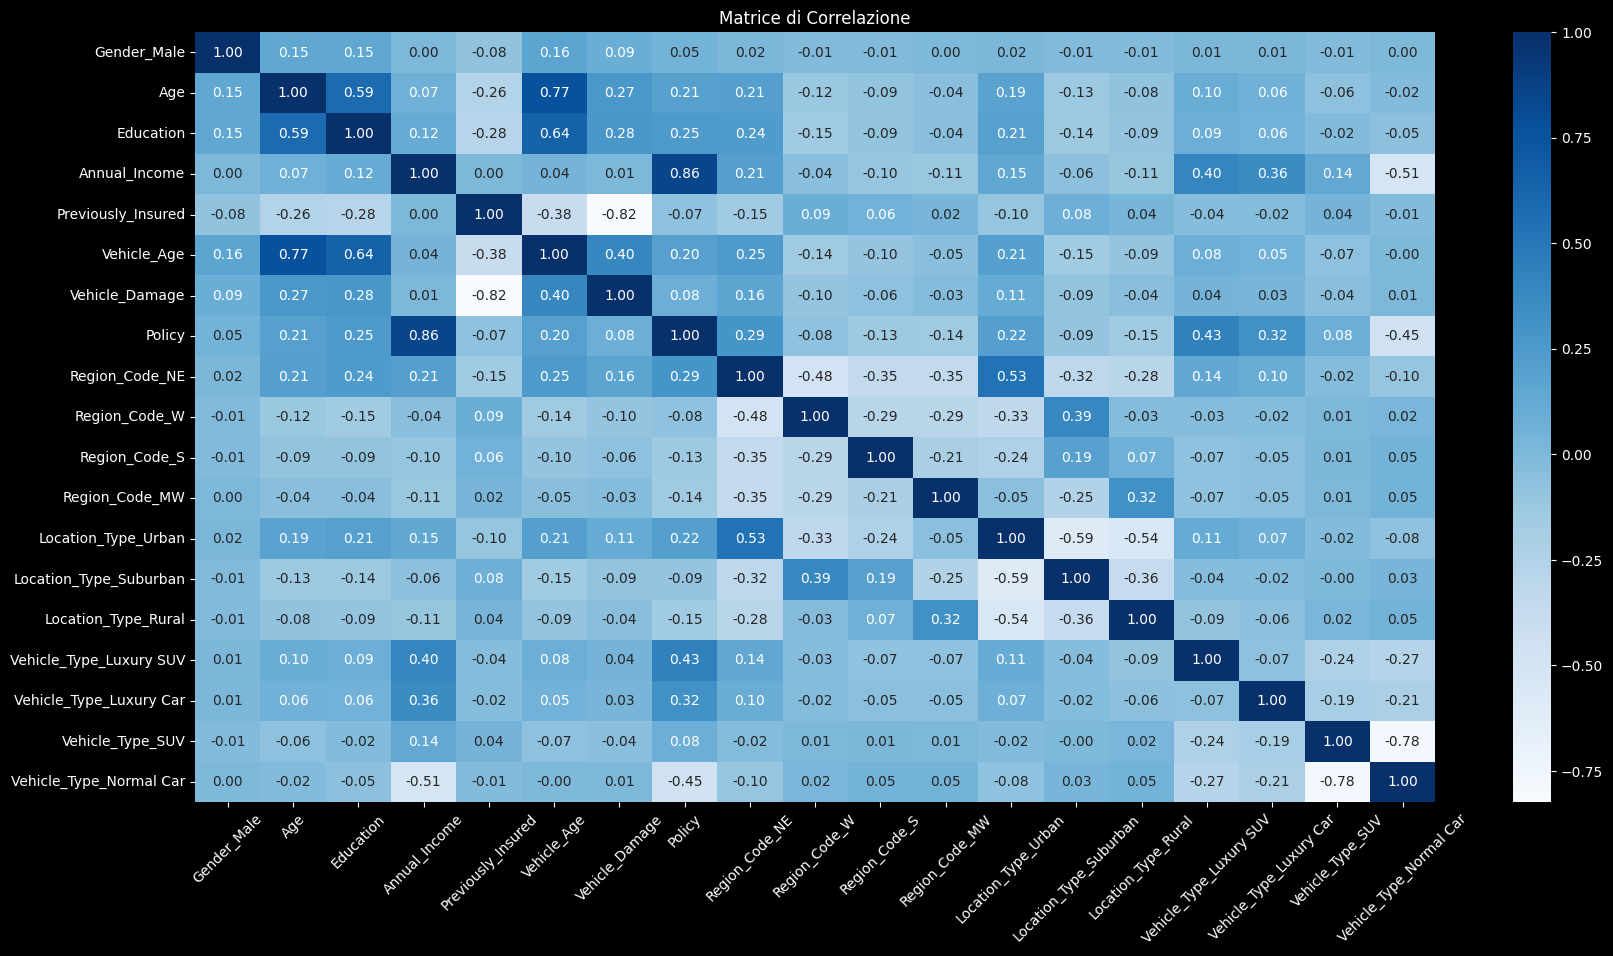

In [121]:
# Heatmap della matrice di correlazione
plt.figure(figsize=(20, 10))
sns.heatmap(df_std.corr(), annot=True, cmap="Blues", fmt=".2f")
plt.xticks(rotation=45, fontsize=10, ha="center")
plt.yticks(rotation=0, fontsize=10)
plt.title("Matrice di Correlazione")
plt.show()

La matrice di correlazione mostra i coefficienti di correlazione di Pearson tra diverse variabili, ciascuna delle quali è rappresentata sia sull'asse orizzontale che su quello verticale. I valori nella matrice variano tra -1 e 1, dove:

 - 1 indica una correlazione positiva perfetta (quando una variabile aumenta, anche l'altra aumenta in proporzione diretta).
 - -1 indica una correlazione negativa perfetta (quando una variabile aumenta, l'altra diminuisce in proporzione inversa).
 - 0 indica l'assenza di correlazione (le due variabili non mostrano alcuna relazione lineare).

Esaminando la matrice di correlazione, si possono trarre alcune conclusioni preliminari sulle relazioni tra le variabili rispetto alla variabile target **Policy**.

Ecco un'analisi variabile per variabile rispetto a **Policy**:

1. **Gender_Male**: La correlazione con la variabile target **Policy** è bassa (0.05). Questo suggerisce che il genere non ha un impatto rilevante sulla scelta della polizza. Ciò significa **che uomini e donne tendono a scegliere polizze simili**.

2. **Age**: La correlazione con **Policy** è moderata (0.22). Questo indica che l'età è un fattore che potrebbe influenzare la scelta della polizza. **I clienti più giovani o più anziani potrebbero avere preferenze diverse in termini di polizza rispetto ad altre fasce di età**.

3. **Education**: La correlazione è moderata (0.25), suggerendo che il livello di istruzione ha una certa influenza nella scelta della polizza. **Clienti con livelli di istruzione più elevati potrebbero optare per polizze più complesse o premium**.

4. **Annual_Income**: C'è una correlazione alta (0.86) con la variabile **Policy**. Questo suggerisce che il reddito annuo è il fattore più influente nella scelta della polizza, il che è ragionevole poiché **chi guadagna di più tende a scegliere polizze più premium**.

5. **Previously_Insured**: La correlazione con **Policy** è molto bassa (-0.07), indicando che **il fatto di aver avuto una precedente assicurazione non influisce significativamente sulla scelta della polizza**.

6. **Vehicle_Age**: La correlazione è moderata (0.20), suggerendo che l'età del veicolo ha un impatto sulla scelta della polizza. **Veicoli più nuovi potrebbero richiedere polizze più elevate o con maggiore copertura**.

7. **Vehicle_Damage**: La correlazione è bassa (0.08), indicando che **i danni precedenti del veicolo non sono particolarmente rilevanti nella scelta della polizza**.

8. **Region_Code_NE, Region_Code_W, Region_Code_S, Region_Code_MW**: Le regioni mostrano correlazioni deboli con la variabile **Policy**. Ad esempio, **Region_Code_NE** ha una correlazione di 0.29, mentre **Region_Code_S** ha una correlazione di -0.13. Questo suggerisce che **le aree geografiche non sono tra i principali driver nella scelta della polizza**.

9. **Location_Type_Urban, Location_Type_Suburban, Location_Type_Rural**: Queste variabili presentano una correlazione relativamente bassa con **Policy**. La **Location_Type_Urban** ha una correlazione di 0.32, suggerendo che i **clienti urbani potrebbero scegliere polizze diverse rispetto a quelli rurali (-0.15)**, ma l'effetto rimane moderato.

10. **Vehicle_Type_Luxury SUV**: La correlazione è moderata (0.43), il che indica che **chi possiede un SUV di lusso tende a scegliere polizze più elevate o premium**, come ci si potrebbe aspettare.

11. **Vehicle_Type_Luxury Car**: Anche in questo caso la correlazione è abbastanza significativa (0.32), il che suggerisce che **chi possiede un'auto di lusso è incline a scegliere polizze più costose**.

12. **Vehicle_Type_SUV**: La correlazione è bassa (0.08), indicando che **la proprietà di un SUV normale non ha un grande impatto sulla scelta della polizza**.

13. **Vehicle_Type_Normal Car**: C'è una correlazione negativa (-0.45), il che suggerisce che chi **possiede una macchina normale tende a scegliere polizze più basse rispetto a quelle per veicoli di lusso o SUV**.

Le variabili con la correlazione più alta con **Policy** sono **Annual_Income** (0.86) e **Vehicle_Type_Luxury SUV** (0.43). Queste due variabili sono forti predittori del tipo di polizza.

Altre variabili come **Age**, **Education**, e **Location_Type_Urban** mostrano una correlazione moderata e possono contribuire alla previsione della polizza, anche se con minore impatto rispetto al reddito.

Variabili come **Gender_Male**, **Previously_Insured**, e alcune variabili geografiche (come **Region_Code** o **Location_Type_Rural**) hanno correlazioni molto basse con la variabile target e potrebbero avere un impatto minimo sul modello.

# Prima selezione dei modelli

## Preparazione training e validation set

Il DataFrame originale viene diviso in training (80%) e test set (20%); quest'ultimo verrà usato solo alla fine per testare il modello finale.

Il training ed il test set vengono poi trasformati in DataFrame categoriale e DataFrame standardizzato (e codificato).
Questo permetterà di testare i modelli basati su dataframe standardizzati ed i modelli basati su dataframe categoriali con le stesse osservazioni.

In [122]:
from sklearn.model_selection import train_test_split

In [123]:
# Si divide il DataFrame in training e test set
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

### df_cat_train e df_cat_test

In [124]:
# Identificazione delle colonne categoriali
categorical_columns_train = train_df.select_dtypes(include=["category"]).columns
categorical_columns_test = test_df.select_dtypes(include=["category"]).columns

In [125]:
df_cat_train = train_df[categorical_columns_train]
df_cat_test = test_df[categorical_columns_test]

### df_std_train e df_std_test

In [126]:
df_cod_train = train_df.copy()
df_cod_test = test_df.copy()

#### Ordinal Encoding

In [127]:
# Ordinal Encoding

df_cod_train["Education"] = ( # type: ignore
    df_cod_train["Education"] # type: ignore
    .replace(
        {
            "High School or Below": 1,
            "College": 2,
            "Bachelors": 3,
            "Masters": 4,
            "Doctor": 5,
        }
    )
    .astype("int64")
)

df_cod_train["Vehicle_Age"] = ( # type: ignore
    df_cod_train["Vehicle_Age"] # type: ignore
    .replace(
        {
            "< 10 Years": 1,
            "10-20 Years": 2,
            "> 20 Years": 3,
        }
    )
    .astype("int64")
)

df_cod_train["Policy"] = ( # type: ignore
    df_cod_train["Policy"] # type: ignore
    .replace(
        {
            "Basic": 0,
            "Silver Tier II": 1,
            "Silver Tier I": 2,
            "Gold Tier II": 3,
            "Gold Tier I": 4,
            "Platinium Tier II": 5,
            "Platinium Tier I": 6,
        }
    )
    .astype("int64")
)

In [128]:
# Ordinal Encoding

df_cod_test["Education"] = ( # type: ignore
    df_cod_test["Education"] # type: ignore
    .replace(
        {
            "High School or Below": 1,
            "College": 2,
            "Bachelors": 3,
            "Masters": 4,
            "Doctor": 5,
        }
    )
    .astype("int64")
)

df_cod_test["Vehicle_Age"] = ( # type: ignore
    df_cod_test["Vehicle_Age"] # type: ignore
    .replace(
        {
            "< 10 Years": 1,
            "10-20 Years": 2,
            "> 20 Years": 3,
        }
    )
    .astype("int64")
)

df_cod_test["Policy"] = ( # type: ignore
    df_cod_test["Policy"] # type: ignore
    .replace(
        {
            "Basic": 1,
            "Silver Tier II": 2,
            "Silver Tier I": 3,
            "Gold Tier II": 4,
            "Gold Tier I": 5,
            "Platinium Tier II": 6,
            "Platinium Tier I": 7,
        }
    )
    .astype("int64")
)

#### Label Encoding

In [129]:
# Label Encoding

df_cod_train["Gender"] = df_cod_train["Gender"].replace({"Female": 0, "Male": 1}).astype("int64") # type: ignore
# Si rinomina il genere in Gender_Male per una lettura più chiara.
df_cod_train = df_cod_train.rename(columns={'Gender': 'Gender_Male'})

df_cod_train["Vehicle_Damage"] = ( # type: ignore
    df_cod_train["Vehicle_Damage"].replace({"No": 0, "Yes": 1}).astype("int64") # type: ignore
)

df_cod_train["Previously_Insured"] = df_cod_train["Previously_Insured"].replace({"No": 0, "Yes": 1}).astype("int64") # type: ignore

In [130]:
# Label Encoding

df_cod_test["Gender"] = df_cod_test["Gender"].replace({"Female": 0, "Male": 1}).astype("int64") # type: ignore
# Si rinomina il genere in Gender_Male per una lettura più chiara.
df_cod_test = df_cod_test.rename(columns={'Gender': 'Gender_Male'})

df_cod_test["Vehicle_Damage"] = ( # type: ignore
    df_cod_test["Vehicle_Damage"].replace({"No": 0, "Yes": 1}).astype("int64") # type: ignore
)

df_cod_test["Previously_Insured"] = df_cod_test["Previously_Insured"].replace({"No": 0, "Yes": 1}).astype("int64") # type: ignore

#### One-Hot Encoding

In [131]:
# One-Hot Encoding
# Creazione di variabili fittizie per alcune delle variabili categoriche 
# (al momento si mantengono tutte le colonne impostando drop_first=False; in seguito per evitare duplicazione di informazioni si può pensare di eliminare la prima colonna)

dummy1 = pd.get_dummies(df_cod_train[['Region_Code', 'Location_Type', 'Vehicle_Type']], drop_first=False).astype(int) # type: ignore

# Si aggiungono i risultati al dataframe
df_cod_train_dummy = pd.concat([df_cod_train, dummy1], axis=1)

# Avendo creato le variabili dummy si possono rimuovere dal dataframe le seguenti colonne
df_cod_train_dummy = df_cod_train_dummy.drop(['Region_Code', 'Location_Type', 'Vehicle_Type','id'], axis=1)

In [132]:
# One-Hot Encoding
# Creazione di variabili fittizie per alcune delle variabili categoriche 
# (al momento si mantengono tutte le colonne impostando drop_first=False; in seguito per evitare duplicazione di informazioni si può pensare di eliminare la prima colonna)

dummy2 = pd.get_dummies(df_cod_test[['Region_Code', 'Location_Type', 'Vehicle_Type']], drop_first=False).astype(int) # type: ignore

# Si aggiungono i risultati al dataframe
df_cod_test_dummy = pd.concat([df_cod_test, dummy2], axis=1)

# Avendo creato le variabili dummy si possono rimuovere dal dataframe le seguenti colonne
df_cod_test_dummy = df_cod_test_dummy.drop(['Region_Code', 'Location_Type', 'Vehicle_Type','id'], axis=1)

#### Standardizzazione

In [133]:
# Si selezionano le colonne da standardizzare
columns_to_standardize = ['Age', 'Annual_Income']

# Si crea un oggetto StandardScaler
scaler = StandardScaler()

df_std_train = df_cod_train_dummy.copy()

# Si crea la standardizzazione solo alle colonne selezionate
df_std_train[columns_to_standardize] = scaler.fit_transform(df_cod_train_dummy[columns_to_standardize])

In [134]:
# Si selezionano le colonne da standardizzare
columns_to_standardize = ['Age', 'Annual_Income']

# Si crea un oggetto StandardScaler
scaler = StandardScaler()

df_std_test = df_cod_test_dummy.copy()

# Si crea la standardizzazione solo alle colonne selezionate
df_std_test[columns_to_standardize] = scaler.fit_transform(df_cod_test_dummy[columns_to_standardize])

### K-Fold Cross Validation su df_std_train

In [135]:
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

In [136]:
# Inizializzare la colonna 'kfold' con NaN
df_std_train['kfold'] = np.nan

# Shuffle del DataFrame
df_std_train_k = df_std_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Assegnare i fold
n_splits = 10
rows_per_fold = 406516 // n_splits

for fold in range(n_splits):
    start_index = fold * rows_per_fold
    if fold == n_splits - 1:  # Assicurarsi che l'ultimo fold prenda le righe rimanenti
        end_index = 406516
    else:
        end_index = start_index + rows_per_fold
    
    df_std_train_k.loc[start_index:end_index, 'kfold'] = fold

In [137]:
df_std_train_k.columns = df_std_train_k.columns.str.replace(' ', '_')

In [138]:
# Funzione train_test_split_by_fold

def train_test_split_by_fold(df_std_train_k, fold, target_column):
    X = df_std_train_k.drop(['Policy'], axis=1)
    y = df_std_train_k[target_column]

# Codificare le etichette da 0 a 6
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)

# Aggiungere la colonna 'kfold' se non è già presente
    if 'kfold' not in X.columns:
        raise ValueError("La colonna 'kfold' deve essere presente nel DataFrame.")

    X_train = X.loc[X['kfold'] != fold].drop('kfold', axis=1)
    X_valid = X.loc[X['kfold'] == fold].drop('kfold', axis=1)
    y_train = y_encoded[X['kfold'] != fold] # type: ignore
    y_valid = y_encoded[X['kfold'] == fold] # type: ignore
    
    return X_train, X_valid, y_train, y_valid

In [139]:
X_train, X_valid, y_train, y_valid = train_test_split_by_fold(df_std_train_k,fold=0,target_column='Policy')

Quando si parla di ottenere il set di addestramento e il set di validazione per il primo fold (0) in un contesto di **k-fold cross-validation**, si fa riferimento a un metodo per valutare le prestazioni di un modello di machine learning. Ecco una spiegazione dettagliata di cosa significa, passo dopo passo:

#### 1. Cos'è la Cross-Validation K-Fold?

La **cross-validation k-fold** è una tecnica utilizzata per valutare la capacità di generalizzazione di un modello. Consiste nel suddividere il dataset in k sottoinsiemi (o "fold") di dimensioni approssimativamente uguali. Il processo prevede che il modello venga addestrato e testato su diverse combinazioni di questi fold.

#### 2. Suddivisione del Dataset

- **Suddivisione in Fold**: 
  - Se si ha, ad esempio, un dataset con 100 campioni e si decide di utilizzare k = 5, il dataset verrà diviso in 5 fold, ciascuno contenente circa 20 campioni.
  
#### 3. Addestramento e Validazione

- **Primo Fold come Set di Validazione**:
  - Quando si fa riferimento al "primo fold (0)", significa che il primo dei 5 fold (o l'indice 0) viene utilizzato come set di validazione. Questo fold è escluso dal set di addestramento durante questa iterazione.
  
- **Fold Rimanenti come Set di Addestramento**:
  - I restanti k-1 fold (in questo caso, i rimanenti 4) vengono utilizzati per addestrare il modello. Quindi, per la prima iterazione:
    - **Set di Addestramento**: Fold 1, Fold 2, Fold 3, Fold 4
    - **Set di Validazione**: Fold 0

#### 4. Ripetizione del Processo

- **Iterazioni Multiple**:
  - Questo processo viene ripetuto k volte. In ogni iterazione, un fold diverso viene utilizzato come set di validazione mentre gli altri vengono utilizzati per l'addestramento.
    - **Iterazione 1**: Fold 0 come validazione
    - **Iterazione 2**: Fold 1 come validazione
    - **Iterazione 3**: Fold 2 come validazione
    - **Iterazione 4**: Fold 3 come validazione
    - **Iterazione 5**: Fold 4 come validazione

#### 5. Valutazione delle Prestazioni

- **Calcolo delle Metriche**:
  - Dopo ogni iterazione, le prestazioni del modello vengono valutate sul set di validazione. Le metriche (come accuratezza, precisione, richiamo) vengono registrate.
  
- **Media delle Prestazioni**:
  - Alla fine delle k iterazioni, si calcola una media delle metriche ottenute per fornire una stima complessiva delle prestazioni del modello.

#### Vantaggi della Cross-Validation K-Fold

- **Utilizzo Efficiente dei Dati**: Ogni campione viene utilizzato sia per l'addestramento che per la validazione, migliorando l'uso complessivo dei dati disponibili.
  
- **Stima Affidabile delle Prestazioni**: Fornisce una valutazione più robusta delle prestazioni del modello rispetto a una singola divisione train/test.

ottenere il set di addestramento e il set di validazione per il primo fold (0) significa che durante la prima iterazione della cross-validation k-fold, il primo sottoinsieme del dataset viene utilizzato per testare le prestazioni del modello mentre gli altri sottoinsiemi vengono utilizzati per addestrarlo. Questo approccio permette una valutazione accurata e robusta delle capacità predittive del modello su dati non visti.

Citations:
[1] https://datatrading.info/la-cross-validation-per-ottimizzare-il-machine-learning/
[2] https://www.diariodiunanalista.it/posts/cosa-e-la-cross-validazione-nel-machine-learning/
[3] https://codelabsacademy.com/it/blog/k-fold-cross-validation-in-machine-learning
[4] https://it.milliman.com/it-IT/insight/validazione-efficace-dei-modelli-di-machine-learning
[5] https://www.diariodiunanalista.it/posts/come-partizionare-i-dati-di-training-in-k-fold/
[6] https://deeplearningitalia.com/parliamo-di-split-utilizzati-per-dividere-il-dataset-in-training-validation-e-test-nel-machine-learning/
[7] https://docs.ultralytics.com/it/guides/kfold-cross-validation/
[8] https://www.diariodiunanalista.it/posts/guida-alla-gestione-delle-variabili-categoriali/

## Primo addestramento dei modelli

In [140]:
# Model selection
classifiers = [
    ('Linear SVM', LinearSVC(random_state=42, tol=1e-5)),
    ('Nearest Neighbors', KNeighborsClassifier(3)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, max_depth=5)),
    ('Random Forest', RandomForestClassifier(random_state=42, max_depth=5, n_estimators=10, max_features=1)),
    ('Neural Net', MLPClassifier(random_state=42, alpha=1, max_iter=1000)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('GBM Classifier', GradientBoostingClassifier(random_state=42)),
    ('LightGBM', LGBMClassifier(random_state=42, max_depth=5, n_estimators=10, learning_rate=0.1, force_col_wise=True)),
    ('CatBoost', CatBoostClassifier(random_state=42, depth=5, iterations=100, learning_rate=0.1, verbose=0))
]

```python
performance = []
for name, clf in classifiers:
    if name == 'LightGBM':
        clf.set_params(verbose=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    perf_tuple = (name, f1_score(y_valid, y_pred, average='weighted'))
    print(perf_tuple)
    performance.append(perf_tuple)
```

Output:

- ('Linear SVM', 0.5141994010896659)
- ('Nearest Neighbors', 0.9140834886323317)
- ('Decision Tree', 0.8393363939651776)
- ('Random Forest', 0.43786032746099907)
- ('Neural Net', 0.7945968195440117)
- ('AdaBoost', 0.33151251568983514)
- ('Naive Bayes', 0.49616079810811436)
- ('QDA', 0.05674166178567169)
- ('XGBoost', 0.9931620081183526)
- ('GBM Classifier', 0.9839192283946616)
- ('LightGBM', 0.9641446714873191)
- ('CatBoost', 0.9726823697398702)

L'output del codice fornisce informazioni sulla performance dei modelli di classificazione misurata tramite la metrica F1-score con media ponderata (weighted) sul dataset di validazione.

Spiegazione dettagliata del codice:

1. train_test_split_by_fold():
    - Funzione personalizzata che divide i dati in un insieme di addestramento (X_train, y_train) e uno di validazione (X_valid, y_valid) in base a un indice di fold, utile ad esempio nella cross-validation a k-fold.
    - df_cp1 è il dataset e 'Policy' è la variabile target, ossia la colonna che si vuole predire (ossia predire il tipo di polizza).

2. classifiers: È una lista di classificatori in cui ogni elemento ha:
    - name: il nome del modello (per esempio 'RandomForest', 'SVM', ecc.).
    - clf: l'oggetto modello/classificatore corrispondente (per esempio RandomForestClassifier(), ecc.).

3. clf.fit(X_train, y_train): Addestra ogni modello sul dataset di addestramento.

4. y_pred = clf.predict(X_valid): Prevede i valori target del dataset di validazione usando il modello addestrato.

5. f1_score(y_valid, y_pred, average='weighted'):
    - Calcola l'F1-score ponderato per ogni modello. L'F1-score è una metrica di valutazione che combina precisione e recall.
    - Il parametro average='weighted' fa sì che l'F1-score venga calcolato pesando ogni classe in base alla sua frequenza nel dataset. È particolarmente utile quando le classi non sono bilanciate.

6. performance.append(perf_tuple): Salva il nome del modello e il suo F1-score in una lista chiamata performance per un confronto successivo.

7. print(perf_tuple): Stampa il nome del classificatore e il suo F1-score.

 Si usa l'F1-score ponderato per confrontare i modelli e scegliere il migliore. Un F1-score più alto significa che il modello ha una buona capacità di predire correttamente le diverse classi (ossia i vari tipi di polizze) bilanciando precisione e recall.

L'F1-score ponderato (average='weighted') è una variante dell'F1-score che tiene conto della distribuzione delle classi nel dataset. È usato per valutare le prestazioni di un modello su problemi di classificazione multi-classe o sbilanciati, in cui le diverse classi non sono rappresentate in modo uniforme.

Definizione di "classi":
Nel contesto della classificazione, una classe è una possibile etichetta o categoria di output del modello. Per esempio, se la variabile target è Policy, le classi sono i diversi tipi di polizze (Platinium Tier I, Gold Tier I, Silver Tier II, ecc.). Se ci sono sette possibili etichette per la variabile target, significa che si sta affrontando un problema di classificazione multi-classe con sette classi.

Perché il parametro average='weighted' è utile:
Quando le classi sono sbilanciate (ovvero, alcune classi sono molto più frequenti di altre), l'F1-score ponderato diventa una misura utile per evitare che le classi dominanti influenzino eccessivamente la valutazione del modello. Senza il peso proporzionale, il modello potrebbe apparire migliore del reale semplicemente perché performa bene solo sulla classe più frequente.

Ad esempio, dato che la classe "Policy: Basic" rappresenta il 18.55% dei dati, il modello potrebbe performare molto bene su questa classe ma male sulle altre. L'accuratezza complessiva potrebbe essere alta, anche se il modello non gestisce bene le classi meno frequenti come la classe "Policy: Platinium Tier I" che rappresenta il 10.60.
L'F1-score ponderato aiuta a ridurre l'influenza delle classi maggioritarie, considerando anche la performance sulle classi minoritarie, pesando l'importanza delle classi in base alla loro frequenza.

Calcolo dell'F1-score ponderato:

L'F1-score ponderato si basa su un F1-score di base per ogni classe. L'F1-score di base è la media armonica tra precisione e recall per una specifica classe.

 - Precisione (Precision): La frazione dei casi classificati come positivi che sono realmente positivi.
 
   Precision = Vero Positivi (TP) / Vero Positivi (TP) + Falsi Positivi (FP)

 - Recall (Sensibilità): La frazione dei veri positivi che sono stati correttamente identificati.
   
   Recall = Vero Positivi (TP) / Vero Positivi (TP) + Falsi Negativi (FN)

 - F1-score: La media armonica di precisione e recall:
   
   F1-score = 2 * Precision*Recall / Precision + Recall​
 
Calcolo dell'F1-score ponderato:
Per ogni classe 𝑖, si calcola il suo F1-score, poi si moltiplica ciascuno per il peso (la frequenza relativa di quella classe nel dataset). La formula dell'F1-score ponderato è:
                            F1-score ponderato = ∑(∣𝐶𝑖∣/𝑁 × F1-score(𝐶𝑖))
Dove:
 - ∣𝐶∣ è il numero di campioni appartenenti alla classe 𝑖,
 - 𝑁 è il numero totale di campioni nel dataset,
 - F1-score(𝐶𝑖).

Il risultato finale è la somma ponderata degli F1-score delle singole classi, con ogni F1-score moltiplicato per il peso della classe.

Quando usare l'F1-score ponderato:
 - Classi sbilanciate: Se alcune classi nel tuo dataset sono molto più frequenti di altre (ad esempio, nella classificazione medica, dove i casi positivi di una malattia rara potrebbero essere pochi rispetto ai casi negativi).
 - Problemi multi-classe: Quando hai più di due classi, l'F1 ponderato fornisce una valutazione complessiva che tiene conto delle prestazioni su tutte le classi.

Differenze con altre opzioni di average:
 - average='micro': Considera globalmente il conteggio totale di veri positivi, falsi positivi e falsi negativi, senza differenziare le classi.
 - average='macro': Calcola l'F1-score per ogni classe e ne fa la media aritmetica, senza ponderazione (quindi dà lo stesso peso a ciascuna classe, indipendentemente dalla sua frequenza).
 - average='weighted' (quello che stai usando): Pesa l'F1-score di ciascuna classe in base alla sua frequenza nel dataset.

Conclusioni:
L'F1-score ponderato permette di valutare le prestazioni complessive del modello su problemi di classificazione multi-classe o sbilanciati, tenendo conto della distribuzione delle classi. Pesa il contributo di ciascuna classe in base alla sua frequenza, il che lo rende particolarmente utile quando alcune classi sono molto più comuni di altre.

```python
# Grafico che mostra i classificatori in ordine di F1-score

x, y = list(zip(*sorted(performance, key=lambda x: x[1], reverse=False)))
plt.figure(figsize=(10,5))
plt.barh(x,y)
plt.xlim(right=max(y)+0.1)
plt.xlabel('F1 Score')
plt.ylabel('Classifier')
for i in range(len(y)):
    plt.text(y[i]+0.01,i-0.3,round(y[i],4))
plt.show()
```

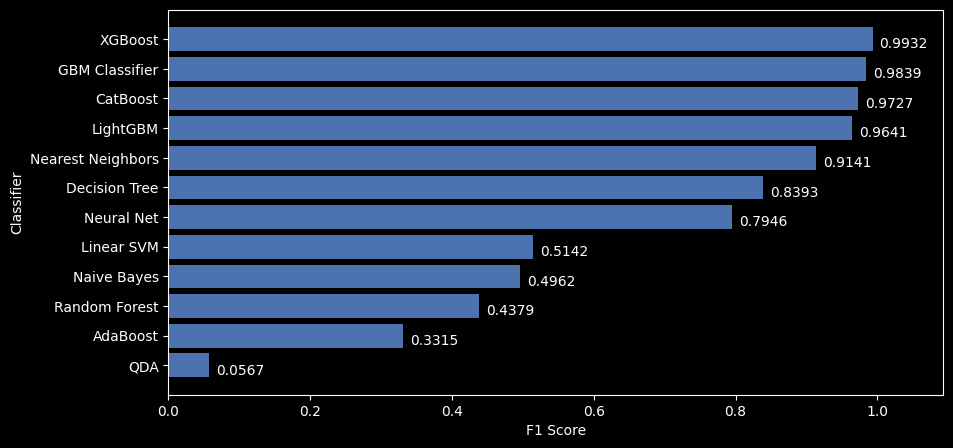

**Analisi dei risultati ottenuti**

Di seguito si analizzano le performance di ogni classificatore in base all' output ottenuto:


1. XGBoost (F1-weighted: 0.993)
    - Descrizione: XGBoost è un potente algoritmo di boosting simile al GBM Classifier ma più ottimizzato.
    - Pro: Ha ottenuto performance eccellenti, è estremamente efficiente e robusto contro overfitting. Funziona bene su dati complessi e di grandi dimensioni.
    - Contro: Potrebbe richiedere più tuning, ma è il modello con la performance migliore.

2. GBM Classifier (F1-weighted: 0.983)
    - Descrizione: Gradient Boosting Machines è un algoritmo di boosting che costruisce una serie di alberi decisionali deboli e li combina per migliorare le performance.
    - Pro: Prestazioni eccellenti e buona capacità di modellare relazioni complesse nei dati.
    - Contro: Richiede tempo per il tuning. In questo caso ha raggiunto iun ottimo F1-score.

3. CatBoost (F1-weighted: 0.973)
    - Descrizione: CatBoost è un algoritmo di boosting progettato per gestire in modo efficiente i dati categoriali senza la necessità di operazioni di pre-elaborazione come la codifica one-hot. È noto per la sua robustezza contro l'overfitting e per l'efficienza computazionale.
    - Pro: Prestazioni eccellenti su dataset complessi, in particolare con molte variabili categoriali. È facile da usare, richiede meno tuning rispetto ad altri algoritmi di boosting e tende a ridurre l'overfitting. Ottiene un eccellente F1-score in questo contesto.
    - Contro: Anche se ha ottenuto un punteggio eccezionale, potrebbe essere più lento da addestrare rispetto ad alcuni modelli, soprattutto se non ottimizzato correttamente.

4. LightGBM (F1-weighted: 0.964)
    - Descrizione: LightGBM (Light Gradient Boosting Machine) è un algoritmo di boosting ottimizzato per essere più veloce e leggero rispetto ai tradizionali algoritmi di boosting, come GBM o XGBoost. Utilizza tecniche di apprendimento basate su istogrammi per ridurre il tempo di addestramento e migliorare l'efficienza.
    - Pro: Ottime performance in termini di velocità e accuratezza, soprattutto su grandi dataset e con molte feature. È particolarmente efficiente nella gestione di dataset con squilibri di classe.
    - Contro**: Può essere sensibile ai parametri e richiedere un tuning accurato. Sebbene l'F1-score sia molto alto, risulta inferiore a quello di XGBoost.

5. Nearest Neighbors (F1-weighted: 0.914)
    - Descrizione: Questo algoritmo memorizza l'intero dataset di training e classifica nuovi dati in base alle classi più vicine. È sensibile alla distribuzione dei dati.
    - Pro: Buona performance in questo caso, ma può diventare inefficiente con molti dati.
    - Contro: Poco scalabile, e tende a soffrire quando ci sono molte feature irrilevanti o dataset di grandi dimensioni.

6. Decision Tree (F1-weighted: 0.840)
    - Descrizione: L’albero decisionale costruisce un modello basato su regole di decisione a partire dalle feature del dataset.
    - Pro: Facile da interpretare. Buono per identificare relazioni non lineari.
    - Contro: Soggetto a overfitting, specialmente senza potatura. L'F1-score moderato suggerisce che non sia il migliore per questo compito.

7. Neural Net (F1-weighted: 0.794)
    - Descrizione: Una rete neurale artificiale, in grado di modellare relazioni complesse e non lineari tra le feature.
    - Pro: Ottime performance, soprattutto su dataset con molte feature o dati complessi.
    - Contro: Tendenzialmente richiede più tempo per la configurazione e l'addestramento. Potrebbe essere più difficile da interpretare rispetto a modelli come Random Forest o XGBoost.

8. Linear SVM (F1-weighted: 0.514)
    - Descrizione: La Support Vector Machine lineare cerca di trovare un iperpiano che separi le classi. Funziona bene su dataset con molte feature, ma potrebbe non catturare bene le relazioni non lineari.
    - Pro: Buona precisione, soprattutto se le classi sono ben separabili linearmente.
    - Contro: Può non funzionare bene se i dati hanno relazioni non lineari. Ha ottenuto buoni risultati, ma altri classificatori come XGBoost hanno performance di gran lunga superiori.

9. Naive Bayes (F1-weighted: 0.496)
    - Descrizione: È un classificatore probabilistico basato sul teorema di Bayes, assumendo che le feature siano indipendenti tra loro.
    - Pro: È molto veloce e funziona bene con dati semplici.
    - Contro: Funziona male con feature correlate, e la sua performance è inferiore rispetto a modelli più avanzati come XGBoost o GBM Classifier.

10. Random Forest (F1-weighted: 0.438)
    - Descrizione: È un ensemble di alberi decisionali che riduce l'overfitting facendo la media delle previsioni di molti alberi.
    - Pro: Robustezza e capacità di gestire le feature non rilevanti.
    - Contro: Performance inferiore rispetto ad altri modelli. Questo suggerisce che probabilmente altri modelli sono più adatti ai dati.

12. AdaBoost (F1-weighted: 0.331)
    - Descrizione: AdaBoost costruisce un ensemble di modelli combinando deboli classificatori per migliorare le performance complessive.
    - Pro: Funziona bene su dataset semplici e problemi lineari.
    - Contro: In questo caso, il suo punteggio molto basso suggerisce che non è adatto per questo dataset. È sensibile al rumore e al sovra-adattamento.

13. QDA (Quadratic Discriminant Analysis) (F1-weighted: 0.057)
    - Descrizione: QDA cerca di separare le classi utilizzando decisioni quadratiche, anziché lineari come LDA.
    - Pro: Teoricamente utile se le classi sono ben separabili in modo non lineare.
    - Contro: Il punteggio estremamente basso indica che QDA non è affatto adatto per i dati che stai utilizzando.

## I modelli Boosting - Caratteristiche e differenze tra XGBoost, GBM Classifier, LightGBM e CatBoost

### Panoramica dei Modelli


- **XGBoost** (eXtreme Gradient Boosting)
- **GBM Classifier** (Gradient Boosting Machines)
- **LightGBM** (Light Gradient Boosting Machine)
- **CatBoost** (Categorical Boosting)

Questi modelli sono tutti basati su tecniche di *boosting*, ma presentano differenze significative nelle loro implementazioni e nelle modalità di gestione dei dati.

**Caratteristiche Tecniche**

| Caratteristica         | XGBoost                          | GBM Classifier                  | LightGBM                         | CatBoost                          |
|-----------------------|----------------------------------|---------------------------------|----------------------------------|-----------------------------------|
| **Struttura degli Alberi** | CART (Classification And Regression Trees) | Alberi decisionali standard      | Crescita leaf-wise               | Alberi simmetrici                 |
| **Gestione Categoriale**   | Non supporta nativamente le variabili categoriali | Supporta variabili numeriche     | Supporta variabili categoriali tramite pre-elaborazione | Gestione nativa delle variabili categoriali |
| **Velocità di Addestramento**  | Veloce, ma richiede tuning dei parametri | Moderata                         | Molto veloce grazie a GOSS       | Veloce, ma con un tempo di addestramento più lungo rispetto a LightGBM |
| **Controllo dell'Overfitting**  | Regularizzazione e pruning degli alberi | Regularizzazione standard         | Limiti di profondità e regularizzazione  | Regularizzazione tramite Ordered Boosting |
| **Parallelismo**      | Supporta il calcolo parallelo    | Limitato                         | Eccellente parallelismo           | Supporto per GPU e multi-threading |

#### F1-Score e Significato del Risultato

Gli F1-score ottenuti dai modelli sono i seguenti:

- XGBoost: 0.993
- GBM Classifier: 0.983
- CatBoost: 0.973
- LightGBM: 0.964

La scelta tra XGBoost, GBM Classifier, LightGBM e CatBoost dipende dalle specifiche esigenze del progetto, dal tipo di dati disponibili e dalle risorse computazionali. Ognuno di questi algoritmi ha i suoi punti di forza e debolezza; pertanto si sono tutti e quattro i modelli per determinare quale funzioni meglio nel contesto specifico dell'applicazione.

Citations:
[1] https://tech.deliveryhero.com/is-catboost-faster-than-lightgbm-and-xgboost/
[2] https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm
[3] https://hackernoon.com/difference-between-boosting-trees-updates-to-classics-with-catboost-xgboost-and-lightgbm
[4] https://datamapu.com/posts/classical_ml/gradient_boosting_variants/
[5] https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db
[6] https://www.kaggle.com/code/faressayah/xgboost-vs-lightgbm-vs-catboost-vs-adaboost

**Considerazioni Importanti**
- Gestione delle Variabili Categoriali: CatBoost è progettato per gestire le variabili categoriali in modo efficiente. Quando si addestra il modello, puoi semplicemente specificare quali colonne sono categoriali utilizzando il parametro cat_features. CatBoost utilizza tecniche di encoding specifiche (come l'encoding basato sul target) internamente.

- Evita il Target Leakage: Non codificare la variabile target prima della suddivisione dei dati aiuta a prevenire il rischio di target leakage, dove le informazioni sul target influenzano inavvertitamente la previsione.

- Utilizzo di CatBoost: Quando si usa CatBoost, ci si deve assicurare di passare l'elenco delle colonne categoriali al modello durante l'addestramento. Questo consente a CatBoost di applicare le sue tecniche di encoding appropriate per quelle colonne.

Con queste modifiche, l'algoritmo sarà pronto per addestrare un modello CatBoost senza la necessità di codificare esplicitamente la variabile target.

Affinché si possa utilizzare il DataFrame per tutti e quattro i modelli (**LightGBM**, **XGBoost**, **CatBoost** e **GBM Classifier**), le variabili categoriali devono essere gestite in modo appropriato.

**Codifica delle Variabili Categoriali**

- **LightGBM, XGBoost e GBM Classifier**: Questi modelli richiedono che le variabili categoriali siano codificate numericamente [df_std]

- **CatBoost**: Questo modello gestisce nativamente le variabili categoriali. È possibile semplicemente passare le colonne categoriali direttamente al modello senza necessità di codifica esplicita. CatBoost utilizza tecniche avanzate come per trasformare automaticamente queste variabili in numeriche durante l'addestramento [df_cat]

I valori alti dell'F1-score potrebbero essere falsati dalla presenza di overfitting.

Si procede utilizzando l'algoritmo Apriori per identificare le associazioni tra le feature e successivamente, per ciascun modello di boosting, si addestra il modello e si calcola l'importanza delle feature.

# Sistemi ibridi di raccomandazione

L'approccio che si vuole percorrere è usare l'algoritmo Apriori per le regole di associazione e poi applicare un classificatore tra GBM Classifier, XGBoost, LightGBM e CatBoost per la previsione sul tipo di polizza da raccomandare al cliente.

LightGBM e CatBoost sono ottime alternative a XGBoost, soprattutto quando il contesto è la classificazione multi-classe e si ha un dataset con classi non bilanciate. Ciascuno di questi algoritmi ha vantaggi specifici rispetto a XGBoost, e in alcune situazioni può effettivamente essere preferibile usarli.

Se si ha un dataset con molte variabili categoriche (come 'Policy', 'Vehicle_Type', 'Location_Type'), CatBoost potrebbe essere la scelta migliore. La gestione nativa delle feature categoriali semplifica molto il flusso di lavoro e potrebbe migliorare la performance senza bisogno di tanto tuning. LightGBM è la scelta giusta se il dataset è grande e richiede performance computazionali elevate. È più veloce di XGBoost e gestisce bene le classi non bilanciate. XGBoost rimane una buona scelta, ma in uno scenario competitivo come quello commerciale, CatBoost e LightGBM potrebbero offrire maggiore flessibilità e velocità. Tuttavia, il GBM Classifier può richiedere un tuning più attento per evitare l'overfitting, specialmente su dataset complessi o sbilanciati.

Combinando **Apriori** per identificare pattern utili, la **verifica delle feature**/caratteristiche più rilevanti per ogni modello e uno di questi modelli di **boosting per fare previsioni precise**, si può creare un sistema di raccomandazione potente e ben bilanciato.

## Algoritmo Apriori

L'algoritmo Apriori è ideale per individuare associazioni e pattern ricorrenti tra polizze già acquistate dagli utenti. Per esempio, si può rilevare che determinate combinazioni di caratteristiche sono associate all'acquisto di certi tipi di polizze. Una volta individuati questi pattern, si possono utilizzare come caratteristiche aggiuntive o informazioni ausiliarie nel classificatore.

### Definizione e teoria

L'algoritmo Apriori è stato sviluppato da Agrawal e Srikant nel 1994, ed è progettato per identificare insiemi di articoli frequentemente associati all'interno di un database di transazioni. 

Funzionamento dell'Algoritmo

L'algoritmo si basa su due concetti chiave:

1. Supporto: Questa misura indica la frequenza con cui un insieme di articoli appare nel database. Un insieme di articoli è considerato "frequente" se il suo supporto supera una soglia minima predefinita.

2. Regole di Associazione: Una volta identificati gli insiemi frequenti, l'algoritmo genera regole che descrivono le relazioni tra gli articoli. Ogni regola ha un valore di confidenza, che misura la probabilità che un articolo venga acquistato dato che un altro articolo è stato acquistato.

Fasi dell'Algoritmo

L'algoritmo Apriori opera in due fasi principali:

1. Generazione degli Insiemi Frequenti: In questa fase, l'algoritmo esamina il database per identificare tutti gli insiemi di articoli che soddisfano il criterio di supporto minimo. Questo avviene attraverso ripetute scansioni del database, dove si generano insiemi candidati e si contano le loro occorrenze.

2. Generazione delle Regole di Associazione: Una volta identificati gli insiemi frequenti, l'algoritmo genera regole di associazione da questi insiemi, valutandone la confidenza per determinare la loro validità.


Applicazioni


L'algoritmo Apriori trova applicazione in vari settori, tra cui:

- E-commerce: Per analizzare i comportamenti d'acquisto dei clienti e migliorare le strategie di marketing.
  
- Telecomunicazioni e Sanità: Per identificare pattern nei dati delle transazioni e migliorare i servizi offerti.

- Analisi Comportamentale: Comprensione delle preferenze degli utenti attraverso l'identificazione di pattern nei dati.


Per comprendere meglio l'algoritmo, di seguito si riportano alcuni concetti fondamentali:

1. Itemset e Itemset Frequente: Un itemset è un insieme di articoli (o variabili) che possono apparire insieme in una transazione. Un itemset frequente è definito come un itemset il cui supporto supera una soglia minima predefinita. Il supporto è calcolato come la proporzione di transazioni nel database che contengono l'itemset.

2. Supporto e Confidenza:
   - Supporto: Indica la frequenza con cui un certo itemset appare nel dataset. Matematicamente, per un itemset X, il supporto è dato da:
     - Support(X) = Numero di transazioni contenenti X / Numero totale di transazioni
     
   - Confidenza: Rappresenta la probabilità che un certo itemset Y venga acquistato dato che un altro itemset X è già stato acquistato. La confidenza è calcolata come:
     - Confidenza(X --> Y) = Support(X U Y) / Support(X) 
     
3. Principio di Anti-Monotonicità: Questo principio è alla base dell'algoritmo Apriori e afferma che se un itemset è frequente, allora tutti i suoi sottoinsiemi devono essere frequenti. Viceversa, se un itemset non è frequente, nessun suo superset può essere frequente. Questo riduce significativamente il numero di candidati da considerare.

In sintesi, l'algoritmo Apriori rappresenta uno strumento cruciale per l'estrazione di regole di associazione. La sua capacità di rivelare connessioni significative tra gli elementi all'interno dei dataset lo rende essenziale per le decisioni strategiche in vari settori.



Citations:
[1] https://www.meccanismocomplesso.org/lalgoritmo-apriori-in-python-scopri-le-associazioni-nei-dati/
[2] https://it.wikipedia.org/wiki/Algoritmo_apriori
[3] https://www.sci.unich.it/~amato/teaching/old/datamining08/lucidi/04-regole-associative.pdf
[4] Gérald Kembellec_ Ghislaine Chartron_ Imad Saleh_ Gérald Kembell - Recommender Systems (2014, John Wiley & Sons, Incorporated)
[5] https://www.scirp.org/journal/paperinformation?paperid=108829
[6] https://jurnal.itscience.org/index.php/brilliance/article/view/1228
[7] https://arxiv.org/pdf/1403.3948.pdf

### Apriori su df_std_train

In [141]:
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import ParameterGrid

In [142]:
# One-Hot Encoding
# Creazione di variabili fittizie per Education
df_std_train = df_std_train.drop(['kfold'], axis=1)

dummy3 = pd.get_dummies(df_cat_train[['Education','Vehicle_Age']], drop_first=False).astype(int) # type: ignore

# Si aggiungono i risultati al dataframe df_apriori_train
df_apriori_train = pd.concat([df_std_train, dummy3], axis=1)

# Avendo creato le variabili dummy si possono rimuovere dal dataframe le seguenti colonne
df_apriori_train = df_apriori_train.drop(['Education','Vehicle_Age'], axis=1)

L'algortimo Apriori può essere applicato solo su variabili categoriali. Si trascurano quindi le variabili numeriche.

In [143]:
# Si escludono le variabili numeriche e la variabile target e si converte il data type in boolean
X_apriori_train = df_apriori_train.drop(['Policy','Age','Annual_Income'], axis=1)
X_apriori_train = X_apriori_train.astype('bool')

In [144]:
# Si definiscono i parametri da testare
param_grid = {
    'min_support': [0.3, 0.4, 0.5],
    'min_threshold': [0.6, 0.7, 0.8]
}

# Si crea una lista per memorizzare i risultati
results = []

# Si esegue la validazione incrociata
for params in ParameterGrid(param_grid):
    # Applicare l'algoritmo Apriori
    frequent_itemsets = apriori(X_apriori_train.astype(bool), min_support=params['min_support'])
    
    # Si generano le regole di associazione
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=params['min_threshold'])
    
    # Si memorizzano i risultati
    results.append({
        'min_support': params['min_support'],
        'min_threshold': params['min_threshold'],
        'num_rules': len(rules)
    })

# Si crea un DataFrame con i risultati
results_df = pd.DataFrame(results)

# Si visualizzano i risultati
print(results_df)

   min_support  min_threshold  num_rules
0          0.3            0.6          9
1          0.3            0.7          3
2          0.3            0.8          3
3          0.4            0.6          2
4          0.4            0.7          2
5          0.4            0.8          2
6          0.5            0.6          0
7          0.5            0.7          0
8          0.5            0.8          0


In [145]:
# Applicazione dell'algoritmo Apriori: si utilizza la funzione apriori() per trovare i set di elementi frequenti con un supporto minimo definito (in questo caso il supporto è impostato a >=30%)
frequent_itemsets = apriori(X_apriori_train.astype(bool), min_support=0.3)

# Generazione delle regole di associazione: si creano le regole di associazione utilizzando la funzione association_rules(), specificando che vogliono delle regole con una confidenza minima del 60%
rules = association_rules(frequent_itemsets,
                          metric="confidence",
                          min_threshold=0.6)

# Visualizzazione delle regole
print("Regole di associazione trovate:")
print(rules)

Regole di associazione trovate:
  antecedents consequents  antecedent support  consequent support   support  \
0        (20)         (0)            0.526127            0.539966  0.321035   
1         (1)        (17)            0.458449            0.499538  0.306441   
2        (17)         (1)            0.499538            0.458449  0.306441   
3         (2)        (20)            0.504580            0.526127  0.336934   
4        (20)         (2)            0.526127            0.504580  0.336934   
5         (3)         (7)            0.369277            0.465819  0.300202   
6         (7)         (3)            0.465819            0.369277  0.300202   
7        (17)        (19)            0.499538            0.431951  0.405622   
8        (19)        (17)            0.431951            0.499538  0.405622   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.610186  1.130045  0.036944    1.180136       0.242848  
1    0.668428  1.338094  0.077428    1.509365      

L'output che si ottiene dall'algoritmo Apriori contiene regole di associazione, ciascuna delle quali è composta da un insieme di antecedenti e conseguenti. Ecco come interpretare ciascuna colonna dell'output:

##### Colonne dell'Output

1. **antecedents**: Questo è l'insieme di elementi (variabili) che precedono la regola. Rappresenta le condizioni che devono essere soddisfatte affinché il conseguente si verifichi.

2. **consequents**: Questo è l'insieme di elementi (variabili) che seguono la regola. Rappresenta l'elemento che si prevede si verifichi se le condizioni degli antecedenti sono soddisfatte.

3. **antecedent support**: Questa colonna indica la proporzione di transazioni nel dataset che contengono gli antecedenti. Ad esempio, un valore di 0.539855 significa che circa il 53.99% delle transazioni include gli antecedenti specificati.

4. **consequent support**: Questa colonna mostra la proporzione di transazioni nel dataset che contengono i conseguenti. Un valore di 1.000000 indica che il conseguente è presente in tutte le transazioni analizzate.

5. **support**: Questo rappresenta la proporzione totale di transazioni nel dataset che contengono sia gli antecedenti che i conseguenti. È una misura della frequenza con cui la regola si verifica nel dataset.

6. **confidence**: Questa è una misura della probabilità che il conseguente si verifichi dato che gli antecedenti sono già presenti. Un valore di 1.000000 indica una fiducia perfetta, cioè ogni volta che gli antecedenti sono presenti, anche i conseguenti lo sono.

7. **lift**: Questa misura indica quanto la presenza degli antecedenti aumenta la probabilità di trovare i conseguenti rispetto a quanto ci si aspetterebbe se fossero indipendenti. Un valore superiore a 1 indica una relazione positiva tra gli antecedenti e i conseguenti.

8. **leverage**: Questa misura indica quanto la probabilità di trovare gli antecedenti e i conseguenti insieme supera quella attesa se fossero indipendenti. Valori positivi indicano una relazione positiva.

9. **conviction**: Questa misura fornisce un'indicazione della forza della regola, confrontando la probabilità che gli antecedenti si verifichino senza il conseguente rispetto a quando il conseguente è presente. Valori più alti indicano una regola più forte.

10. **zhangs_metric**: Questo è un'altra misura della forza della regola, simile alla conviction, ma con una diversa interpretazione statistica.

##### Esempi di Interpretazione

- **Regola 0**:
  - Antecedents: `(20)` = Vehicle_Age_10-20 Years
  - Consequents: `(0)` = Gender_Male
  - Confidence: `0.610186` → Quando `20` è presente, c'è circa un `61%` di probabilitù che anche `0` è presente.

Le regole con alta **confidence** (vicino a 1) e alta **lift** (superiore a 1) sono particolarmente interessanti, poiché indicano forti relazioni tra gli antecedenti e i conseguenti.

Si possono utilizzare queste regole per arricchire il modello di classificazione, creando nuove feature basate sulle associazioni identificate.

In [146]:
# Analisi della rilevanza
relevance_analysis = []

for index, row in rules.iterrows():
    relevance_analysis.append({
        'antecedent': row['antecedents'],
        'consequent': row['consequents'],
        'lift': row['lift'],
        'confidence': row['confidence'],
        'support': row['support'],
        'zhangs_metric': row['zhangs_metric'],
        'relevant_for_upselling': row['lift'] > 1 and row['confidence'] > 0.70,
    })

# Si crea un DataFrame per l'analisi
relevance_df = pd.DataFrame(relevance_analysis)

# Si filtra solo le righe con relevant_for_upselling = True
upselling_df = relevance_df[relevance_df['relevant_for_upselling']]

print(upselling_df)

  antecedent consequent      lift  confidence   support  zhangs_metric  \
5        (3)        (7)  1.745196    0.812946  0.300202       0.676998   
7       (17)       (19)  1.879833    0.811996  0.405622       0.935211   
8       (19)       (17)  1.879833    0.939047  0.405622       0.823939   

   relevant_for_upselling  
5                    True  
7                    True  
8                    True  


È possibile analizzare le regole di associazione in base a metriche come lift, confidence e support. Queste metriche aiutano a valutare la forza e la significatività delle associazioni.
- Lift: Un valore superiore a 1 indica una relazione positiva tra gli antecedenti e i conseguenti. Più alto è il lift, più forte è la relazione.
- Confidence: Un valore elevato (ad esempio, maggiore di 0.7) indica che quando gli antecedenti sono presenti, è probabile che anche i conseguenti siano presenti.
- Support: Indica la frequenza con cui gli antecedenti e i conseguenti si verificano insieme nel dataset. Un supporto più alto significa che la regola è più comune.

#### Zhang's metric

Zhang's metric è una misura utilizzata nell'analisi delle regole di associazione per valutare la forza e la certezza delle associazioni tra gli itemset. Questa metrica è particolarmente utile per distinguere tra associazioni e dissociazioni, fornendo un'indicazione più dettagliata della relazione tra gli elementi.

##### **Definizione e Formula di Zhang's Metric**

Zhang's metric è calcolata come segue:

$$
\text{zhangs\_metric} = \frac{\text{leverage}}{\max(\text{support}(\text{rule}) \cdot (1 - \text{support}(\text{antecedent})), \text{support}(\text{antecedent}) \cdot (\text{support}(\text{consequent}) - \text{support}(\text{rule})) )}
$$

##### **Componenti della Formula**

- **Leverage**: La leverage misura la differenza tra la probabilità osservata di A e C apparire insieme e quella che ci si aspetterebbe se A e C fossero indipendenti. È calcolata come:

$$
\text{leverage} = \text{support}(A \cup C) - \text{support}(A) \cdot \text{support}(C)
$$

- **Supporto della Regola**: Rappresenta la frequenza con cui l'insieme di elementi (A ∪ C) appare nel dataset.

- **Supporto dell'Antecedente**: È la frequenza con cui l'antecedente (A) appare nel dataset.

- **Supporto del Conseguente**: È la frequenza con cui il conseguente (C) appare nel dataset.

##### **Interpretazione di Zhang's Metric**

- **Intervallo**: Zhang's metric varia tra -1 e 1.
  
  - Un valore positivo (>0) indica una forte associazione tra l'antecedente e il conseguente.
  
  - Un valore negativo (<0) suggerisce una dissociazione, indicando che l'antecedente non è utile per prevedere il conseguente.

- **Utilità**: Questa metrica aiuta a identificare regole più significative, poiché considera sia l'associazione che la dissociazione, fornendo un quadro più completo delle relazioni tra gli itemset.

##### **Applicazione Pratica**

Zhang's metric è utilizzata in contesti come il market basket analysis, dove le aziende cercano di capire quali prodotti vengono spesso acquistati insieme. Ad esempio, se un cliente acquista pane, potrebbe essere utile sapere se è probabile che acquisti anche burro. Zhang's metric può aiutare a determinare se questa associazione è forte o debole, guidando le strategie di marketing e promozione.

Zhang's metric è una misura fondamentale nell'analisi delle regole di associazione, fornendo insight sulla forza delle relazioni tra gli itemset e contribuendo a decisioni informate in vari ambiti, dall'e-commerce al marketing.

Citations:
[1] https://codinginfinite.com/implement-apriori-algorithm-in-python/
[2] https://assets-eu.researchsquare.com/files/rs-4360582/v1/b620b103-6cc0-474e-a905-03523b30246a.pdf
[3] https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
[4] https://it.wikibooks.org/wiki/Intelligenza_artificiale/Regole_di_associazione

In [147]:
# Filtro le regole con forte associazione (zhangs_metric > 0)
strong_association_df = upselling_df[upselling_df['zhangs_metric'] > 0]

# Filtro le regole con forte dissociazione (zhangs_metric < 0)
strong_dissociation_df = upselling_df[upselling_df['zhangs_metric'] < 0]

# Ordino i DataFrame in base a Zhang's metric
strong_association_df = strong_association_df.sort_values(by='zhangs_metric', ascending=False) # type: ignore
strong_dissociation_df = strong_dissociation_df.sort_values(by='zhangs_metric', ascending=True) # type: ignore

# Stampo i risultati
print("Regole con Forte Associazione:")
print(strong_association_df[['antecedent', 'consequent', 'zhangs_metric', 'lift', 'confidence', 'support']])

print("\nRegole con Forte Dissociazione:")
print(strong_dissociation_df[['antecedent', 'consequent', 'zhangs_metric', 'lift', 'confidence', 'support']])

Regole con Forte Associazione:
  antecedent consequent  zhangs_metric      lift  confidence   support
7       (17)       (19)       0.935211  1.879833    0.811996  0.405622
8       (19)       (17)       0.823939  1.879833    0.939047  0.405622
5        (3)        (7)       0.676998  1.745196    0.812946  0.300202

Regole con Forte Dissociazione:
Empty DataFrame
Columns: [antecedent, consequent, zhangs_metric, lift, confidence, support]
Index: []


**Spiegazione del Codice**
- Filtraggio:
    - Forte Associazione: Le regole con zhangs_metric > 0 indicano una forte associazione tra l'antecedente e il conseguente.
    - Forte Dissociazione: Le regole con zhangs_metric < 0 indicano una dissociazione, suggerendo che l'antecedente non è utile per prevedere il conseguente.

In [148]:
# Filtro le regole con forte associazione (zhangs_metric = 1)
strong_association_1 = upselling_df[upselling_df['zhangs_metric'] == 1]

# Ordino i DataFrame in base a Zhang's metric
strong_association_1 = strong_association_1.sort_values(by='zhangs_metric', ascending=False) # type: ignore

# Lista delle feature originali
features = list(X_apriori_train.columns)

# Estrai gli antecedenti e i conseguenti
antecedents = strong_association_1['antecedent']
consequents = strong_association_1['consequent']

# Unisci antecedent e consequent
combined_features = antecedents.apply(lambda x: list(x)) + consequents.apply(lambda x: list(x))

# Appiattisci e crea un insieme di feature uniche
unique_features = set([item for sublist in combined_features for item in sublist])

# Stampa le feature uniche coinvolte nelle regole di associazione
print("Feature uniche coinvolte nelle regole di associazione con associazione massima (pari a 1):")
print(unique_features)

Feature uniche coinvolte nelle regole di associazione con associazione massima (pari a 1):
set()


Non ci sono regole di associazione con zhangs_metric = 1, ossia con antecedente e consequente indipendenti

### Si filtrano le regole con forte associazione (ma con zhangs_metric compreso tra 0 (incluso) e 1 (escluso))

In [149]:
strong_association = upselling_df[(upselling_df['zhangs_metric'] > 0) & (upselling_df['zhangs_metric'] < 1)]

# Ordino i DataFrame in base a Zhang's metric
strong_association = strong_association.sort_values(by='zhangs_metric', ascending=False) # type: ignore

# Stampo i risultati
print("Regole con Forte Associazione:")
print(strong_association[['antecedent', 'consequent', 'zhangs_metric', 'lift', 'confidence', 'support']])

Regole con Forte Associazione:
  antecedent consequent  zhangs_metric      lift  confidence   support
7       (17)       (19)       0.935211  1.879833    0.811996  0.405622
8       (19)       (17)       0.823939  1.879833    0.939047  0.405622
5        (3)        (7)       0.676998  1.745196    0.812946  0.300202


Dopo aver ottenuto regole da Apriori, si possono usare per migliorare la classificazione delle polizze. In questo contesto, il classificatore sarà responsabile di predire la polizza da proporre (raccomandazione) basandosi su diverse feature (es. età, reddito, veicolo) e le regole di associazione ottenute da Apriori.

Si usa dunque un approccio Ensemble Design --> Sequential --> Feature Augmetation. L'idea è di arricchire il dataset con nuove feature derivate dalle regole di associazione identificate da Apriori (che funge da modello di raccomandazione contributivo). In questo modo, il classificatore può sfruttare sia le informazioni originali sia l'output di associazioni implicite trovate tramite Apriori:

- Fase 1: Si applica Apriori per generare regole basate su associazioni nel dataset.
- Fase 2: Si usa il risultato di queste regole come input o suggerimento per il classificatore in modo da migliorare la precisione del modello.

### Creazione nuove feature nel dataframe principale

In [150]:
strong_association

,antecedent,consequent,lift,confidence,support,zhangs_metric,relevant_for_upselling
7,(17),(19),1.879833,0.811996,0.405622,0.935211,True
8,(19),(17),1.879833,0.939047,0.405622,0.823939,True
5,(3),(7),1.745196,0.812946,0.300202,0.676998,True


In [151]:
def upload_antecedent_consequent(df):
    # Creazione delle colonne con valori iniziali 0
    df['antecedent_Education_College'] = 0.0
    df['antecedent_Vehicle_Age_min_10_Years'] = 0.0
    df['antecedent_Region_Code_NE'] = 0.0
    df['consequent_Education_College'] = 0.0
    df['consequent_Vehicle_Age_min_10_Years'] = 0.0
    df['consequent_Location_Type_Urban'] = 0.0
    df['lift'] = 0.0
    df['confidence'] = 0.0
    df['support'] = 0.0
    df['zhangs_metric'] = 0.0
   
    # Condizioni e aggiornamento delle regole antedente e consequente

    # Condizione 1: Education_College=1
    condition1 = (df['Education_College'] == 1)
    df.loc[condition1, ['antecedent_Education_College','consequent_Education_College']] = [1,1]

    # Condizione 2: Vehicle_Age_< 10 Years=1
    condition2 = (df['Vehicle_Age_< 10 Years'] == 1)
    df.loc[condition2, ['antecedent_Vehicle_Age_min_10_Years','consequent_Vehicle_Age_min_10_Years']] = [1,1]

    # Condizione 3: Region_Code_NE=1
    condition3 = (df['Region_Code_NE'] == 1)
    df.loc[condition3, ['antecedent_Region_Code_NE']] = [1]

    # Condizione 4: Location_Type_Urban=1
    condition4 = (df['Location_Type_Urban'] == 1)
    df.loc[condition4, ['consequent_Location_Type_Urban']] = [1]

    return df

#### Aggiornamento df_apriori_train

In [152]:
# Applicare la funzione per aggiornare df_apriori_train
df_apriori_train = upload_antecedent_consequent(df_apriori_train)

In [153]:
strong_association

,antecedent,consequent,lift,confidence,support,zhangs_metric,relevant_for_upselling
7,(17),(19),1.879833,0.811996,0.405622,0.935211,True
8,(19),(17),1.879833,0.939047,0.405622,0.823939,True
5,(3),(7),1.745196,0.812946,0.300202,0.676998,True


In [154]:
def upload_lift_confidence_support_zhangs_metric(df):
   
    # Condizione 5: antecedent_Education_College=1 e consequent_Vehicle_Age_min_10_Years=1
    condition5 = (df['antecedent_Education_College'] == 1) & (df['consequent_Vehicle_Age_min_10_Years'] == 1)
    df.loc[condition5, ['lift','confidence', 'support', 'zhangs_metric']] = [1.879833,0.811996,0.405622,0.935211]

    # Condizione6 : antecedent_Vehicle_Age_min_10_Years=1 e consequent_Education_College=1
    condition6 = (df['antecedent_Vehicle_Age_min_10_Years'] == 1) & (df['consequent_Education_College'] == 1)
    df.loc[condition6, ['lift','confidence', 'support', 'zhangs_metric']] = [1.879833,0.939047,0.405622,0.823939]

    # Condizione 7: antecedent_Region_Code_NE=1 e consequent_Location_Type_Urban=1
    condition7 = (df['antecedent_Region_Code_NE'] == 1) & (df['consequent_Location_Type_Urban'] == 1)
    df.loc[condition7, ['lift','confidence', 'support', 'zhangs_metric']] = [1.745196,0.812946,0.300202,0.676998]

    return df

In [155]:
# Applicare la funzione per aggiornare df_apriori_train
df_apriori_train = upload_lift_confidence_support_zhangs_metric(df_apriori_train)

In [156]:
df_apriori_train = df_apriori_train.rename(columns={'Education_High School or Below': 'Education_High_School_or_Below'})
df_apriori_train = df_apriori_train.rename(columns={'Vehicle_Age_< 10 Years': 'Vehicle_Age_min_10_Years'})
df_apriori_train = df_apriori_train.rename(columns={'Vehicle_Age_10-20 Years': 'Vehicle_Age_10-20_Years'})
df_apriori_train = df_apriori_train.rename(columns={'Vehicle_Age_> 20 Years': 'Vehicle_Age_max_20_Years'})

#### Aggiornamento df_std_test

In [157]:
# One-Hot Encoding
# Creazione di variabili fittizie per Education

dummy4 = pd.get_dummies(df_cat_test[['Education','Vehicle_Age']], drop_first=False).astype(int) # type: ignore

# Si aggiungono i risultati al dataframe df_apriori_train
df_std_test = pd.concat([df_std_test, dummy4], axis=1)

# Avendo creato le variabili dummy si possono rimuovere dal dataframe le seguenti colonne
df_std_test = df_std_test.drop(['Education','Vehicle_Age'], axis=1)

In [158]:
# Applicare la funzione per aggiornare df_std_test
df_std_test = upload_antecedent_consequent(df_std_test)

In [159]:
# Applicare la funzione per aggiornare df_std_test
df_std_test = upload_lift_confidence_support_zhangs_metric(df_std_test)

In [160]:
df_std_test = df_std_test.rename(columns={'Education_High School or Below': 'Education_High_School_or_Below'})
df_std_test = df_std_test.rename(columns={'Vehicle_Age_< 10 Years': 'Vehicle_Age_min_10_Years'})
df_std_test = df_std_test.rename(columns={'Vehicle_Age_10-20 Years': 'Vehicle_Age_10-20_Years'})
df_std_test = df_std_test.rename(columns={'Vehicle_Age_> 20 Years': 'Vehicle_Age_max_20_Years'})

#### Aggiornamento df_cat_test

In [161]:
df_cat_test = df_cat_test.assign(Age=df_std_test['Age'], Annual_Income=df_std_test['Annual_Income'],
                         antecedent_Education_College=df_std_test['antecedent_Education_College'],
                         antecedent_Vehicle_Age_min_10_Years=df_std_test['antecedent_Vehicle_Age_min_10_Years'],
                         antecedent_Region_Code_NE=df_std_test['antecedent_Region_Code_NE'],
                         consequent_Education_College=df_std_test['consequent_Education_College'],
                         consequent_Vehicle_Age_min_10_Years=df_std_test['consequent_Vehicle_Age_min_10_Years'],
                         consequent_Location_Type_Urban=df_std_test['consequent_Location_Type_Urban'],
                         lift=df_std_test['lift'],
                         confidence=df_std_test['confidence'],
                         support=df_std_test['support'],
                         zhangs_metric=df_std_test['zhangs_metric']
                         )

## Importanza delle feature per ogni modello boosting

Per ciascun modello di boosting (GBM Classifier, XGBoost, LightGBM e CatBoost) si addestra il modello e si calcola l'importanza delle feature.

L'importanza di ogni feature per i modelli di boosting viene calcolata basandosi sul metodo 'gain'.
Tale metodo misura il miglioramento medio della funzione di perdita ogni volta che una feature viene utilizzata per effettuare una suddivisione in un albero. Maggiore è il gain associato a una feature, più essa è considerata importante.

La funzione di perdita misura la differenza tra le previsioni del modello e i valori reali (target) nel dataset. Essa fornisce una misura quantitativa dell'errore del modello. Durante l'addestramento, l'obiettivo del modello è minimizzare la funzione di perdita. In altre parole, il modello cerca di trovare i parametri che riducono al minimo l'errore tra le previsioni e i valori reali.

Tipicamente per problemi di classificazione binaria o multiclasse si utilizza la funzione di perdita log-loss.

La log-loss (o perdita logaritmica) misura la performance di un modello di classificazione calcolando la distanza tra le probabilità previste e le etichette vere. Essa penalizza le previsioni errate, in particolare quelle che sono molto sicure ma sbagliate.

Per un problema di classificazione binaria, la formula della log-loss è:

L(y,p) = − 1/N ∑[yilog(pi)+(1−yi)log(1−pi)] {sommatoria che va da i=1 a N}

dove: 
- yi è l'etichetta vera (0 o 1),
- pi è la probabilità prevista che l'osservazione appartenga alla classe positiva,N
- N è il numero totale di osservazioni

Nel caso in esame la formula della log-loss per classificazione multi-classe è:

L(y,q) = -1/N ∑∑yiklog(qik) {prima sommatoria che va da i=1 a N e seconda sommatoria che va da k=1 a K}

dove:
- N è il numero totale di osservazioni
- K è il numero di classi (nel caso in esame i 7 tipi di polizza)
- yik è un indicatore binario che corrisponde a 1 se l'esempio i appartiene alla classe k, altrimenti è 0. Questo rappresenta la vera distribuzione delle etichette.
- qik è la probabilità predetta dal modello che l'esempio i appartenga alla classe k.


La somma interna su k calcola la log-loss per un singolo esempio i, confrontando la distribuzione vera delle etichette yik con la distribuzione predetta qik.

La somma esterna su i aggrega queste perdite per tutti gli esempi nel dataset, fornendo una misura complessiva della performance del modello.

Un valore di log-loss più basso indica una migliore performance del modello. Se il modello prevede una probabilità alta per la classe corretta, la log-loss sarà bassa. Al contrario, se il modello prevede una probabilità alta per una classe sbagliata, la log-loss aumenterà significativamente.

### Preparazione training e validation set

#### df_apriori_train --> X_apriori_train, X_apriori_valid, y_apriori_train, y_apriori_valid

In [162]:
# Separare le feature dal target
X_apriori = df_apriori_train.drop(columns=['Policy'])  # Supponendo che 'Policy' sia il target
y_apriori = df_apriori_train['Policy']

In [163]:
# Suddividere il dataset in training e validation set
X_apriori_train, X_apriori_valid, y_apriori_train, y_apriori_valid = train_test_split(X_apriori, y_apriori, test_size=0.2, random_state=42)

#### df_cat_apriori_train --> X_cat_apriori_train, X_cat_apriori_valid, y_cat_apriori_train, y_cat_apriori_valid

In [164]:
df_cat_apriori_train = df_cat_train.copy()
df_cat_apriori_train = df_cat_apriori_train.assign(Age=df_apriori_train['Age'], Annual_Income=df_apriori_train['Annual_Income'],
                         antecedent_Education_College=df_apriori_train['antecedent_Education_College'],
                         antecedent_Vehicle_Age_min_10_Years=df_apriori_train['antecedent_Vehicle_Age_min_10_Years'],
                         antecedent_Region_Code_NE=df_apriori_train['antecedent_Region_Code_NE'],
                         consequent_Education_College=df_apriori_train['consequent_Education_College'],
                         consequent_Vehicle_Age_min_10_Years=df_apriori_train['consequent_Vehicle_Age_min_10_Years'],
                         consequent_Location_Type_Urban=df_apriori_train['consequent_Location_Type_Urban'],
                         lift=df_apriori_train['lift'],
                         confidence=df_apriori_train['confidence'],
                         support=df_apriori_train['support'],
                         zhangs_metric=df_apriori_train['zhangs_metric']
                         )

In [165]:
# Separare le feature dal target
X_cat_apriori = df_cat_apriori_train.drop(columns=['Policy'])  # Supponendo che 'Policy' sia il target
y_cat_apriori = df_cat_apriori_train['Policy']

# Suddividere il dataset in training e validation set
X_cat_apriori_train, X_cat_apriori_valid, y_cat_apriori_train, y_cat_apriori_valid = train_test_split(X_cat_apriori, y_cat_apriori, test_size=0.2, random_state=42)

### Importanza delle feature per GBM Classifier

In [166]:
from sklearn.utils import compute_sample_weight

Si usa la funzione compute_sample_weight('balanced', y_apriori_train) per gestire lo sbilanciamento delle classi. Questa funzione calcola i pesi in modo che siano inversamente proporzionali alla frequenza delle classi nel dataset. Le classi meno rappresentate riceveranno un peso maggiore, mentre quelle più rappresentate riceveranno un peso minore.

In [167]:
# Si calcolano i pesi delle classi
sample_weight = compute_sample_weight('balanced', y_apriori_train)

# Si inizializzia un classificatore GBM
model_gbm = GradientBoostingClassifier(random_state=42)
model_gbm.fit(X_apriori_train, y_apriori_train, sample_weight=sample_weight)

# Si calcola l'importanza delle feature
importances_gbm = model_gbm.feature_importances_
feature_importance_gbm_df = pd.DataFrame({'Feature': X_apriori_train.columns, 'Importance': importances_gbm})
feature_importance_gbm_df_sorted = feature_importance_gbm_df.sort_values(by='Importance', ascending=False)

# si stampa l'importanza delle feature ordinate
print(feature_importance_gbm_df_sorted)

                                Feature    Importance
2                         Annual_Income  7.687737e-01
28  consequent_Vehicle_Age_min_10_Years  3.923901e-02
19                    Education_College  2.583559e-02
21             Vehicle_Age_min_10_Years  2.551703e-02
25  antecedent_Vehicle_Age_min_10_Years  2.340642e-02
22              Vehicle_Age_10-20_Years  1.520910e-02
24         antecedent_Education_College  1.458142e-02
27         consequent_Education_College  1.318015e-02
0                           Gender_Male  1.105588e-02
31                           confidence  9.106861e-03
30                                 lift  8.594167e-03
32                              support  8.420419e-03
5                        Region_Code_NE  6.307894e-03
26            antecedent_Region_Code_NE  5.964198e-03
33                        zhangs_metric  5.326519e-03
15              Vehicle_Type_Normal Car  4.635195e-03
14                     Vehicle_Type_SUV  2.979415e-03
11                  Location

### Importanza delle feature per LightGBM

Quando il parametro is_unbalance è attivato, LightGBM calcola i pesi delle classi in modo che il peso della classe minoritaria sia proporzionale al rapporto tra il numero di campioni della classe maggioritaria e quelli della classe minoritaria. Questo aiuta a migliorare le prestazioni del modello su dataset sbilanciati, poiché riduce l'influenza della classe maggioritaria e aumenta quella della classe minoritaria.

In [168]:
# Si inizializza un classificatore LightGBM
model_lgb = lgb.LGBMClassifier(random_state=42, is_unbalance=True)
model_lgb.set_params(verbose=-1).fit(X_apriori_train, y_apriori_train)

# Si calcola l'importanza delle feature usando 'gain'
importances_lgb = model_lgb.feature_importances_

# si crea un DataFrame per le importanze delle feature
feature_importance_lgb_df = pd.DataFrame({'Feature': X_apriori_train.columns, 'Importance': importances_lgb})

# si ordinano le importanze delle feature
feature_importance_lgb_df_sorted = feature_importance_lgb_df.sort_values(by='Importance', ascending=False)

# si stampa l'importanza delle feature ordinate
print(feature_importance_lgb_df_sorted)

                                Feature  Importance
2                         Annual_Income        6158
1                                   Age        4940
30                                 lift         836
19                    Education_College         795
0                           Gender_Male         789
21             Vehicle_Age_min_10_Years         652
22              Vehicle_Age_10-20_Years         596
4                        Vehicle_Damage         591
14                     Vehicle_Type_SUV         588
6                         Region_Code_W         574
3                    Previously_Insured         552
10               Location_Type_Suburban         546
7                         Region_Code_S         467
9                   Location_Type_Urban         451
11                  Location_Type_Rural         432
5                        Region_Code_NE         386
8                        Region_Code_MW         378
18                  Education_Bachelors         261
17          

### Importanza delle feature per XGBoost

In [169]:
# Si calcolano i pesi delle classi
sample_weight = compute_sample_weight('balanced', y_apriori_train)

# Si inizializza un classificatore XGBoost
model_xgb = xgb.XGBClassifier(random_state=42, objective = 'multi:softmax', num_class = 7, eval_metric = 'mlogloss')
model_xgb.fit(X_apriori_train, y_apriori_train, sample_weight=sample_weight)

# si calcola l'importanza delle feature (basata su gain)
importances_xgb = model_xgb.feature_importances_  # Usa la proprietà feature_importances_

# si crea un DataFrame per le importanze delle feature
feature_importance_xgb_df = pd.DataFrame({'Feature': X_apriori_train.columns, 'Importance': importances_xgb})

# si ordinano le importanze delle feature
feature_importance_xgb_df_sorted = feature_importance_xgb_df.sort_values(by='Importance', ascending=False)

# si stampa l'importanza delle feature ordinate
print(feature_importance_xgb_df_sorted)

                                Feature  Importance
21             Vehicle_Age_min_10_Years    0.299391
2                         Annual_Income    0.245135
19                    Education_College    0.093619
30                                 lift    0.071936
14                     Vehicle_Type_SUV    0.054876
22              Vehicle_Age_10-20_Years    0.039373
0                           Gender_Male    0.038078
5                        Region_Code_NE    0.028683
4                        Vehicle_Damage    0.027210
10               Location_Type_Suburban    0.018034
6                         Region_Code_W    0.015606
8                        Region_Code_MW    0.012694
7                         Region_Code_S    0.012465
11                  Location_Type_Rural    0.011801
23             Vehicle_Age_max_20_Years    0.010230
9                   Location_Type_Urban    0.009988
3                    Previously_Insured    0.006361
1                                   Age    0.001272
18          

### Importanza delle feature per CatBoost

```python
# Definisci i parametri
BATCH_SIZE = 10000  # Numero di campioni per batch - visto l'elevato costo computazione si addestra il modello un batch alla volta 
n_batches = (X_cat_apriori_train.shape[0] + BATCH_SIZE - 1) // BATCH_SIZE  # Numero totale di batch

# Inizializza il modello
model_cat = CatBoostClassifier(
    random_seed=42,
    verbose=0,
    cat_features=[0, 1, 2, 3, 4, 5, 6, 7],
    early_stopping_rounds=50,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    learning_rate=0.1,
    thread_count=8
)

# Addestra il modello in batch
for i in range(n_batches):
    # Calcola l'indice di partenza e fine per il batch
    start_idx = i * BATCH_SIZE
    end_idx = min((i + 1) * BATCH_SIZE, X_cat_apriori_train.shape[0])
    
    # Seleziona il batch
    X_batch = X_cat_apriori_train.iloc[start_idx:end_idx]
    y_batch = y_cat_apriori_train[start_idx:end_idx]
    
    # Addestra il modello sul batch
    model_cat.fit(X_batch, y_batch, init_model=model_cat if i > 0 else None)

# Si calcola l'importanza delle feature (basata su gain)
importances_cat = model_cat.get_feature_importance()
feature_importance_cat_df = pd.DataFrame({'Feature': X_cat_apriori_train.columns, 'Importance': importances_cat})
feature_importance_cat_df_sorted = feature_importance_cat_df.sort_values(by='Importance', ascending=False)

# Si stampa l'importanza delle feature ordinate
print(feature_importance_cat_df_sorted)

Output:

                                Feature  Importance
9                         Annual_Income   15.351039
1                           Region_Code   14.736739
2                         Location_Type   14.149584
6                           Vehicle_Age   11.577537
3                             Education   11.577270
4                          Vehicle_Type   11.300886
8                                   Age    8.806529
0                                Gender    2.010655
5                    Previously_Insured    1.584547
7                        Vehicle_Damage    1.568565
10         antecedent_Education_College    1.412474
16                                 lift    1.049591
17                           confidence    0.907324
18                              support    0.826360
15       consequent_Location_Type_Urban    0.825298
19                        zhangs_metric    0.788043
12            antecedent_Region_Code_NE    0.487739
13         consequent_Education_College    0.400024
11  antecedent_Vehicle_Age_min_10_Years    0.334070
14  consequent_Vehicle_Age_min_10_Years    0.305725
```

Nel modello CatBoost, i parametri loss_function e eval_metric sono fondamentali per definire come il modello apprende e valuta le sue prestazioni. Ecco un approfondimento su ciascuno di questi parametri:
1. loss_function
- Descrizione: Questo parametro specifica la funzione di perdita da utilizzare durante l'addestramento del modello. La funzione di perdita determina come il modello penalizza gli errori nelle previsioni.
- Impostazione per la Classificazione Multi-Class: Quando si imposta loss_function='MultiClass', il modello utilizza una forma di cross-entropy (o log loss) per gestire problemi di classificazione multi-classe. Questo significa che il modello calcola la probabilità per ciascuna classe e penalizza le previsioni errate in base alla loro probabilità.
- Funzionamento: La funzione di perdita calcola la distanza tra le probabilità previste e le etichette reali, ottimizzando il modello per ridurre questa distanza.

2. eval_metric
- Descrizione: Questo parametro specifica la metrica da utilizzare per valutare le prestazioni del modello durante l'addestramento e la convalida. Mentre loss_function guida l'ottimizzazione, eval_metric fornisce un feedback su come il modello si sta comportando.
- Impostazione per la Classificazione Multi-Class: Quando si imposta eval_metric='MultiClass', il modello utilizza la stessa logica della funzione di perdita per valutare le prestazioni, fornendo una misura della qualità delle previsioni in termini di classificazione multi-classe.
- Funzionamento: Questa metrica viene calcolata su un set di dati di convalida e viene utilizzata per monitorare l'andamento dell'addestramento, consentendo l'arresto anticipato se le prestazioni non migliorano.

### Confronto delle Importanze delle Feature

Dopo aver ottenuto le importanze delle feature da ciascun modello di boosting, si confrontano per identificare quali feature sono considerate importanti da più modelli.

#### Feature importanti per CatBoost

```python
if isinstance(feature_importance_cat_df_sorted, pd.DataFrame):
    feature_names = feature_importance_cat_df_sorted.iloc[:, 0]  # Prima colonna: nomi delle feature
    feature_importances = feature_importance_cat_df_sorted.iloc[:, 1]  # Seconda colonna: importanze
else:
    raise TypeError("feature_importance_cat_df_sorted deve essere un DataFrame di Pandas.")

# Crea il grafico a barre orizzontali
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.title('Importanza delle Feature in CatBoost')
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.show()
```

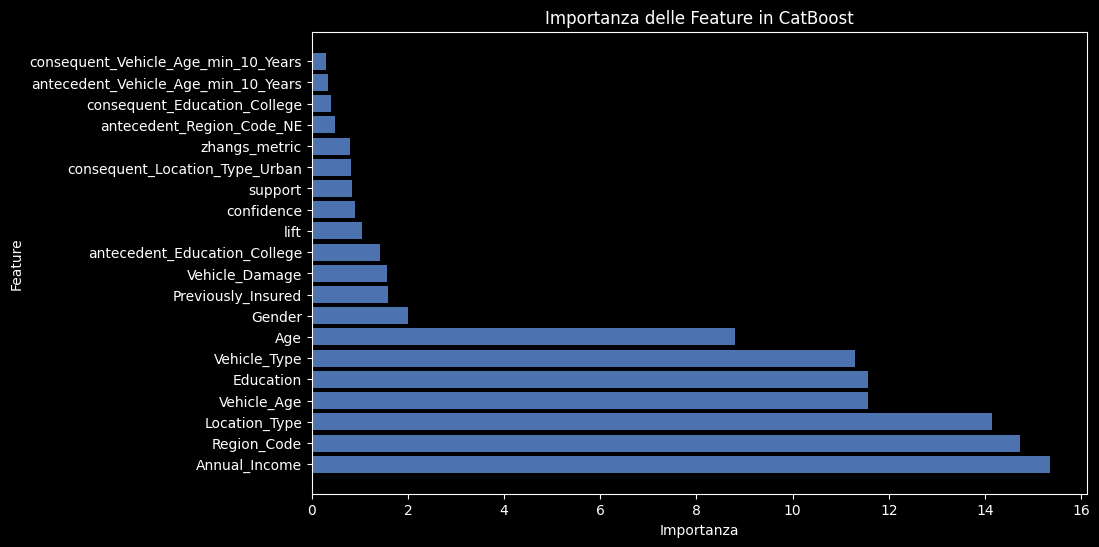

In [170]:
# Si crea un DataFrame con le importanze delle feature
feature_importances_catboost = {
    'Feature': [
        'Annual_Income', 'Region_Code', 'Location_Type', 'Vehicle_Age', 'Education',
        'Vehicle_Type', 'Age', 'Gender', 'Previously_Insured', 'Vehicle_Damage',
        'antecedent_Education_College', 'lift', 'confidence', 'support',
        'consequent_Location_Type_Urban', 'zhangs_metric', 'antecedent_Region_Code_NE',
        'consequent_Education_College', 'antecedent_Vehicle_Age_min_10_Years',
        'consequent_Vehicle_Age_min_10_Years'
    ],
    'Importance': [
        15.351039, 14.736739, 14.149584, 11.577537, 11.577270,
        11.300886, 8.806529, 2.010655, 1.584547, 1.568565,
        1.412474, 1.049591, 0.907324, 0.826360, 0.825298,
        0.788043, 0.487739, 0.400024, 0.334070, 0.305725
    ]
}

# Convertiamo in DataFrame
df = pd.DataFrame(feature_importances_catboost)

# Stabilire come fattore di soglia per la selezione delle feature la media
# threshold = df['Importance'].mean()
threshold = df['Importance'].mean() * 0.6

# Selezioniamo le feature sopra la soglia
selected_cat_feature = df[df['Importance'] > threshold]

print("Feature selezionate:")
print(selected_cat_feature)


Feature selezionate:
         Feature  Importance
0  Annual_Income   15.351039
1    Region_Code   14.736739
2  Location_Type   14.149584
3    Vehicle_Age   11.577537
4      Education   11.577270
5   Vehicle_Type   11.300886
6            Age    8.806529


#### Feature importanti per GBM Classifier, LightGBM e XGBoost

In [171]:
combined_importance_df = pd.DataFrame({
    'Feature': X_apriori_train.columns,
    'GBM Importance': feature_importance_gbm_df_sorted['Importance'].values,
    'LightGBM Importance': feature_importance_lgb_df_sorted['Importance'].values,
    'XGBoost Importance': feature_importance_xgb_df_sorted['Importance'].values,
})

Per facilitare il confronto,  le importanze si normalizzano in modo che ciascuna colonna rappresenti valori compresi tra 0 e 1.

In [172]:
# Normalizza le importanze
normalized_importance_df = combined_importance_df.copy()
for model in ['GBM Importance', 'LightGBM Importance', 'XGBoost Importance']:
    normalized_importance_df[model] = normalized_importance_df[model] / normalized_importance_df[model].sum()

In [173]:
# Calcola la media dell'importanza normalizzata
normalized_importance_df['Mean Importance'] = normalized_importance_df[['GBM Importance', 
                                                                        'LightGBM Importance', 
                                                                        'XGBoost Importance']].mean(axis=1)

In [174]:
# Ordina per importanza media
final_ranking = normalized_importance_df.sort_values(by='Mean Importance', ascending=False)
print(final_ranking[['Feature', 'Mean Importance']])

                                Feature  Mean Importance
0                           Gender_Male     4.538011e-01
1                                   Age     1.732040e-01
2                         Annual_Income     5.308789e-02
3                    Previously_Insured     4.510332e-02
4                        Vehicle_Damage     3.861794e-02
5                        Region_Code_NE     2.854313e-02
6                         Region_Code_W     2.701359e-02
7                         Region_Code_S     2.333522e-02
8                        Region_Code_MW     2.208872e-02
9                   Location_Type_Urban     1.815799e-02
10               Location_Type_Suburban     1.682854e-02
11                  Location_Type_Rural     1.570483e-02
12              Vehicle_Type_Luxury SUV     1.367032e-02
13              Vehicle_Type_Luxury Car     1.308052e-02
14                     Vehicle_Type_SUV     1.204248e-02
15              Vehicle_Type_Normal Car     1.100132e-02
16                     Educatio

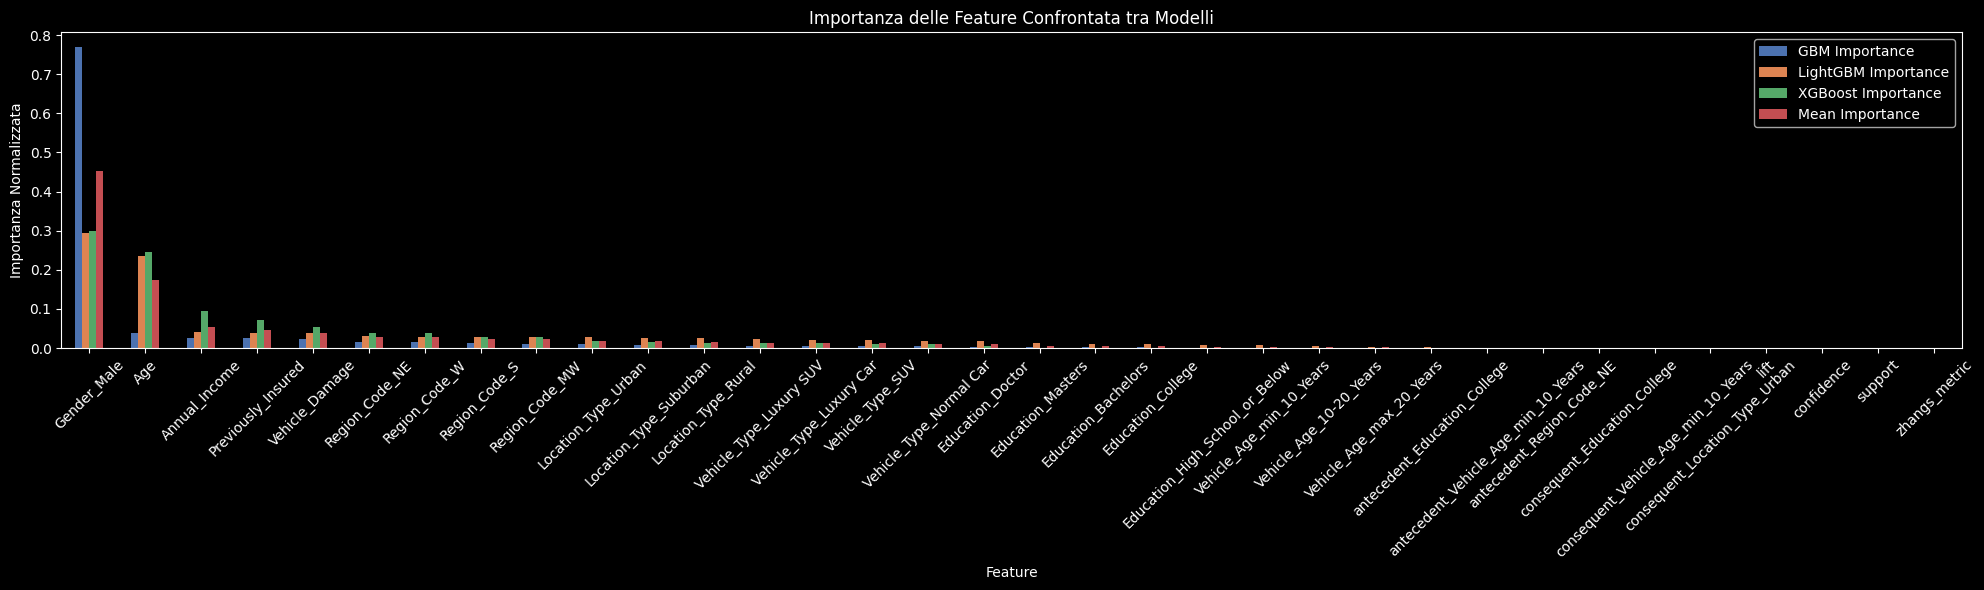

In [175]:
# Grafico a barre dell'importanza media
final_ranking.set_index('Feature').plot(kind='bar', figsize=(20, 6))
plt.title('Importanza delle Feature Confrontata tra Modelli')
plt.ylabel('Importanza Normalizzata')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Feature selezionate:
               Feature  Mean Importance
0          Gender_Male         0.453801
1                  Age         0.173204
2        Annual_Income         0.053088
3   Previously_Insured         0.045103
4       Vehicle_Damage         0.038618
5       Region_Code_NE         0.028543
6        Region_Code_W         0.027014
7        Region_Code_S         0.023335
8       Region_Code_MW         0.022089
9  Location_Type_Urban         0.018158


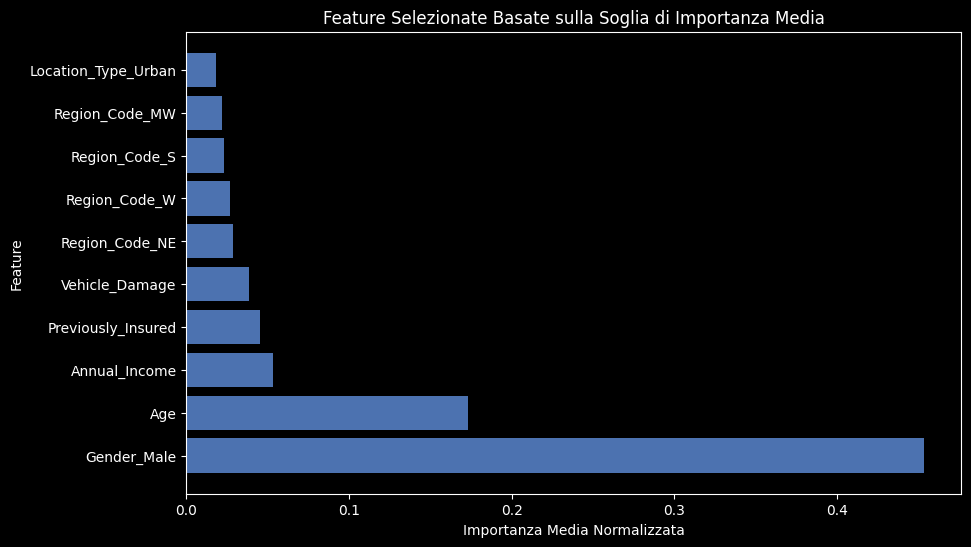

In [176]:
# Calcola la soglia come la media dell'importanza
mean_importance = final_ranking['Mean Importance'].mean()

# Imposta una soglia (puoi anche usare una percentuale della media)
# threshold = mean_importance  # Soglia fissa
threshold = mean_importance * 0.6 # Soglia al 60% della media

# Filtra le feature che superano la soglia
selected_std_feature = final_ranking[final_ranking['Mean Importance'] > threshold]

print("Feature selezionate:")
print(selected_std_feature[['Feature', 'Mean Importance']])

# Visualizzazione delle feature selezionate
plt.figure(figsize=(10, 6))
plt.barh(selected_std_feature['Feature'], selected_std_feature['Mean Importance'])
plt.title('Feature Selezionate Basate sulla Soglia di Importanza Media')
plt.xlabel('Importanza Media Normalizzata')
plt.ylabel('Feature')
plt.show()

### Consolidare le feature selezionate

#### df_apriori_train --> df_std_selected_train

In [177]:
#Data la lista di feature selezionate
selected_std_features = ['Gender_Male', 'Age', 'Annual_Income', 'Previously_Insured', 'Vehicle_Damage', 'Region_Code_NE', 'Region_Code_W', 'Region_Code_S', 'Region_Code_MW','Location_Type_Urban']

In [178]:
# si crea un sottoinsieme di dati basandosi sulla selezione delle feature più importanti per ogni modello
df_std_selected_train = df_apriori_train[selected_std_features + ['Policy']]  # Aggiungi la variabile target

#### df_cat_apriori_train --> df_cat_selected_train

In [179]:
selected_cat_feature

,Feature,Importance
0,Annual_Income,15.351039
1,Region_Code,14.736739
2,Location_Type,14.149584
3,Vehicle_Age,11.577537
4,Education,11.577270
5,Vehicle_Type,11.300886
6,Age,8.806529


In [180]:
#Data la lista di feature selezionate
selected_cat_features = ['Annual_Income', 'Region_Code', 'Location_Type', 'Vehicle_Age', 'Education', 'Vehicle_Type', 'Age']

In [181]:
# si crea un sottoinsieme di dati basandosi sulla selezione delle feature più importanti per ogni modello
df_cat_selected_train = df_cat_apriori_train[selected_cat_features + ['Policy']]  # Aggiungi la variabile target

#### Validazione delle feature selezionate

##### Modelli boosting addestrati sui modelli ridotti

In [182]:
# Separare le feature dal target
X_selected = df_std_selected_train.drop('Policy', axis=1)
y_selected = df_std_selected_train['Policy']

# Suddividere il dataset in training e test set
X_selected_train, X_selected_valid, y_selected_train, y_selected_valid = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)

In [183]:
# Separare le feature dal target
X_cat_selected = df_cat_selected_train.drop('Policy', axis=1)
y_cat_selected = df_cat_selected_train['Policy']

# Suddividere il dataset in training e test set
X_cat_selected_train, X_cat_selected_valid, y_cat_selected_train, y_cat_selected_valid = train_test_split(X_cat_selected, y_cat_selected, test_size=0.2, random_state=42)

In [184]:
# Si calcolano i pesi delle classi
sample_weight_selected = compute_sample_weight('balanced', y_selected_train)

# Si inizializzia un classificatore GBM
model_gbm_reduced = GradientBoostingClassifier(random_state=42)
model_gbm_reduced.fit(X_selected_train, y_selected_train, sample_weight=sample_weight_selected)

# Si inizializza un classificatore XGBoost
model_xgb_reduced = xgb.XGBClassifier(random_state=42)
model_xgb_reduced.fit(X_selected_train, y_selected_train, sample_weight=sample_weight_selected)

# Si inizializza un classificatore LightGBM
model_lgb_reduced = lgb.LGBMClassifier(random_state=42, max_depth=5, n_estimators=10, learning_rate=0.1, force_col_wise=True, is_unbalance=True)
model_lgb_reduced.set_params(verbose=-1).fit(X_selected_train, y_selected_train)

LGBMClassifier(force_col_wise=True, is_unbalance=True, max_depth=5,
               n_estimators=10, random_state=42, verbose=-1)

```python
# Si inizializza un classificatore CatBoost
# Definisci i parametri
BATCH_SIZE = 10000  # Numero di campioni per batch - visto l'elevato costo computazione si addestra il modello un batch alla volta 
n_batches = (X_cat_selected_train.shape[0] + BATCH_SIZE - 1) // BATCH_SIZE  # Numero totale di batch
# Si inizializza il modello CatBoost
model_cat_reduced = CatBoostClassifier(
    random_seed=42,
    verbose=0,
    cat_features=[1, 2, 3, 4, 5],
    early_stopping_rounds=50,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    learning_rate=0.1,
    thread_count=8
)
# Addestra il modello in batch
for i in range(n_batches):
    # Calcola l'indice di partenza e fine per il batch
    start_idx = i * BATCH_SIZE
    end_idx = min((i + 1) * BATCH_SIZE, X_cat_selected_train.shape[0])
    
    # Seleziona il batch
    X_batch = X_cat_selected_train.iloc[start_idx:end_idx]
    y_batch = y_cat_selected_train[start_idx:end_idx]
    
    # Addestra il modello sul batch
    model_cat_reduced.fit(X_batch, y_batch, init_model=model_cat_reduced if i > 0 else None)
```

##### Confronto dei modelli con tutte le feature

```python
# F1-score ponderato dei modelli boosting addestrati su tutte le feature

# Generazione delle previsioni per ciascun modello
y_pred_gbm = model_gbm.predict(X_apriori_valid)
y_pred_lgb = model_lgb.predict(X_apriori_valid)
y_pred_xgb = model_xgb.predict(X_apriori_valid)
y_pred_cat = model_cat.predict(X_cat_apriori_valid)

# Calcolo degli F1-score ponderati
f1_gbm = f1_score(y_apriori_valid, y_pred_gbm, average='weighted')
f1_lgb = f1_score(y_apriori_valid, y_pred_lgb, average='weighted') # type: ignore
f1_xgb = f1_score(y_apriori_valid, y_pred_xgb, average='weighted')
f1_cat = f1_score(y_cat_apriori_valid, y_pred_cat, average='weighted')

# Memorizzazione dei risultati in un dizionario
f1_scores = {
    'model_gbm': f1_gbm,
    'model_lgb': f1_lgb,
    'model_xgb': f1_xgb,
    'model_cat': f1_cat
}

# Stampa degli F1-score per ciascun modello
for model, score in f1_scores.items():
    print(f'F1-score for {model}: {score:.4f}')
```
Output:

- F1-score for model_gbm: 0.9888
- F1-score for model_lgb: 0.9936
- F1-score for model_xgb: 0.9923
- F1-score for model_cat: 0.9906

##### Confrondo dei modelli con il set ridotto

```python
# F1-score ponderato dei modelli boosting addestrati su set ridotto

# Generazione delle previsioni per ciascun modello
y_pred_gbm_reduced = model_gbm_reduced.predict(X_selected_valid)
y_pred_lgb_reduced = model_lgb_reduced.predict(X_selected_valid)
y_pred_xgb_reduced = model_xgb_reduced.predict(X_selected_valid)
y_pred_cat_reduced = model_cat_reduced.predict(X_cat_selected_valid)

# Calcolo degli F1-score ponderati
f1_gbm_reduced = f1_score(y_selected_valid, y_pred_gbm_reduced, average='weighted')
f1_lgb_reduced = f1_score(y_selected_valid, y_pred_lgb_reduced, average='weighted') # type: ignore
f1_xgb_reduced = f1_score(y_selected_valid, y_pred_xgb_reduced, average='weighted')
f1_cat_reduced = f1_score(y_cat_selected_valid, y_pred_cat_reduced, average='weighted')

# Memorizzazione dei risultati in un dizionario
f1_scores = {
    'model_gbm_reduced': f1_gbm_reduced,
    'model_lgb_reduced': f1_lgb_reduced,
    'model_xgb_reduced': f1_xgb_reduced,
    'model_cat_reduced': f1_cat_reduced
}

# Stampa degli F1-score per ciascun modello
for model, score in f1_scores.items():
    print(f'F1-score for {model}: {score:.4f}')
```
Output:

- F1-score for model_gbm_reduced: 0.9168
- F1-score for model_lgb_reduced: 0.9077
- F1-score for model_xgb_reduced: 0.9193
- F1-score for model_cat_reduced: 0.9151

## Boosting Techniques

### Scelta del Modello Ibrido per Raccomandazione di Polizze

L'obiettivo del progetto è raccomandare la miglior polizza assicurativa ad un cliente. Per raggiungere questo scopo, si propone di utilizzare un metodo ibrido di raccomandazione che combina l'algoritmo **Apriori** con uno dei modelli di boosting: **XGBoost**, **GBM Classifier**, **LightGBM** o **CatBoost**.

#### Criteri di Scelta

1. **Accuratezza delle Raccomandazioni**: È fondamentale che il modello scelto fornisca raccomandazioni accurate e pertinenti. Gli F1-score ottenuti dai vari modelli quantifica la loro capacità di fare previsioni corrette.

2. **Gestione delle Variabili Categoriali**: Le polizze possono avere caratteristiche categoriali, quindi è importante scegliere un modello in grado di gestire efficacemente queste variabili:
   - CatBoost: Gestione nativa delle variabili categoriali senza necessità di pre-elaborazione.
   - LightGBM: Richiede encoding delle variabili categoriche ma gestisce bene le classi non bilanciate.
   - XGBoost: Necessita di encoding manuale delle variabili categoriche.
   - GBM Classifier: Richiede encoding e potrebbe non gestire bene le classi non bilanciate senza tuning.

3. **Velocità di Addestramento e Inferenza**: La rapidità con cui il modello può essere addestrato e fornire raccomandazioni è cruciale in un contesto commerciale. Modelli più veloci possono migliorare l'esperienza dell'utente:
   - LightGBM: Estremamente veloce e scalabile, ideale per grandi dataset.
   - CatBoost: Veloce ma richiede più tempo rispetto a LightGBM.
   - XGBoost: Più lento rispetto a LightGBM ma offre ottime prestazioni su dataset più piccoli.
   - GBM Classifier: Può avere tempi di addestramento più lunghi rispetto agli altri modelli.

4. **Overfitting**: Come osservato i modelli mostrano buone capacità di generalizzazione sul set di validazione, ma potrebbero essere suscettibili all'overfitting se non vengono gestiti correttamente.

#### Confronto Tecnico

| Caratteristica          | **XGBoost**         | **LightGBM**          | **CatBoost**         | **GBM Classifier**   |
|-------------------------|---------------------|-----------------------|----------------------|-----------------------|
| Velocità di addestramento| Moderata            | Molto veloce          | Veloce (più lento di LightGBM) | Moderata               |
| Gestione feature categoriche | Richiede encoding | Richiede encoding     | Nativo               | Richiede encoding      |
| Performance su classi sbilanciate | Buona con tuning | Buona con `is_unbalance` | Ottima, senza tuning complesso | Elevata                |
| Robustezza               | Elevata             | Elevata               | Molto robusto        | Elevata                |
| Complessità tuning       | Moderata-alta       | Moderata              | Bassa                | Alta                   |

Combinando l'algoritmo Apriori per identificare pattern utili e uno dei modelli di boosting per fare previsioni precise, si può creare un sistema di raccomandazione potente e ben bilanciato, capace di soddisfare le esigenze sia del cliente che dell'assicuratore.

Citations:
[1] https://www.geeksforgeeks.org/how-to-tune-hyperparameters-in-gradient-boosting-algorithm/
[2] https://www.mdpi.com/2227-9091/12/4/62
[3] https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm-faq/tuning_a_gbm.html
[4] https://aiml.com/what-are-the-key-hyper-parameters-for-a-gbm-model/
[5] https://academic.oup.com/nargab/article/6/3/lqae079/7710900
[6] https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm
[7] https://www.linkedin.com/pulse/comparing-catboost-xgboost-lightgbm-algorithms-9ayme
[8] https://topepo.github.io/caret/model-training-and-tuning.html

## Valutazione di overfitting dei modelli boosting

### XGBoost su set intero e ridotto

#### Set intero

In [185]:
# Previsione sul set di addestramento, validation e test di XGBoost
y_train_pred = model_xgb.predict(X_apriori_train)
y_valid_pred = model_xgb.predict(X_apriori_valid)
y_test_pred = model_xgb.predict(df_std_test.drop('Policy', axis=1))

# Calcoliamo le metriche di prestazione
train_accuracy = accuracy_score(y_apriori_train, y_train_pred)
validation_accuracy = accuracy_score(y_apriori_valid, y_valid_pred)
test_accuracy = accuracy_score(df_std_test['Policy'], y_test_pred)

# Stampa dei risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Valutazione dell'overfitting sul set di validazione
if train_accuracy - validation_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene.")

    # Valutazione dell'overfitting sul set di test
if train_accuracy - test_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene.")

Train Accuracy: 0.9958
Validation Accuracy: 0.9923
Test Accuracy: 0.0173
Il modello sembra generalizzare bene.
Il modello potrebbe soffrire di overfitting.


#### Set ridotto

In [186]:
# Previsione sul set di addestramento, validation e test di XGBoost
y_train_pred = model_xgb_reduced.predict(X_selected_train)
y_valid_pred = model_xgb_reduced.predict(X_selected_valid)
drop_df_std_test = df_std_test.drop('Policy', axis=1)
y_test_pred = model_xgb_reduced.predict(drop_df_std_test[['Gender_Male', 'Age', 'Annual_Income', 
                                                    'Previously_Insured', 'Vehicle_Damage', 
                                                   'Region_Code_NE', 'Region_Code_W', 
                                                  'Region_Code_S', 'Region_Code_MW', 'Location_Type_Urban']])

# Calcoliamo le metriche di prestazione
train_accuracy = accuracy_score(y_selected_train, y_train_pred)
validation_accuracy = accuracy_score(y_selected_valid, y_valid_pred)
test_accuracy = accuracy_score(df_std_test['Policy'], y_test_pred)

# Stampa dei risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Valutazione dell'overfitting sul set di validazione
if train_accuracy - validation_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene.")

    # Valutazione dell'overfitting sul set di test
if train_accuracy - test_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene.")

Train Accuracy: 0.9250
Validation Accuracy: 0.9192
Test Accuracy: 0.0414
Il modello sembra generalizzare bene.
Il modello potrebbe soffrire di overfitting.


### GBM Classifier su set intero e ridotto

#### set intero

In [187]:
# Previsione sul set di addestramento, validazione e test di GBM Classifier
y_train_pred = model_gbm.predict(X_apriori_train)
y_valid_pred = model_gbm.predict(X_apriori_valid)
y_test_pred = model_gbm.predict(df_std_test.drop('Policy', axis=1))

# Calcoliamo le metriche di prestazione
train_accuracy = accuracy_score(y_apriori_train, y_train_pred)
validation_accuracy = accuracy_score(y_apriori_valid, y_valid_pred)
test_accuracy = accuracy_score(df_std_test['Policy'], y_test_pred)

# Stampa dei risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Valutazione dell'overfitting sul set di validation
if train_accuracy - validation_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene.")

# Valutazione dell'overfitting sul set di test
if train_accuracy - test_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene.")

Train Accuracy: 0.9893
Validation Accuracy: 0.9889
Test Accuracy: 0.0184
Il modello sembra generalizzare bene.
Il modello potrebbe soffrire di overfitting.


#### set ridotto

In [188]:
# Previsione sul set di addestramento, validazione e test di GBM Classifier
y_train_pred = model_gbm_reduced.predict(X_selected_train)
y_valid_pred = model_gbm_reduced.predict(X_selected_valid)
drop_df_std_test = df_std_test.drop('Policy', axis=1)
y_test_pred = model_gbm_reduced.predict(drop_df_std_test[['Gender_Male', 'Age', 'Annual_Income', 
                                                    'Previously_Insured', 'Vehicle_Damage', 
                                                   'Region_Code_NE', 'Region_Code_W', 
                                                  'Region_Code_S', 'Region_Code_MW', 'Location_Type_Urban']])

# Calcoliamo le metriche di prestazione
train_accuracy = accuracy_score(y_selected_train, y_train_pred)
validation_accuracy = accuracy_score(y_selected_valid, y_valid_pred)
test_accuracy = accuracy_score(df_std_test['Policy'], y_test_pred)

# Stampa dei risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Valutazione dell'overfitting
if train_accuracy - validation_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene.")

# Valutazione dell'overfitting sul set di test
if train_accuracy - test_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene.")

Train Accuracy: 0.9182
Validation Accuracy: 0.9167
Test Accuracy: 0.0414
Il modello sembra generalizzare bene.
Il modello potrebbe soffrire di overfitting.


### CatBoost su set ridotto e intero

#### set intero

```python
# Si addestra il modello CatBoost su set intero
# Definisci i parametri
BATCH_SIZE = 10000  # Numero di campioni per batch - visto l'elevato costo computazione si addestra il modello un batch alla volta 
n_batches = (X_cat_apriori_train.shape[0] + BATCH_SIZE - 1) // BATCH_SIZE  # Numero totale di batch

# Inizializza il modello
model_cat = CatBoostClassifier(
    random_seed=42,
    verbose=0,
    cat_features=[0, 1, 2, 3, 4, 5, 6, 7],
    early_stopping_rounds=50,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    learning_rate=0.1,
    thread_count=8
)

# Addestra il modello in batch
for i in range(n_batches):
    # Calcola l'indice di partenza e fine per il batch
    start_idx = i * BATCH_SIZE
    end_idx = min((i + 1) * BATCH_SIZE, X_cat_apriori_train.shape[0])
    
    # Seleziona il batch
    X_batch = X_cat_apriori_train.iloc[start_idx:end_idx]
    y_batch = y_cat_apriori_train[start_idx:end_idx]
    
    # Addestra il modello sul batch
    model_cat.fit(X_batch, y_batch, init_model=model_cat if i > 0 else None)
```

```python
# Previsione sul set di addestramento, validazione e test di CatBoost
y_train_pred = model_cat.predict(X_cat_apriori_train)
y_valid_pred = model_cat.predict(X_cat_apriori_valid)
y_test_pred = model_cat.predict(df_cat_test.drop('Policy', axis=1))

# Calcoliamo le metriche di prestazione
train_accuracy = accuracy_score(y_cat_apriori_train, y_train_pred)
validation_accuracy = accuracy_score(y_cat_apriori_valid, y_valid_pred)
test_accuracy = accuracy_score(df_cat_test['Policy'], y_test_pred)

# Stampa dei risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Valutazione dell'overfitting sul set di validazione
if train_accuracy - validation_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene.")

# Valutazione dell'overfitting sul set di test
if train_accuracy - test_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene.")

Output:

- Train Accuracy: 0.9913
- Validation Accuracy: 0.9906
- Test Accuracy: 0.9682
- Il modello sembra generalizzare bene.
- Il modello sembra generalizzare bene.
```

#### set ridotto

```python
# Si inizializza un classificatore CatBoost
# Definisci i parametri
BATCH_SIZE = 10000  # Numero di campioni per batch - visto l'elevato costo computazione si addestra il modello un batch alla volta 
n_batches = (X_cat_selected_train.shape[0] + BATCH_SIZE - 1) // BATCH_SIZE  # Numero totale di batch
# Si inizializza il modello CatBoost
model_cat_reduced = CatBoostClassifier(
    random_seed=42,
    verbose=0,
    cat_features=[1, 2, 3, 4, 5],
    early_stopping_rounds=50,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    learning_rate=0.1,
    thread_count=8
)
# Addestra il modello in batch
for i in range(n_batches):
    # Calcola l'indice di partenza e fine per il batch
    start_idx = i * BATCH_SIZE
    end_idx = min((i + 1) * BATCH_SIZE, X_cat_selected_train.shape[0])
    
    # Seleziona il batch
    X_batch = X_cat_selected_train.iloc[start_idx:end_idx]
    y_batch = y_cat_selected_train[start_idx:end_idx]
    
    # Addestra il modello sul batch
    model_cat_reduced.fit(X_batch, y_batch, init_model=model_cat_reduced if i > 0 else None)

drop_df_cat_test = df_cat_test.drop('Policy', axis=1)

# Previsione sul set di addestramento, validazione e test di CatBoost
y_train_pred = model_cat_reduced.predict(X_cat_selected_train)
y_valid_pred = model_cat_reduced.predict(X_cat_selected_valid)
y_test_pred = model_cat_reduced.predict(df_cat_test[['Annual_Income', 'Region_Code', 'Location_Type', 'Vehicle_Age', 'Education', 'Vehicle_Type', 'Age']])

# Calcoliamo le metriche di prestazione
train_accuracy = accuracy_score(y_cat_selected_train, y_train_pred)
validation_accuracy = accuracy_score(y_cat_selected_valid, y_valid_pred)
test_accuracy = accuracy_score(df_cat_test['Policy'], y_test_pred)

# Stampa dei risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Valutazione dell'overfitting sul set di validazione
if train_accuracy - validation_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene sul set di validazione.")

# Valutazione dell'overfitting sul set di test
if train_accuracy - test_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene sul set di test.")

Output:

- Train Accuracy: 0.9157
- Validation Accuracy: 0.9154
- Test Accuracy: 0.8980
- Il modello sembra generalizzare bene sul set di validazione.
- Il modello sembra generalizzare bene sul set di test.
```

### LightGBM su set intero e ridotto

#### set intero

In [189]:
# Previsione sul set di addestramento, validazione e test di LightGBM
y_train_pred = model_lgb.predict(X_apriori_train)
y_valid_pred = model_lgb.predict(X_apriori_valid)
y_test_pred = model_lgb.predict(df_std_test.drop('Policy', axis=1))

# Calcoliamo le metriche di prestazione
train_accuracy = accuracy_score(y_apriori_train, y_train_pred) # type: ignore
validation_accuracy = accuracy_score(y_apriori_valid, y_valid_pred) # type: ignore
test_accuracy = accuracy_score(df_std_test['Policy'], y_test_pred) # type: ignore

# Stampa dei risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Valutazione dell'overfitting sul set di validation
if train_accuracy - validation_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene.")

# Valutazione dell'overfitting sul set di test
if train_accuracy - test_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene.")

Train Accuracy: 0.9959
Validation Accuracy: 0.9936
Test Accuracy: 0.0170
Il modello sembra generalizzare bene.
Il modello potrebbe soffrire di overfitting.


#### set ridotto

In [190]:
# Previsione sul set di addestramento, validazione e test di LightGBM
y_train_pred = model_lgb_reduced.predict(X_selected_train)
y_valid_pred = model_lgb_reduced.predict(X_selected_valid)
drop_df_std_test = df_std_test.drop('Policy', axis=1)
y_test_pred = model_lgb_reduced.predict(drop_df_std_test[['Gender_Male', 'Age', 'Annual_Income', 
                                                    'Previously_Insured', 'Vehicle_Damage', 
                                                   'Region_Code_NE', 'Region_Code_W', 
                                                  'Region_Code_S', 'Region_Code_MW', 'Location_Type_Urban']])

# Calcoliamo le metriche di prestazione
train_accuracy = accuracy_score(y_selected_train, y_train_pred) # type: ignore
validation_accuracy = accuracy_score(y_selected_valid, y_valid_pred) # type: ignore
test_accuracy = accuracy_score(df_std_test['Policy'], y_test_pred) # type: ignore

# Stampa dei risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Valutazione dell'overfitting sul set di validation
if train_accuracy - validation_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene.")

# Valutazione dell'overfitting sul set di test
if train_accuracy - test_accuracy > 0.1:  
    print("Il modello potrebbe soffrire di overfitting.")
else:
    print("Il modello sembra generalizzare bene.")

Train Accuracy: 0.9093
Validation Accuracy: 0.9076
Test Accuracy: 0.0430
Il modello sembra generalizzare bene.
Il modello potrebbe soffrire di overfitting.


### Analisi degli output

l modello CatBoost ha raggiunto un'elevata accuratezza sui dati di addestramento, validazione e test, suggerendo che è in grado di generalizzare efficacemente su nuovi dati. D'altro canto, i modelli XGBoost, LightGBM e GBM Classifier mostrano una buona accuratezza sui dati di addestramento e validazione, ma una bassissima accuratezza sui dati di test, il che è un chiaro indicatore di overfitting.

L'overfitting si manifesta quando il modello apprende troppo bene i dettagli (o il rumore) dei dati di addestramento e validazione, ma fallisce nel generalizzare su dati mai visti, come quelli di test.

La robustezza del modello CatBoost rispetto agli altri potrebbe essere dovuta a una sua migliore gestione dei parametri o della struttura dei dati, o semplicemente a una maggiore resilienza al rumore dei dati. CatBoost gestisce in modo nativo la categorical encoding e la stratificazione, il che potrebbe averlo avvantaggiato rispetto agli altri modelli.

Il modello CatBoost sembra essere la scelta migliore in questo contesto, data la sua capacità di mantenere buone performance su tutti i set di dati. 

## Metriche e matrice di confusione del modello CatBoost

### Modello su set intero

```python
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Predizioni con i modelli model_cat
y_test_pred = model_cat.predict(df_cat_test.drop('Policy', axis=1))


# Matrice di confusione per model_cat
conf_matrix_cat = confusion_matrix(df_cat_test['Policy'], y_test_pred)
print("Matrice di confusione per model_cat:\n", conf_matrix_cat)

# Precision, recall e F1-score ponderato per model_cat
precision_cat = precision_score(df_cat_test['Policy'], y_test_pred, average='weighted')
recall_cat = recall_score(df_cat_test['Policy'], y_test_pred, average='weighted')
f1_cat = f1_score(df_cat_test['Policy'], y_test_pred, average='weighted')

print("\nMetriche per model_cat:")
print(f"Precision (weighted): {precision_cat}")
print(f"Recall (weighted): {recall_cat}")
print(f"F1-score (weighted): {f1_cat}")


Matrice di confusione per model_cat:
 [[18907     0     0     0     0     0    11]
 [    0 11568   442    12   452     3     0]
 [    0   694 12813     0     0   168   190]
 [    0     1     0 10663    23     0     0]
 [    0     4     0   318 10572     0     0]
 [   19   298   138     0     0 15913   210]
 [   64     0   150     0     0    33 17964]]

Metriche per model_cat:
Precision (weighted): 0.968252862473921
Recall (weighted): 0.9682180458526026
F1-score (weighted): 0.9681550308372979

```

### Modello sul set ridotto

```python
# Predizioni con il modello model_cat_reduced
y_pred_cat_reduced = model_cat_reduced.predict(df_cat_test[['Annual_Income', 'Region_Code', 
'Location_Type', 'Vehicle_Age', 'Education', 'Vehicle_Type', 'Age']])

# Matrice di confusione per model_cat_reduced
conf_matrix_cat_reduced = confusion_matrix(df_cat_test['Policy'], y_pred_cat_reduced)
print("\nMatrice di confusione per model_cat_reduced:\n", conf_matrix_cat_reduced)

# Precision, recall e F1-score ponderato per model_cat_reduced
precision_cat_reduced = precision_score(df_cat_test['Policy'], y_pred_cat_reduced, average='weighted')
recall_cat_reduced = recall_score(df_cat_test['Policy'], y_pred_cat_reduced, average='weighted')
f1_cat_reduced = f1_score(df_cat_test['Policy'], y_pred_cat_reduced, average='weighted')

print("\nMetriche per model_cat_reduced:")
print(f"Precision (weighted): {precision_cat_reduced}")
print(f"Recall (weighted): {recall_cat_reduced}")
print(f"F1-score (weighted): {f1_cat_reduced}")

Matrice di confusione per model_cat_reduced:
 [[18891     0     0     0     0     0    27]
 [    0 11207   774     1   487     5     3]
 [    0  1776  9986     0     0    85  2018]
 [    0   189     0  9553   945     0     0]
 [    0     8     2   754 10130     0     0]
 [   14   262   152     0     0 13573  2577]
 [  102     0   113     0     0    77 17919]]

Metriche per model_cat_reduced:
Precision (weighted): 0.9058495344768593
Recall (weighted): 0.8979533602282791
F1-score (weighted): 0.8971020237720376
```

### Interpretazione dei Risultati


L'analisi delle performance dei due modelli, `model_cat` e `model_cat_reduced`, evidenzia significative differenze in termini di precisione, recall e F1-score ponderato, nonché nella struttura delle matrici di confusione.

Matrice di Confusione

La matrice di confusione mostra come le predizioni dei modelli si confrontano con i valori reali delle classi. Le righe rappresentano le classi reali, mentre le colonne rappresentano le classi predette. La diagonale principale contiene il numero di osservazioni correttamente classificate per ciascuna classe.

- il modello con tutte le feature ha una matrice di confusione più "concentrata" sulla diagonale principale, suggerendo un'ottima capacità di classificare correttamente i dati in tutte le classi. Gli errori di classificazione, quando presenti, sono distribuiti in modo più contenuto.
  
- il modello con feature ridotte mostra più errori di classificazione fuori dalla diagonale principale, con una maggiore distribuzione di errori in classi vicine, come si vede nelle classi 2, 3 e 6. Ad esempio, si osserva che la classe 2 ha un numero significativo di errori di classificazione verso la classe 3, mentre la classe 3 ha molti errori verso la classe 6.

Questo suggerisce che la riduzione delle feature ha reso più difficile per il modello distinguere tra alcune classi, con conseguente peggioramento delle performance.

Metriche

1. Precision (weighted): La precision ponderata misura la capacità del modello di evitare falsi positivi, considerando le dimensioni di ciascuna classe. Nel modello completo si rileva un valore di 0.9682, indicante una bassa incidenza di falsi positivi. Nel modello ridotto, la precision scende a 0.9058, suggerendo una maggiore incidenza di predizioni errate.

2. Recall (weighted): Il recall ponderato misura la capacità del modello di catturare correttamente i positivi, sempre in funzione della distribuzione delle classi. Anche in questo caso, il modello completo ha un recall più elevato 0.9682 rispetto al modello ridotto 0.8979. Ciò significa che il modello completo è in grado di riconoscere una maggiore percentuale di osservazioni appartenenti alle classi reali rispetto al modello ridotto.

3. F1-score (weighted): L'F1-score ponderato rappresenta l'equilibrio tra precision e recall, ed è particolarmente utile quando le classi sono sbilanciate. Il modello completo ottiene un valore di 0.9682, molto superiore al modello ridotto che raggiunge 0.8971. Questo evidenzia che il modello completo mantiene un migliore compromesso tra evitare falsi positivi e catturare correttamente le classi rispetto al modello ridotto.


Il modello completo risulta essere il modello più performante. Esso mantiene un alto livello di accuratezza non solo sui dati di addestramento e validazione, ma anche sui dati di test, dimostrando di non soffrire di overfitting. La sua precisione, recall e F1-score sono tutti superiori a 0.96, suggerendo che il modello riesce a distinguere efficacemente tra le sette classi della variabile target "Polizza", prevedendo correttamente con pochissimi errori.

Il modello ridotto, al contrario, ha subito un deterioramento delle performance a seguito della riduzione delle feature. Sebbene abbia ancora buone prestazioni, con valori di precisione, recall e F1-score superiori a 0.89, risulta meno capace di distinguere accuratamente tra alcune classi rispetto al modello completo. In particolare, la matrice di confusione evidenzia una tendenza del modello ridotto a confondere alcune classi tra loro (es. classe 2 e classe 3, classe 3 e classe 6), il che influisce negativamente sulle sue metriche.

Il modello con tutte le feature è nettamente superiore nel prevedere la classe di polizza per un cliente, grazie alla sua capacità di mantenere alte performance su tutte le metriche chiave e su tutti i set di dati (addestramento, validazione e test). La riduzione delle feature nel modello ridotto ha compromesso le sue capacità predittive, portando a una diminuzione della precisione e dell'efficacia nel distinguere tra le classi, rendendolo meno affidabile per le predizioni.

## Tuning phase: Bayesian Optimization per la ricerca dei parametri dei modelli BOOSTING

Per valutare e ottimizzare i parametri iper dei modelli XGBoost, GBM Classifier e LightGBM è possibile utilizzare il metodo Bayesian Optimization della libreria optuna. Questo approccio permette di esplorare un ampio spazio di parametri per trovare la combinazione che offre le migliori prestazioni per il modello.

In [191]:
import optuna # type: ignore

#### Il metodo Bayesian Optimization

Il metodo Bayesian Optimization suggerisce i valori di iperparametri per il modello specifico attraverso le funzioni 'suggest_int' e 'suggest_float'.
- max_depth: profondità massima degli alberi decisionali nel modello in esame. I valori interi indicati sono i limiti inferiori e superiori; la funzione 'suggest_int' esplorerà valori interi compresi tra i limiti (essi stessi inclusi). La profondità massima degli alberi decisionali influisce sulla complessità del modello. Alberi più profondi possono catturare relazioni più complesse nei dati, ma possono anche portare a overfitting se la profondità è troppo alta. Limitare la profondità aiuta a controllare la complessità del modello.

- learning_rate: velocità di apprendimento del modello. I valori decimali indicati sono i limiti inferiori e superiori; la funzione 'suggest_float' esplorerà valori decimali compresi tra i limiti (essi stessi inclusi). Un learning rate più basso rende l'apprendimento più lento e può portare a un modello più robusto, ma richiede anche più iterazioni (cioè più alberi) per raggiungere buone prestazioni. Un learning rate troppo alto può portare a una convergenza rapida ma instabile, causando oscillazioni o addirittura divergenza.

- n_estimators: numero di alberi decisionali che il modello addestrerà. I valori interi indicati sono i limiti inferiori e superiori; la funzione 'suggest_int' esplorerà valori interi compresi tra i limiti (essi stessi inclusi). Un numero maggiore di alberi può migliorare le prestazioni del modello fino a un certo punto, ma aumenta anche il rischio di overfitting, specialmente se non si utilizza una regolarizzazione adeguata o se gli alberi sono molto profondi. D'altra parte, un numero troppo basso di alberi potrebbe non catturare sufficientemente le relazioni nei dati.

Questi parametri hanno un impatto significativo sulle prestazioni del modello e sulla sua capacità di generalizzare su dati non visti. L'ottimizzazione efficace di questi iperparametri può portare a modelli migliori e più robusti.

È possibile aggiungere altri parametri per migliorare le prestazioni e adattare i modelli al meglio al problema di classificazione in esame. Tra i parametri aggiuntivi che si considerano si evidenziano le tecniche di regolarizzazione.

La regolarizzazione è una tecnica utilizzata per prevenire l'overfitting, fenomeno in cui un modello si adatta troppo bene ai dati di addestramento, perdendo la capacità di generalizzare su dati nuovi. La regolarizzazione aggiunge un termine di penalità alla funzione di perdita del modello, incoraggiando il modello a mantenere i coefficienti (o pesi) più piccoli.

Regolarizzazione L1 (Lasso)

La regolarizzazione L1, conosciuta anche come Lasso (Least Absolute Shrinkage and Selection Operator), aggiunge un termine di penalità che è proporzionale alla somma dei valori assoluti dei coefficienti del modello.
La funzione di perdita con regolarizzazione L1 può essere espressa come:

Loss = Loss_original + lambda*∑|w_i|

Dove:
- Loss: La funzione di perdita totale.
- Loss_original: La funzione di perdita originale (ad esempio, la log-loss).
- λ (lambda): Il parametro di regolarizzazione che controlla l'intensità della penalità. Un valore più alto implica una maggiore penalità sui coefficienti.
- w_i: I coefficienti del modello per ciascuna variabile.
- n: Il numero totale di variabili nel modello.

La regolarizzazione L1 tende a produrre modelli *sparsi*, in cui alcuni coefficienti diventano esattamente zero. Questo significa che il modello ignora completamente alcune variabili, rendendolo più semplice e interpretabile.
Poiché può azzerare i coefficienti, la regolarizzazione L1 è utile per la *selezione delle caratteristiche*, permettendo di identificare e mantenere solo le variabili più rilevanti.
È particolarmente vantaggiosa in scenari con un alto numero di variabili, dove si desidera semplificare il modello e migliorare l'interpretabilità.

Regolarizzazione L2 (Ridge)

La regolarizzazione L2, nota anche come Ridge, aggiunge un termine di penalità che è proporzionale al quadrato dei coefficienti del modello.

La funzione di perdita con regolarizzazione L2 può essere espressa come:

Loss = Loss_original + lambda*∑w_i^2

Dove:
- Loss: La funzione di perdita totale.
- Loss_original: La funzione di perdita originale.
- λ (lambda): Il parametro di regolarizzazione che controlla l'intensità della penalità.
- w_i: I coefficienti del modello per ciascuna variabile.

La regolarizzazione L2 riduce i coefficienti verso zero ma non li azzera mai completamente. Questo porta a modelli più robusti, ma non necessariamente più semplici.
È utile quando ci sono molte variabili correlate, poiché tende a distribuire il peso su tutte le variabili piuttosto che concentrarsi solo su alcune. Questo aiuta a mitigare il problema della *multicollinearità*, dove due o più variabili indipendenti sono altamente correlate.
È spesso utilizzata in modelli lineari e regressioni quando si sospetta che molte variabili contribuiscano al risultato finale.

Differenze principali tra L1 e L2

| Caratteristica                | Regolarizzazione L1 (Lasso)             | Regolarizzazione L2 (Ridge)            |
|-------------------------------|-----------------------------------------|----------------------------------------|
| **Formula di penalità**       | Somma dei valori assoluti dei coefficienti | Somma dei quadrati dei coefficienti    |
| **Selezione delle caratteristiche** | Sì, può portare a coefficienti zero     | No, riduce i coefficienti ma non li azzera |
| **Sparsity**                  | Produce modelli sparsi                  | Produce modelli densi                  |
| **Impatto sui modelli**       | Modelli più semplici e interpretabili    | Modelli più robusti e generalizzati    |
| **Multicollinearità**         | Meno efficace nel gestire multicollinearità | Efficace nel gestire multicollinearità  |


La scelta tra regolarizzazione L1 e L2 dipende dal problema specifico e dalle caratteristiche del dataset. Se si desidera una selezione delle caratteristiche e interpretabilità, la regolarizzazione L1 è preferita. Se si sono  molte variabili correlate e si vuole un modello robusto senza eliminare completamente le variabili, la regolarizzazione L2 è più indicata. In alcuni casi, è possibile utilizzare entrambe le forme di regolarizzazione simultaneamente in una tecnica nota come Elastic Net, che combina i vantaggi di entrambe le metodologie.

#### Iperparametri per LightGBM

##### Modello completo

```python
# Si definisce la funzione obiettivo per LightGBM
def objective_lgb(trial):
    # Suggerimento dei parametri
    depth = trial.suggest_int('depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2)
    iterations = trial.suggest_int('iterations', 50, 150)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0, 5.0)  # Regolarizzazione L2 (Ridge)
    l1_leaf_reg = trial.suggest_float('l1_leaf_reg', 0, 5.0)   # Regolarizzazione L1 (Lasso)

    # Creazione del modello con i parametri suggeriti
    model_iper_lgb = lgb.LGBMClassifier(
        num_leaves=2**depth,
        learning_rate=learning_rate,
        n_estimators=iterations,
        reg_lambda=l2_leaf_reg,
        reg_alpha=l1_leaf_reg,
        objective='multiclass',
        metric='multi_logloss',
        random_state=42,
        is_unbalance=True)
    
    # Addestramento del modello
    model_iper_lgb.set_params(verbose=-1).fit(X_apriori_train, y_apriori_train)

    # Predizione sul set di validazione
    y_pred = model_iper_lgb.predict(X_apriori_valid)

    # Calcolo dei punteggi F1 ponderati
    
    return f1_score(y_apriori_valid, y_pred, average='weighted')
```

```python
# Esegui l'ottimizzazione per LightGBM
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=150)
```

Output:
[I 2024-10-24 16:16:28,606] A new study created in memory with name: no-name-ac7076da-2510-41d1-9432-6a01d2e511c4

- [I 2024-10-24 16:16:41,121] Trial 0 finished with value: 0.9935799210316576 and parameters: {'depth': 7, 'learning_rate': 0.0745731834678682, 'iterations': 146, 'l2_leaf_reg': 0.6473287713773557, 'l1_leaf_reg': 3.5268315035230486}. Best is trial 0 with value: 0.9935799210316576.

- [I 2024-10-24 16:16:55,708] Trial 1 finished with value: 0.9932479299133912 and parameters: {'depth': 7, 'learning_rate': 0.11698522367541417, 'iterations': 141, 'l2_leaf_reg': 0.7840296780172895, 'l1_leaf_reg': 4.139703937422286}. Best is trial 0 with value: 0.9935799210316576.

- ...

- [I 2024-10-24 16:34:50,774] Trial 118 finished with value: 0.9936895220435609 and parameters: {'depth': 4, 'learning_rate': 0.17884028702667942, 'iterations': 90, 'l2_leaf_reg': 2.736628262004802, 'l1_leaf_reg': 3.6333331750332993}. Best is trial 39 with value: 0.9938750502375441.

- [I 2024-10-24 16:34:59,924] Trial 119 finished with value: 0.9939240734059107 and parameters: {'depth': 4, 'learning_rate': 0.19716478138464077, 'iterations': 96, 'l2_leaf_reg': 3.191471327113045, 'l1_leaf_reg': 3.1142377314585628}. Best is trial 119 with value: 0.9939240734059107.

- [I 2024-10-24 16:35:10,520] Trial 120 finished with value: 0.9934076140105024 and parameters: {'depth': 7, 'learning_rate': 0.19652816449515007, 'iterations': 96, 'l2_leaf_reg': 3.128677734589322, 'l1_leaf_reg': 2.0032825633098486}. Best is trial 119 with value: 0.9939240734059107.

- ...

- [I 2024-10-24 16:39:21,779] Trial 148 finished with value: 0.9934325076119705 and parameters: {'depth': 6, 'learning_rate': 0.15176472132811628, 'iterations': 99, 'l2_leaf_reg': 2.803547582062515, 'l1_leaf_reg': 2.56646303110438}. Best is trial 119 with value: 0.9939240734059107.

- [I 2024-10-24 16:39:30,733] Trial 149 finished with value: 0.9937514188782043 and parameters: {'depth': 4, 'learning_rate': 0.18784070761599206, 'iterations': 96, 'l2_leaf_reg': 3.1037768675019386, 'l1_leaf_reg': 3.2773895366230312}. Best is trial 119 with value: 0.9939240734059107.

##### Modello ridotto

```python
# Si definisce la funzione obiettivo per LightGBM
def objective_lgb_reduced(trial):
    # Suggerimento dei parametri
    depth = trial.suggest_int('depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2)
    iterations = trial.suggest_int('iterations', 50, 150)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0, 5.0)  # Regolarizzazione L2 (Ridge)
    l1_leaf_reg = trial.suggest_float('l1_leaf_reg', 0, 5.0)   # Regolarizzazione L1 (Lasso)

    # Creazione del modello con i parametri suggeriti
    model_iper_lgb_reduced = lgb.LGBMClassifier(
        num_leaves=2**depth,
        learning_rate=learning_rate,
        n_estimators=iterations,
        reg_lambda=l2_leaf_reg,
        reg_alpha=l1_leaf_reg,
        objective='multiclass',
        metric='multi_logloss',
        random_state=42,
        is_unbalance=True)
    
    # Addestramento del modello
    model_iper_lgb_reduced.set_params(verbose=-1).fit(X_selected_train, y_selected_train)

    # Predizione sul set di validazione
    y_pred_reduced = model_iper_lgb_reduced.predict(X_selected_valid)

    # Calcolo dei punteggi F1 ponderati
    
    return f1_score(y_selected_valid, y_pred_reduced, average='weighted')
```

```python
# Esegui l'ottimizzazione per LightGBM
study_lgb_reduced = optuna.create_study(direction='maximize')
study_lgb_reduced.optimize(objective_lgb_reduced, n_trials=150) # type: ignore
```

Output:
[I 2024-10-24 17:07:13,443] A new study created in memory with name: no-name-2abebd8d-4a24-4da8-807d-7ae8cea75920

- [I 2024-10-24 17:07:22,254] Trial 0 finished with value: 0.921995432417007 and parameters: {'depth': 6, 'learning_rate': 0.17853432605721925, 'iterations': 85, 'l2_leaf_reg': 4.298873701504654, 'l1_leaf_reg': 4.125477936705324}. Best is trial 0 with value: 0.921995432417007.

- [I 2024-10-24 17:07:34,270] Trial 1 finished with value: 0.9218830209349133 and parameters: {'depth': 4, 'learning_rate': 0.1488500358350872, 'iterations': 149, 'l2_leaf_reg': 4.014457162744557, 'l1_leaf_reg': 0.3044042272284414}. Best is trial 0 with value: 0.921995432417007.

- [I 2024-10-24 17:07:41,948] Trial 2 finished with value: 0.9216353416631355 and parameters: {'depth': 6, 'learning_rate': 0.16460437789333154, 'iterations': 86, 'l2_leaf_reg': 2.3547579542747643, 'l1_leaf_reg': 0.6101590767382015}. Best is trial 0 with value: 0.921995432417007.

- ...

- [I 2024-10-24 17:33:33,447] Trial 147 finished with value: 0.9221711040840396 and parameters: {'depth': 4, 'learning_rate': 0.10617421284342925, 'iterations': 112, 'l2_leaf_reg': 0.5540130387578174, 'l1_leaf_reg': 2.302285435682365}. Best is trial 6 with value: 0.9223419821207671.

- [I 2024-10-24 17:33:42,429] Trial 148 finished with value: 0.9222786253914498 and parameters: {'depth': 4, 'learning_rate': 0.108272557980124, 'iterations': 111, 'l2_leaf_reg': 0.520101406409782, 'l1_leaf_reg': 2.305362441755108}. Best is trial 6 with value: 0.9223419821207671.

- [I 2024-10-24 17:33:52,112] Trial 149 finished with value: 0.9224599309787838 and parameters: {'depth': 4, 'learning_rate': 0.105540442642598, 'iterations': 111, 'l2_leaf_reg': 0.20828644694755322, 'l1_leaf_reg': 2.728576806543778}. Best is trial 149 with value: 0.9224599309787838.

#### Iperparametri per XGBoost

##### Modello completo

```python
def objective_xgb(trial):
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2)
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    alpha = trial.suggest_float('alpha', 0.0, 5.0)  # L1 regularization (Lasso)
    lambda_ = trial.suggest_float('lambda', 0.0, 5.0)  # L2 regularization (Ridge)

    model_iper_xgb = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators,
                              objective = 'multi:softmax', num_class = 7, eval_metric = 'mlogloss')
    model_iper_xgb.fit(X_apriori_train, y_apriori_train, sample_weight=sample_weight)
    
    y_pred = model_iper_xgb.predict(X_apriori_valid)
    return f1_score(y_apriori_valid, y_pred, average='weighted')
```

```python
# Si esegue l'ottimizzazione per XGBoost
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=150) # type: ignore
```

Output: 
[I 2024-10-24 16:39:30,774] A new study created in memory with name: no-name-f818ddf6-6f3d-4ace-ab4d-7f05765f4bef

- [I 2024-10-24 16:39:39,783] Trial 0 finished with value: 0.9748503631946134 and parameters: 
{'max_depth': 5, 'learning_rate': 0.09396520976754075, 'n_estimators': 58, 'alpha': 4.002700033940482, 'lambda': 4.041356116364858}. 
Best is trial 0 with value: 0.9748503631946134.

- ...

- [I 2024-10-24 17:04:41,430] Trial 134 finished with value: 0.9924117025687604 and parameters: 
{'max_depth': 7, 'learning_rate': 0.18165672745049694, 'n_estimators': 60, 'alpha': 3.940083227839016, 'lambda': 0.34845499920481626}. 
Best is trial 83 with value: 0.9925594726284473.

- [I 2024-10-24 17:04:49,910] Trial 135 finished with value: 0.9926331063692659 and parameters: 
{'max_depth': 7, 'learning_rate': 0.19464070620829496, 'n_estimators': 56, 'alpha': 3.831790957507251, 'lambda': 1.299912457194385}. 
Best is trial 135 with value: 0.9926331063692659.

- [I 2024-10-24 17:05:05,645] Trial 136 finished with value: 0.9924253102016287 and parameters: 
{'max_depth': 5, 'learning_rate': 0.1937499052676017, 'n_estimators': 107, 'alpha': 4.333705097578462, 'lambda': 1.3074564424182866}. 
Best is trial 135 with value: 0.9926331063692659.

- ...

- [I 2024-10-24 17:07:13,339] Trial 149 finished with value: 0.9925106317803859 and parameters: 
{'max_depth': 7, 'learning_rate': 0.19999642458016706, 'n_estimators': 71, 'alpha': 0.35757477677886756, 'lambda': 1.0724990077183483}. 
Best is trial 135 with value: 0.9926331063692659.

##### Modello ridotto

```python
def objective_xgb_reduced(trial):
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2)
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    alpha = trial.suggest_float('alpha', 0.0, 5.0)  # L1 regularization (Lasso)
    lambda_ = trial.suggest_float('lambda', 0.0, 5.0)  # L2 regularization (Ridge)

    model_iper_xgb_reduced = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators,
                              objective = 'multi:softmax', num_class = 7, eval_metric = 'mlogloss')
    model_iper_xgb_reduced.fit(X_selected_train, y_selected_train, sample_weight=sample_weight)
    
    y_pred_reduced = model_iper_xgb_reduced.predict(X_selected_valid)
    return f1_score(y_selected_valid, y_pred_reduced, average='weighted')
```

```python
# Esegui l'ottimizzazione per XGBoost
study_xgb_reduced = optuna.create_study(direction='maximize')
study_xgb_reduced.optimize(objective_xgb_reduced, n_trials=150) # type: ignore
```

Output:
[I 2024-10-24 17:49:39,755] A new study created in memory with name: no-name-94a2f7d6-e0bd-42ae-92f4-374f27fda69f

- [I 2024-10-24 17:49:46,881] Trial 0 finished with value: 0.9195316070884239 and parameters: {'max_depth': 6, 'learning_rate': 0.19740845721099365, 'n_estimators': 107, 'alpha': 3.169848623867164, 'lambda': 1.2617674711257332}. Best is trial 0 with value: 0.9195316070884239.

- ...

- [I 2024-10-24 18:00:29,686] Trial 58 finished with value: 0.9152363758298818 and parameters: {'max_depth': 4, 'learning_rate': 0.18865348241811636, 'n_estimators': 90, 'alpha': 0.8589046602149479, 'lambda': 0.4309237501271789}. Best is trial 43 with value: 0.9201866908037684.

- [I 2024-10-24 18:00:40,704] Trial 59 finished with value: 0.9202135216342991 and parameters: {'max_depth': 6, 'learning_rate': 0.1720077524879168, 'n_estimators': 129, 'alpha': 3.664147813388404, 'lambda': 1.5350110082775525}. Best is trial 59 with value: 0.9202135216342991.

- [I 2024-10-24 18:00:49,138] Trial 60 finished with value: 0.9189513203675189 and parameters: {'max_depth': 5, 'learning_rate': 0.16759265993700448, 'n_estimators': 105, 'alpha': 3.6790707712046276, 'lambda': 1.1468907473546834}. Best is trial 59 with value: 0.9202135216342991.

- ...

- [I 2024-10-24 18:17:57,193] Trial 148 finished with value: 0.9200216510427122 and parameters: {'max_depth': 6, 'learning_rate': 0.18253062314330734, 'n_estimators': 129, 'alpha': 4.177245701411461, 'lambda': 2.2884199940155847}. Best is trial 59 with value: 0.9202135216342991.

- [I 2024-10-24 18:18:07,565] Trial 149 finished with value: 0.9161158438653016 and parameters: {'max_depth': 4, 'learning_rate': 0.1805539539207426, 'n_estimators': 116, 'alpha': 4.068963806813006, 'lambda': 2.348628104435526}. Best is trial 59 with value: 0.9202135216342991.

#### Iperparametri per GBM Classifier

##### Modello completo

```python
# Si definisce la funzione obiettivo per GBM Classifier
def objective_gbm(trial):
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2)
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10) # controlla il numero minimo di campioni richiesti per effettuare una divisione in un nodo
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)   # controlla il numero minimo di campioni richiesti per essere una foglia
    subsample = trial.suggest_float('subsample', 0.5, 1.0) # specifica la frazione dei campioni da utilizzare per addestrare ogni albero. Un valore inferiore a 1.0 introduce variabilità e può aiutare a ridurre l'overfitting

    model_iper_gbm = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, 
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, subsample=subsample)
    model_iper_gbm.fit(X_apriori_train, y_apriori_train, sample_weight=sample_weight)

    y_pred = model_iper_gbm.predict(X_apriori_valid)
    return f1_score(y_apriori_valid, y_pred, average='weighted')
```

```python
study_gbm = optuna.create_study(direction='maximize')
study_gbm.optimize(objective_gbm, n_trials=100) # type: ignore
```

Output:
[I 2024-10-24 22:25:10,149] A new study created in memory with name: no-name-2a79984c-ffe2-4003-99da-42e722dadd8d

- [I 2024-10-24 22:25:34,333] Trial 0 finished with value: 0.9551590621325526 and parameters: {'max_depth': 4, 'learning_rate': 0.07777775689004976, 'n_estimators': 59, 'min_samples_split': 10, 'min_samples_leaf': 1, 'subsample': 0.7262902675039592}. Best is trial 0 with value: 0.9551590621325526.

- [I 2024-10-24 22:26:12,704] Trial 1 finished with value: 0.9879121058735958 and parameters: {'max_depth': 5, 'learning_rate': 0.09740167654987938, 'n_estimators': 107, 'min_samples_split': 6, 'min_samples_leaf': 9, 'subsample': 0.5097043256375429}. Best is trial 1 with value: 0.9879121058735958.

- ...

- [I 2024-10-24 22:37:11,057] Trial 37 finished with value: 0.9924239835736761 and parameters: {'max_depth': 7, 'learning_rate': 0.12129598352348747, 'n_estimators': 109, 'min_samples_split': 4, 'min_samples_leaf': 8, 'subsample': 0.8546232419335282}. Best is trial 26 with value: 0.9924973316899564.

- [I 2024-10-24 22:37:19,105] Trial 38 finished with value: 0.9926707184492839 and parameters: {'max_depth': 7, 'learning_rate': 0.17170735891875027, 'n_estimators': 51, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.7952271694781478}. Best is trial 38 with value: 0.9926707184492839.

- [I 2024-10-24 22:37:26,735] Trial 39 finished with value: 0.986398713248704 and parameters: {'max_depth': 5, 'learning_rate': 0.18157580344366647, 'n_estimators': 52, 'min_samples_split': 4, 'min_samples_leaf': 2, 'subsample': 0.806169942817593}. Best is trial 38 with value: 0.9926707184492839.

- [I 2024-10-24 22:37:39,219] Trial 40 finished with value: 0.9918949407492341 and parameters: {'max_depth': 6, 'learning_rate': 0.16965388529665637, 'n_estimators': 70, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.7976274965807185}. Best is trial 38 with value: 0.9926707184492839.

- ...

- [I 2024-10-24 23:04:05,553] Trial 98 finished with value: 0.992386521932489 and parameters: {'max_depth': 7, 'learning_rate': 0.1841312307915761, 'n_estimators': 69, 'min_samples_split': 4, 'min_samples_leaf': 3, 'subsample': 0.8544097161574258}. Best is trial 38 with value: 0.9926707184492839.

- [I 2024-10-24 23:04:23,007] Trial 99 finished with value: 0.9924853623467492 and parameters: {'max_depth': 7, 'learning_rate': 0.1233041572062345, 'n_estimators': 111, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.8084043919814217}. Best is trial 38 with value: 0.9926707184492839.

##### Modello ridotto

```python
# Si definisce la funzione obiettivo per GBM Classifier
def objective_gbm_reduced(trial):
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2)
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10) # controlla il numero minimo di campioni richiesti per effettuare una divisione in un nodo
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)   # controlla il numero minimo di campioni richiesti per essere una foglia
    subsample = trial.suggest_float('subsample', 0.5, 1.0) # specifica la frazione dei campioni da utilizzare per addestrare ogni albero. Un valore inferiore a 1.0 introduce variabilità e può aiutare a ridurre l'overfitting

    model_iper_gbm_reduced = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, 
                                           min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, subsample=subsample)
    model_iper_gbm_reduced.fit(X_selected_train, y_selected_train, sample_weight=sample_weight)

    y_pred_reduced = model_iper_gbm_reduced.predict(X_selected_valid)
    return f1_score(y_selected_valid, y_pred_reduced, average='weighted')
```

```python
study_gbm_reduced = optuna.create_study(direction='maximize')
study_gbm_reduced.optimize(objective_gbm_reduced, n_trials=100) # type: ignore
```

Output:
[I 2024-10-24 23:04:23,043] A new study created in memory with name: no-name-cb305d92-719c-4e0d-a28f-e5b8732825ce

- [I 2024-10-24 23:04:35,048] Trial 0 finished with value: 0.911864771472921 and parameters: {'max_depth': 3, 'learning_rate': 0.19521069611487862, 'n_estimators': 118, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.6959823135302408}. Best is trial 0 with value: 0.911864771472921.

- [I 2024-10-24 23:04:42,904] Trial 1 finished with value: 0.9034332782930184 and parameters: {'max_depth': 4, 'learning_rate': 0.15583534740709504, 'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.9147693487628012}. Best is trial 0 with value: 0.911864771472921.

- [I 2024-10-24 23:04:58,154] Trial 2 finished with value: 0.9185707816631012 and parameters: {'max_depth': 5, 'learning_rate': 0.12071529115184775, 'n_estimators': 130, 'min_samples_split': 3, 'min_samples_leaf': 1, 'subsample': 0.7745472143026195}. Best is trial 2 with value: 0.9185707816631012.

- ...

- [I 2024-10-24 23:33:04,850] Trial 94 finished with value: 0.9196889461468982 and parameters: {'max_depth': 7, 'learning_rate': 0.1355627250836946, 'n_estimators': 78, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.6142396930968554}. Best is trial 65 with value: 0.9202193468200852.

- [I 2024-10-24 23:33:17,699] Trial 95 finished with value: 0.9202873826820442 and parameters: {'max_depth': 7, 'learning_rate': 0.15660561006125148, 'n_estimators': 99, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.6514547193285903}. Best is trial 95 with value: 0.9202873826820442.

- [I 2024-10-24 23:33:31,884] Trial 96 finished with value: 0.9198137854315368 and parameters: {'max_depth': 7, 'learning_rate': 0.14855285692855819, 'n_estimators': 97, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.6460568529046756}. Best is trial 95 with value: 0.9202873826820442.

#### I migliori iperparametri

```python
print("Migliori parametri per LightGBM (set completo):")
print(study_lgb.best_params)

print("Migliori parametri per XGBoost (set completo):")
print(study_xgb.best_params)

print("Migliori parametri per GBM Classifier (set completo):")
print(study_gbm.best_params)
```

- Migliori parametri per LightGBM (set completo):
    - {'depth': 4, 'learning_rate': 0.19716478138464077, 'iterations': 96, 'l2_leaf_reg': 3.191471327113045, 'l1_leaf_reg': 3.1142377314585628}

- Migliori parametri per XGBoost (set completo):
    - {'max_depth': 7, 'learning_rate': 0.19464070620829496, 'n_estimators': 56, 'alpha': 3.831790957507251, 'lambda': 1.299912457194385}

- Migliori parametri per GBM Classifier (set completo):
    - {'max_depth': 7, 'learning_rate': 0.17170735891875027, 'n_estimators': 51, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.7952271694781478}

```python
print("Migliori parametri per LightGBM (set ridotto):")
print(study_lgb_reduced.best_params)

print("Migliori parametri per XGBoost (set ridotto):")
print(study_xgb_reduced.best_params)

print("Migliori parametri per GBM Classifier (set ridotto):")
print(study_gbm_reduced.best_params)
```

- Migliori parametri per LightGBM (set ridotto):
    - {'depth': 4, 'learning_rate': 0.105540442642598, 'iterations': 111, 'l2_leaf_reg': 0.20828644694755322, 'l1_leaf_reg': 2.728576806543778}

- Migliori parametri per XGBoost (set ridotto):
    - {'max_depth': 6, 'learning_rate': 0.1720077524879168, 'n_estimators': 129, 'alpha': 3.664147813388404, 'lambda': 1.5350110082775525}

- Migliori parametri per GBM Classifier (set ridotto):
    - {'max_depth': 7, 'learning_rate': 0.15660561006125148, 'n_estimators': 99, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.6514547193285903}

### Parametri degli algoritmi Boosting

#### Modello completo

In [192]:
# Nuovi parametri dei modelli su set completo

# Parametri per GradientBoostingClassifier:
gbm_params = {
    'max_depth': 7, 
    'learning_rate': 0.17170735891875027, 
    'n_estimators': 51, 
    'min_samples_split': 3, 
    'min_samples_leaf': 2, 
    'subsample': 0.7952271694781478,
    'random_state': 42
}

# Parametri per XGBClassifier:
xgb_params = {
    'max_depth': 7, 
    'learning_rate': 0.19464070620829496, 
    'n_estimators': 56,
    'alpha': 3.831790957507251, 
    'lambda': 1.299912457194385,
    'objective': 'multi:softmax',
    'num_class': 7,
    'eval_metric': 'mlogloss', # Metriche di valutazione
    'random_state':42
}

# Parametri per LGBMClassifier:
lgb_params = {
    'objective': 'multiclass',  
    'num_class': 7,  # Numero di classi (da 0 a 6)
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'metric': 'multi_logloss',  
    'depth': 4,  # Profondità degli alberi
    'learning_rate': 0.19716478138464077,  
    'n_estimators': 96,  # Numero di alberi
    'random_state': 42,
    'force_col_wise': True,
    'l2_leaf_reg': 3.191471327113045, 
    'l1_leaf_reg': 3.1142377314585628
}

#### Modello ridotto

In [193]:
# Nuovi parametri dei modelli su set ridotto

# Parametri per GradientBoostingClassifier:
gbm_reduced_params = {
    'max_depth': 7, 
    'learning_rate': 0.15660561006125148, 
    'n_estimators': 99, 'min_samples_split': 3, 
    'min_samples_leaf': 5, 
    'subsample': 0.6514547193285903,
    'random_state': 42
}

# Parametri per XGBClassifier:
xgb_reduced_params = {
    'max_depth': 6, 
    'learning_rate': 0.1720077524879168, 
    'n_estimators': 129, 
    'alpha': 3.664147813388404, 
    'lambda': 1.5350110082775525,
    'objective': 'multi:softmax',
    'num_class': 7,
    'eval_metric': 'mlogloss', # Metriche di valutazione
    'random_state':42
}

# Parametri per LGBMClassifier:
lgb_reduced_params = {
    'objective': 'multiclass',  
    'num_class': 7,  # Numero di classi (da 0 a 6)
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'metric': 'multi_logloss',  
    'depth': 4,  # Profondità degli alberi
    'learning_rate': 0.105540442642598,  
    'n_estimators': 111,  # Numero di alberi
    'random_state': 42,
    'force_col_wise': True,
    'l2_leaf_reg': 0.20828644694755322, 
    'l1_leaf_reg': 2.728576806543778 
}

### Lista classificatori Boosting

In [194]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score

In [195]:
# Selezione modello Boosting (set completo)
classifiers1 = [
    ('XGBoost', XGBClassifier(**xgb_params)),
    ('GBM Classifier', GradientBoostingClassifier(**gbm_params)),
    ('LightGBM', LGBMClassifier(**lgb_params)),
]

In [196]:
# Selezione modello Boosting (set ridotto)
classifiers2 = [
    ('XGBoost reduced', XGBClassifier(**xgb_reduced_params)),
    ('GBM Classifier reduced', GradientBoostingClassifier(**gbm_reduced_params)),
    ('LightGBM reduced', LGBMClassifier(**lgb_reduced_params)),
]

### Performance dei modelli su set completo dopo l'ottimizzazione dei parametri

#### Metriche training set vs validation set

```python
performance_val = []
for name, clf in classifiers1:
    # Imposta parametri specifici per LightGBM
    if name == 'LightGBM':
        clf.set_params(verbose=-1)  # Disabilita la stampa dei log
    
    # Imposta parametri specifici per XGBoost
    if name == 'XGBoost':
        clf.set_params(verbosity=0)  # Disabilita la stampa dei log

    # Altrimenti usa i dati standard
    clf.fit(X_apriori_train, y_apriori_train)
    y_pred_valid = clf.predict(X_apriori_valid)
    
    # Calcola e stampa le performance
    perf_tuple = (
        name, 
        f1_score(y_apriori_valid, y_pred_valid, average='weighted'),
        precision_score(y_apriori_valid, y_pred_valid, average='weighted'),
        recall_score(y_apriori_valid, y_pred_valid, average='weighted'),
        accuracy_score(y_apriori_valid, y_pred_valid)
    )
    
    print(perf_tuple)
    performance_val.append(perf_tuple)

('XGBoost', 0.9928043880958155, 0.9928135881687495, 0.9928047820525435, 0.9928047820525435)
('GBM Classifier', 0.9994588270814941, 0.9994588482211761, 0.9994588212142084, 0.9994588212142084)
('LightGBM', 0.9933596167923505, 0.9933623909217888, 0.993358260356194, 0.993358260356194)

```

#### Metriche training set vs test set

```python
performance_test = []
for name, clf in classifiers1:
    # Imposta parametri specifici per LightGBM
    if name == 'LightGBM':
        clf.set_params(verbose=-1)  # Disabilita la stampa dei log
    
    # Imposta parametri specifici per XGBoost
    if name == 'XGBoost':
        clf.set_params(verbosity=0)  # Disabilita la stampa dei log

    # Altrimenti usa i dati standard
    clf.fit(X_apriori_train, y_apriori_train)
    y_pred_test = clf.predict(df_std_test.drop('Policy', axis=1))
    
    # Calcola e stampa le performance
    perf_tuple = (
        name, 
        f1_score(df_std_test['Policy'], y_pred_test, average='weighted'),
        precision_score(df_std_test['Policy'], y_pred_test, average='weighted'),
        recall_score(df_std_test['Policy'], y_pred_test, average='weighted'),
        accuracy_score(df_std_test['Policy'], y_pred_test)
    )
    
    print(perf_tuple)
    performance_test.append(perf_tuple)

('XGBoost', 0.01588123342935313, 0.01671710113711463, 0.015143166387877596, 0.015143166387877596)
('GBM Classifier', 0.01645278756726006, 0.017301464088315146, 0.015704024402243433, 0.015704024402243433)
('LightGBM', 0.01766352048853828, 0.01858032867226198, 0.016855259273836465, 0.016855259273836465)

```

### Performance dei modelli su set ridotto dopo l'ottimizzazione dei parametri

#### Metriche training set vs validation set

```python
performance_sel_val = []
for name, clf in classifiers2:
    # Imposta parametri specifici per LightGBM
    if name == 'LightGBM reduced':
        clf.set_params(verbose=-1)  # Disabilita la stampa dei log
    
    # Imposta parametri specifici per XGBoost
    if name == 'XGBoost reduced':
        clf.set_params(verbosity=0)  # Disabilita la stampa dei log

    # Altrimenti usa i dati standard
    clf.fit(X_selected_train, y_selected_train)
    y_pred_sel_valid = clf.predict(X_selected_valid)
    
    # Calcola e stampa le performance
    perf_tuple_selected = (
        name, 
        f1_score(y_selected_valid, y_pred_sel_valid, average='weighted'),
        precision_score(y_selected_valid, y_pred_sel_valid, average='weighted'),
        recall_score(y_selected_valid, y_pred_sel_valid, average='weighted'),
        accuracy_score(y_selected_valid, y_pred_sel_valid)
    )
    
    print(perf_tuple_selected)
    performance_sel_val.append(perf_tuple_selected)

('XGBoost reduced', 0.9218349209905518, 0.9224947736013206, 0.9217627668995375, 0.9217627668995375)
('GBM Classifier reduced', 0.9242147533166496, 0.9247392536944106, 0.9241119748105874, 0.9241119748105874)
('LightGBM reduced', 0.9223111572569448, 0.9230317817007275, 0.9222301485781758, 0.9222301485781758)

```

#### Metriche training set vs test set

```python
performance_sel_test = []
for name, clf in classifiers2:
    # Imposta parametri specifici per LightGBM
    if name == 'LightGBM reduced':
        clf.set_params(verbose=-1)  # Disabilita la stampa dei log
    
    # Imposta parametri specifici per XGBoost
    if name == 'XGBoost reduced':
        clf.set_params(verbosity=0)  # Disabilita la stampa dei log

    # Altrimenti usa i dati standard
    clf.fit(X_selected_train, y_selected_train)
    drop_df_std_test = df_std_test.drop('Policy', axis=1)
    y_pred_sel_test = clf.predict(drop_df_std_test[['Gender_Male', 'Age', 'Annual_Income', 
                                                    'Previously_Insured', 'Vehicle_Damage', 
                                                   'Region_Code_NE', 'Region_Code_W', 
                                                  'Region_Code_S', 'Region_Code_MW', 'Location_Type_Urban']])
    
    # Calcola e stampa le performance
    perf_tuple_selected = (
        name, 
        f1_score(df_std_test['Policy'], y_pred_sel_test, average='weighted'),
        precision_score(df_std_test['Policy'], y_pred_sel_test, average='weighted'),
        recall_score(df_std_test['Policy'], y_pred_sel_test, average='weighted'),
        accuracy_score(df_std_test['Policy'], y_pred_sel_test)
    )
    
    print(perf_tuple_selected)
    performance_sel_test.append(perf_tuple_selected)

('XGBoost reduced', 0.03980176840332481, 0.04155509932929576, 0.038246580734035224, 0.038246580734035224)
('GBM Classifier reduced', 0.04309042733337281, 0.04505099226680302, 0.04135589884876513, 0.04135589884876513)
('LightGBM reduced', 0.042976467987498004, 0.044814168193729347, 0.04135589884876513, 0.04135589884876513)

```

# Conclusioni

### Codice per grafico

```python
catboost_perf_tuple = (
    'CatBoost', 
    0.9681550308372979, 
    0.968252862473921, 
    0.9682180458526026, 
    0.9682
)

# Aggiungi il tuple di CatBoost alla lista delle performance
performance_test.append(catboost_perf_tuple)
```

```python
# Estrai F1-score, Precisione, Richiamo e Accuratezza
classifiers = []
f1_scores = []
precisions = []
recalls = []
accuracies = []

for name, f1, precision, recall, accuracy in performance_test:
    classifiers.append(name)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)

# Ordinare i dati in base all'F1-score
sorted_indices = np.argsort(f1_scores)[::1]  # Indici in ordine crescente
sorted_classifiers = [classifiers[i] for i in sorted_indices]
sorted_f1_scores = [f1_scores[i] for i in sorted_indices]
sorted_precisions = [precisions[i] for i in sorted_indices]
sorted_recalls = [recalls[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

# Creare il grafico a barre orizzontali
plt.figure(figsize=(22, 6))
plt.barh(sorted_classifiers, sorted_f1_scores, color='skyblue')
plt.xlim(right=max(sorted_f1_scores) + 0.1)
plt.xlabel('F1 Score')
plt.title('Performance dei Classificatori sul set completo')

# Annotare Precisione e Richiamo per ogni classificatore
for i in range(len(sorted_f1_scores)):
    plt.text(sorted_f1_scores[i] + 0.01, i,
             f'F1-score: {sorted_f1_scores[i]:.4f}\n'
             f'Precisione: {sorted_precisions[i]:.4f}\n'
             f'Richiamo: {sorted_recalls[i]:.4f}\n'
             f'Accuratezza: {sorted_accuracies[i]:.4f}',
             fontsize=10)

plt.show()
```

## Risultati dei Modelli

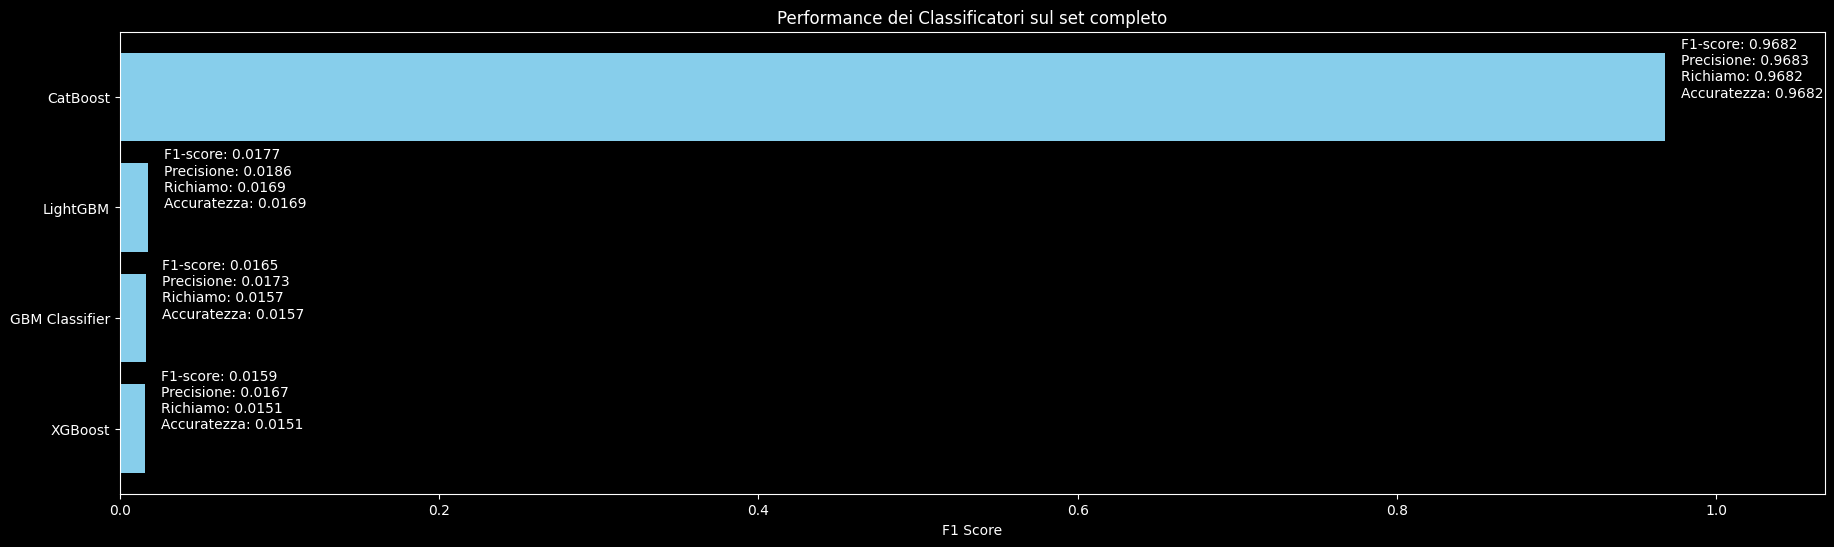

L'output dei modelli di classificazione mostra diverse metriche di performance, tra cui l'F1-score, la precisione, il richiamo e l'accuratezza. L'analisi delle metriche fornisce un'indicazione dell'efficacia dei modelli su dati realmente nuovi e non presenti durante l'addestramento.

**Analisi delle metriche**

1. **F1-score**:
   - L'F1-score rappresenta l'equilibrio tra Precisione e Richiamo. Un valore elevato su un test set indica una buona generalizzazione.
   - **CatBoost** ha ottenuto un F1-score di 0.9682, significativamente superiore rispetto agli altri modelli. Questo indica che CatBoost riesce a mantenere un buon equilibrio tra precisione e richiamo anche su dati non visti, confermandone l'affidabilità.
   - Gli altri modelli (LightGBM, GBM Classifier e XGBoost) hanno valori di F1 molto bassi, oscillanti tra 0.0159 e 0.0177, suggerendo che non sono riusciti a generalizzare efficacemente sui dati di test.

2. **Precisione**:
   - La precisione misura la proporzione di previsioni corrette tra tutte le previsioni fatte. Un valore elevato nel test set implica che il modello è in grado di fare previsioni accurate anche su nuovi dati.
   - **CatBoost** mantiene una precisione di 0.9683, dimostrando una notevole capacità di identificare correttamente i casi positivi senza introdurre molti falsi positivi, anche su dati sconosciuti.
   - Gli altri modelli, con precisioni inferiori allo 0.02, indicano una limitata capacità di fare previsioni corrette sui dati non visti.

3. **Richiamo**:
   - Il richiamo misura la proporzione di casi positivi correttamente identificati dal modello nel test set. Un valore elevato implica che il modello cattura una buona parte delle occorrenze positive anche su dati nuovi.
   - **CatBoost**, con un richiamo di 0.9682, dimostra di riuscire a riconoscere correttamente la maggior parte dei casi positivi nel set di test, confermandone l'efficacia.
   - Gli altri modelli, con valori di richiamo tra 0.0151 e 0.0169, suggeriscono difficoltà a identificare i casi positivi sui dati di test.

4. **Accuratezza**:
   - L'accuratezza indica la proporzione di previsioni corrette sul test set. Valori elevati indicano che il modello è in grado di generalizzare bene su nuovi dati.
   - **CatBoost** raggiunge un'accuratezza del 96.82% anche su dati non visti, dimostrando che il modello mantiene un'alta affidabilità fuori dal set di allenamento.
   - Gli altri modelli hanno accuratezze molto basse, intorno all'1.5-1.7%, suggerendo che non riescono a generalizzare sui dati di test.

CatBoost dimostra una superiorità netta su dati di test, il fatto che CatBoost mantenga prestazioni eccellenti su dati non visti conferma la sua capacità di generalizzare riducendo il rischio di overfitting. Questo lo rende il modello ideale per la raccomandazione di polizze assicurative.

Gli altri modelli mostrano scarsa generalizzazione, le performance molto basse di XGBoost, GBM Classifier e LightGBM sui dati di test suggeriscono che questi modelli non sono riusciti a catturare i pattern rilevanti nei dati durante l'addestramento. In questo caso questi modelli sono quindi meno affidabili per compiti di predizione.

CatBoost ha mostrato un aumento significativo dell'F1-score per diverse ragioni legate alle sue caratteristiche uniche e alla gestione delle variabili categoriali.

CatBoost è progettato per gestire le variabili categoriali in modo molto efficace, evitando la necessità di tecniche di codifica complesse come la codifica one-hot. Utilizza un metodo chiamato **target encoding** che stima il valore atteso del target per ciascuna categoria, riducendo il rischio di overfitting e migliorando la generalizzazione del modello[2].
Questo modello offre diverse funzioni di perdita ottimizzate, inclusa la possibilità di utilizzare l'F1-score come metrica durante l'addestramento. Questo significa che il modello può essere specificamente ottimizzato per massimizzare le prestazioni su questa metrica, portando a risultati migliori nel contesto delle classificazioni sbilanciate[1][3]. Grazie alla sua architettura ed alle tecniche avanzate di regolarizzazione, CatBoost tende a generalizzare meglio rispetto ad altri modelli, specialmente in presenza di dati complessi o rumorosi. Questo porta a una maggiore accuratezza nelle previsioni ed a un miglioramento dell'F1-score, che è una misura combinata di precisione e richiamo[4].
Il modello è stato addestrato su un dataset arricchito con regole di associazione, e questo potrebbe aver contribuito a migliorare ulteriormente l'F1-score. Le nuove feature derivate dalle regole possono fornire informazioni aggiuntive che aiutano CatBoost a fare previsioni più accurate[5].

CatBoost è chiaramente il modello più efficace anche su dati non visti, risultando il candidato principale per massimizzare le vendite attraverso la raccomandazione delle polizze assicurative.

Citations:
[1] https://stackoverflow.com/questions/61354410/python-catboost-multiclass-f1-score-custom-metric
[2] https://blog.dataiku.com/how-do-gradient-boosting-algorithms-handle-categorical-variables
[3] https://catboost.ai/docs/concepts/algorithm-score-functions
[4] https://www.bigdata4innovation.it/intelligenza-artificiale/confusion-matrix-guida-pratica-per-valutare-il-modello-di-classificazione/
[5] https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html
[6] https://catboost.ai/docs/concepts/python-reference_catboostclassifier_score
[7] https://webthesis.biblio.polito.it/15974/1/tesi.pdf
[8] https://www.ircres.cnr.it/images/iaf/IAF_02_2021.pdf